## Overview

In order to make it easier to train an object classification model, de-noise the data by normalizing images.  (using a model if possible, otherwise manually)

1. Images are not currently in the center, so they need to be centered.
2. They are at different zoom levels, because the eye is closer in some pictures and much further away in other picture.  They need to be normalized to the same zoom level.

## Auto-reload

In [9]:
import os
import pandas as pd
import shutil
from helper_functions import dataset_images_root, dataset_csv_root
from ultralytics import YOLO
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [10]:

# If true, will retrain yolo model, otherwise will load pretrained model 
retrain_yolo_model = False

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate unlabeled training and validation sets

Choose 200 images from different cases (eg, we don't want to use eyes from the same cases) so that they can be labeled with object detection bounding boxes for training with yolo

In [12]:
df = pd.read_csv(os.path.join(dataset_csv_root, "dataset_exploded.csv"))
df

Unnamed: 0  case_id                                         image_path left_or_right_eye          dr_level  \
0              0   969556  EyePacs1KDataset/587_587_resized_images/524876...               lft  Proliferative DR   
1              1   969556  EyePacs1KDataset/587_587_resized_images/524876...                rt  Proliferative DR   
2              2  1458068  EyePacs1KDataset/587_587_resized_images/371956...               lft       Severe NPDR   
3              3  1458068  EyePacs1KDataset/587_587_resized_images/371956...                rt       Severe NPDR   
4              4  1310562  EyePacs1KDataset/587_587_resized_images/914922...               lft  Proliferative DR   
...          ...      ...                                                ...               ...               ...   
2083         313  1467831  EyePacs1KDataset/587_587_resized_images/742351...               lft           Mild DR   
2084         314  1393544  EyePacs1KDataset/587_587_resized_images/968877...               lft             No DR   
2085         315  1393544  EyePacs1KDataset/587_587_resized_images/968877...                rt             No DR   
2086         316   789910  EyePacs1KDataset/587_587_resized_images/572400...               lft     Moderate NPDR   
2087         317   789910  EyePacs1KDataset/587_587_resized_images/572400...                rt     Moderate NPDR   

          dme  moderate_dr_plus   vtdr  dr_nodr  left_right_dr_mismatch  
0     No CSME              True   True     True                   False  
1     No CSME              True   True     True                   False  
2     No CSME              True   True     True                   False  
3     No CSME              True   True     True                   False  
4     No CSME              True   True     True                   False  
...       ...               ...    ...      ...                     ...  
2083  No CSME             False  False     True                   False  
2084  No CSME             False  False    False                   False  
2085  No CSME             False  False    False                   False  
2086  No CSME              True  False     True                   False  
2087  No CSME              True  False     True                   False  

[2088 rows x 10 columns]

In [13]:
num_training_images_target = 150
num_validation_images_target = 50
num_training_images_count = 0
num_validation_images_count = 0

normalized_eye_image_dataset_root = os.path.join(dataset_images_root, "normalized_eye_image_dataset")
training_normalized_eye_images = os.path.join(normalized_eye_image_dataset_root, "training")
validation_normalized_eye_images = os.path.join(normalized_eye_image_dataset_root, "validation")

for directory in [normalized_eye_image_dataset_root, training_normalized_eye_images, validation_normalized_eye_images]:
    if not os.path.exists(directory):
        print(f"Creating directory {directory}")
        os.makedirs(directory)

# Only want one image per case, track seen case ids in a dictionary
seen_case_ids = {}

# Iterate over the rows in the dataframe and copy the images to the new location
for i, row in df.iterrows():
    # print(f"Processing row {i} of {len(df)}: {row}")

    if row["case_id"] in seen_case_ids:
        continue

    # print(f"Case id: {row['case_id']}")
    # print(f"Image path: {row['image_path']}")
    
    # Record this case id as seen
    seen_case_ids[row["case_id"]] = row["case_id"]

    # Get the basename of the image path, eg, EyePacs1KDataset/eye_0001.jpg -> eye_0001.jpg
    image_path_basename = os.path.basename(row["image_path"])

    if num_training_images_count < num_training_images_target:
        num_training_images_count += 1
        output_path = os.path.join(training_normalized_eye_images, image_path_basename)

    elif num_validation_images_count < num_validation_images_target:
        num_validation_images_count += 1
        output_path = os.path.join(validation_normalized_eye_images, image_path_basename)
    else:
        # We have enough images
        break

    # Copy the image to the new location
    shutil.copy(row["image_path"], output_path)

    # print(f"Copying {row['image_path']} to {output_path}")


## Download labeled images

There are 200 images labeled with IRIS object detection labels here: https://drive.google.com/drive/folders/1VfGI4GmLR8yTrmD4Fm5mtEs7etqOwW3h?usp=sharing 

Ask Traun for access.

## Train yolo

In [14]:
# train the model
if retrain_yolo_model:
    model = YOLO("yolov8s.pt")  # load a pretrained model (recommended for training)
    results = model.train(
        data="/home/tleyden/Development/youth_eye_health/normalized_eye_image_yolo_config.yaml", 
        epochs=50
    )
else:
    # Load saved model
    model = YOLO("runs/detect/train4/weights/best.pt")


## Yolo inference on validation set

## Helper function to draw label on image

In [15]:
def superimpose_yolo_boxes(image_path, xmin, ymin, xmax, ymax, class_label):
    """
    Return an image object with the yolo bounding boxes superimposed.
    """
    
    image = cv2.imread(image_path)
    height, width, channels = image.shape
    
    line_thickness = round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1 


    color = [random.randint(0, 255) for _ in range(3)]

    top_left = (xmin, ymin)
    bottom_right = (xmax, ymax)
        
    cv2.rectangle(image, top_left, bottom_right, color, thickness=line_thickness, lineType=cv2.LINE_AA)

    # Shift the label down a few pixels if the bounding box is at the top of the image
    top_left_with_offset = top_left
    if ymin <= 20:
        top_left_with_offset = (xmin, ymin + 20)
    cv2.putText(image, str(class_label), top_left_with_offset, 0, line_thickness / 3, [225, 255, 255], thickness=line_thickness, lineType=cv2.LINE_AA)

    RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return RGB_im


## Use yolo model to create bounding boxes on subset of images

In [35]:

def create_bboxes_iris(model, source_images, source_images_root, return_result_images):
    result_imgs = []
    bboxes_by_img_path = {}

    for test_img_path in source_images:
        test_img_path = os.path.join(source_images_root, test_img_path)

        # Skip non-jpg files
        if not test_img_path.lower().endswith(".jpg"):
            continue
        
        results = model(test_img_path)
        if len(results) == 0:
            print(f"No results for {test_img_path}")
            continue

        if len(results[0].boxes) == 0:
            print(f"No bounding boxes for {test_img_path}")
            continue

        raw_bbox = results[0].boxes[0].data[0]
        xmin = int(raw_bbox[0].item())
        ymin = int(raw_bbox[1].item())
        xmax = int(raw_bbox[2].item())
        ymax = int(raw_bbox[3].item())

        bboxes_by_img_path[test_img_path] = {
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax
        }
        
        img = superimpose_yolo_boxes(
            test_img_path, 
            xmin=xmin,
            ymin=ymin,
            xmax=xmax,
            ymax=ymax,
            class_label="iris"
        )
        if return_result_images:
            result_imgs.append(img)

    return result_imgs, bboxes_by_img_path

In [29]:
validation_images_root = "EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images"

test_imgs_path = os.listdir(validation_images_root)
test_imgs_path = test_imgs_path[:10]
print(test_imgs_path)

result_imgs, bboxes_by_img_path = create_bboxes_iris(
    model, 
    test_imgs_path, 
    validation_images_root, 
    return_result_images=True
)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/73c5f600-1016828_1464496_14519681_Left_External.JPG: 640x640 1 iris, 36.3ms
Speed: 15.9ms preprocess, 36.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/5debdf90-847947_1205695_12640827_Left_External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/66dd9a83-746769_1047507_11393008_Left_External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/

['73c5f600-1016828_1464496_14519681_Left_External.JPG', '5debdf90-847947_1205695_12640827_Left_External.jpg', '66dd9a83-746769_1047507_11393008_Left_External.JPG', '7f7dc0c2-532528_1212753_12694772_Left_External.jpg', 'db20199f-1015297_1462153_14504160_Left_External.JPG', '2d7c5ab6-521453_1406341_14125178_Left_External.jpg', 'c6ed425c-972105_1398508_14069784_Left_External.jpg', '457e7a3b-538802_1382867_13957910_Left_External.jpg', '72f0d3e0-824130_1167365_12399318_Left_External.jpg', '64d036d8-894190_1435415_14328563_Left_External.jpg']
height: 587 width: 587
top_left: (214, 161) bottom_right: (377, 381)
height: 587 width: 587
top_left: (192, 209) bottom_right: (382, 430)
height: 587 width: 587
top_left: (160, 94) bottom_right: (479, 440)
height: 587 width: 587
top_left: (212, 223) bottom_right: (351, 389)
height: 587 width: 587
top_left: (231, 228) bottom_right: (383, 417)
height: 587 width: 587
top_left: (202, 207) bottom_right: (416, 408)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/c6ed425c-972105_1398508_14069784_Left_External.jpg: 640x640 1 iris, 12.3ms
Speed: 0.3ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/457e7a3b-538802_1382867_13957910_Left_External.jpg: 640x640 1 iris, 12.2ms
Speed: 0.3ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/72f0d3e0-824130_1167365_12399318_Left_External.jpg: 640x640 1 iris, 12.3ms
Speed: 0.3ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/nor

height: 587 width: 587
top_left: (209, 106) bottom_right: (395, 351)
height: 587 width: 587
top_left: (140, 78) bottom_right: (453, 492)
height: 587 width: 587
top_left: (225, 213) bottom_right: (370, 359)
height: 587 width: 587
top_left: (202, 179) bottom_right: (445, 412)


In [18]:
# BGR_im = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
# cv2.imwrite("labeled.jpg", BGR_im)

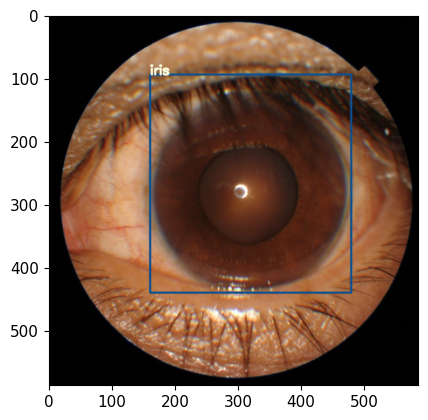

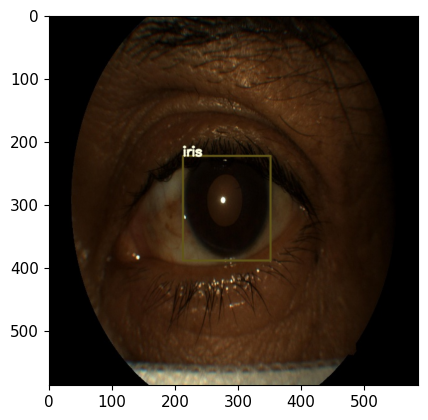

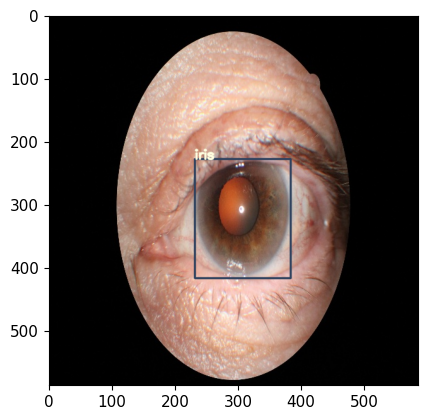

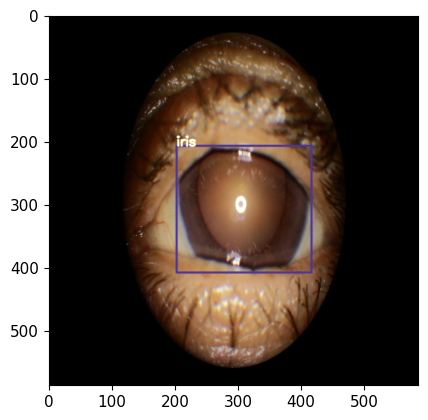

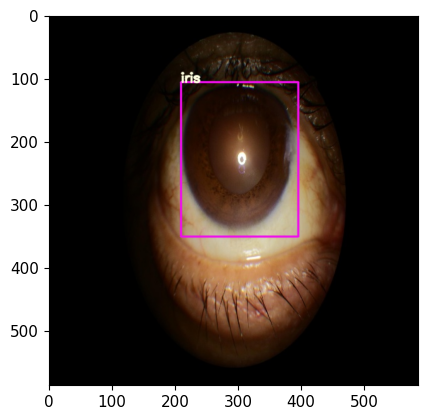

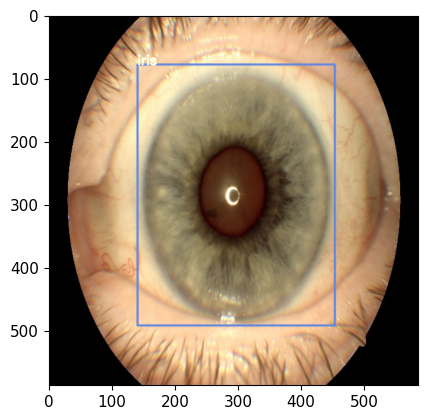

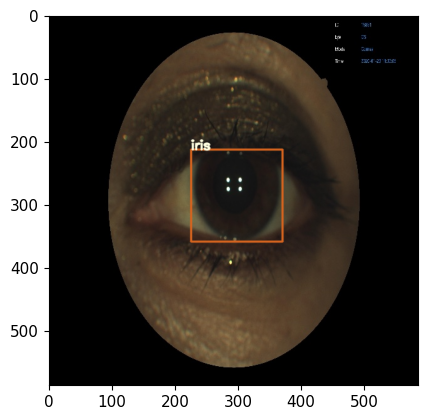

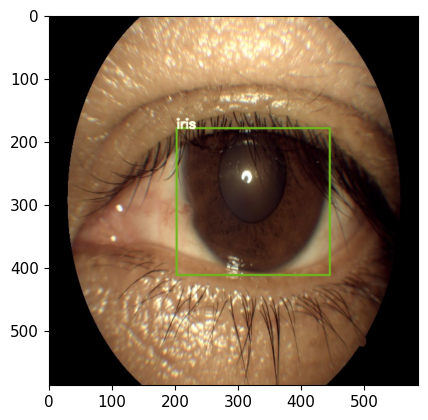

In [19]:
for i, image_to_display in enumerate(result_imgs):
  plt.figure()
  plt.imshow(image_to_display)


## Helper function to crop iris region

In [20]:
def crop_iris_region(image, iris_label_bbox):

    
     """
     Given an image in RGB format, and an iris label bounding box with xmin, ymin, xmax, ymax coords, do the following:

     1. Create a crop region that includes 15% of width on either side of bbox
     2. Crop that region out of the original image
     3. Place on black 587x587 image, with cropped region placed in the center
     4. Upscale it preserving aspect ratio until the smallest dimension of the bounding box reaches the edge of the new image (most likely the width)
     note: this upscaling will reduce quality and ideally the original high res images should be leveraged 

     """
     height, width, channels = image.shape
     xmin, ymin, xmax, ymax = iris_label_bbox
     print(f"img height: {height} width: {width}")
     print(f"bbox: {xmin, ymin, xmax, ymax}")

     # Create a crop region that includes 15% of width on either side of bbox
     bbox_width = xmax - xmin
     bbox_height = ymax - ymin
     print(f"bbox_width: {bbox_width} bbox_height: {bbox_height}")

     if bbox_width > bbox_height:

          print("bbox_width > bbox_height")

          crop_ymin = int(ymin) 
          crop_ymax = int(ymax)

          crop_xmin = int(xmin - (bbox_width * 0.25))

          # Make sure we don't go out of bounds
          if crop_xmin < 0:
               crop_xmin = 0

          crop_xmax = int(xmax + (bbox_width * 0.25))
          
          # Make sure we don't go out of bounds
          if crop_xmax > width:
               crop_xmax = width
               
          print(f"crop_xmin: {crop_xmin} crop_xmax: {crop_xmax}")

     else:
          print("bbox_width <= bbox_height")

          # crop_xmin = xmin
          # crop_xmax = xmax
          # crop_ymin = ymin
          # crop_ymax = ymax

          crop_ymin = int(ymin) 
          crop_ymax = int(ymax)

          crop_xmin = int(xmin - (bbox_width * 0.25))

          # Make sure we don't go out of bounds
          if crop_xmin < 0:
               crop_xmin = 0

          crop_xmax = int(xmax + (bbox_width * 0.25))
          
          # Make sure we don't go out of bounds
          if crop_xmax > width:
               crop_xmax = width
               
          print(f"crop_xmin: {crop_xmin} crop_xmax: {crop_xmax}")

     # img[start_row:end_row, start_col:end_col]
     cropped_image = image[crop_ymin:crop_ymax, crop_xmin:crop_xmax]

     cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

     # Resize cropped image to 587x587
     cropped_image_rgb = cv2.resize(cropped_image_rgb, (587, 587))

     # TODO: try to keep the same aspect ratio and superimpose on black background

     return cropped_image_rgb
    

## Crop out detected iris + surrounding region to separate images

In [21]:
cropped_images = []
for i, test_img_path in enumerate(test_imgs_path):
    test_img_path = os.path.join(validation_images_root, test_img_path)
    print(f"Processing {test_img_path}")
    image = cv2.imread(test_img_path)
    bbox_by_img_path_dict = bboxes_by_img_path[test_img_path]
    xmin = bbox_by_img_path_dict["xmin"]
    ymin = bbox_by_img_path_dict["ymin"]
    xmax = bbox_by_img_path_dict["xmax"]
    ymax = bbox_by_img_path_dict["ymax"]
    cropped_image = crop_iris_region(image, (xmin, ymin, xmax, ymax))
    cropped_images.append(cropped_image)



Processing EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/73c5f600-1016828_1464496_14519681_Left_External.JPG
img height: 587 width: 587
bbox: (214, 161, 377, 381)
bbox_width: 163 bbox_height: 220
bbox_width <= bbox_height
crop_xmin: 173 crop_xmax: 417
Processing EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/5debdf90-847947_1205695_12640827_Left_External.jpg
img height: 587 width: 587
bbox: (192, 209, 382, 430)
bbox_width: 190 bbox_height: 221
bbox_width <= bbox_height
crop_xmin: 144 crop_xmax: 429
Processing EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/66dd9a83-746769_1047507_11393008_Left_External.JPG
img height: 587 width: 587
bbox: (160, 94, 479, 440)
bbox_width: 319 bbox_height: 346
bbox_width <= bbox_height
crop_xmin: 80 crop_xmax: 558
Processing EyePacs1KDataset/normalized_eye_image_dataset/LabelStudioLabeled/validation/images/7f7dc0c2-532528_1212753_12694772_Left_Exter

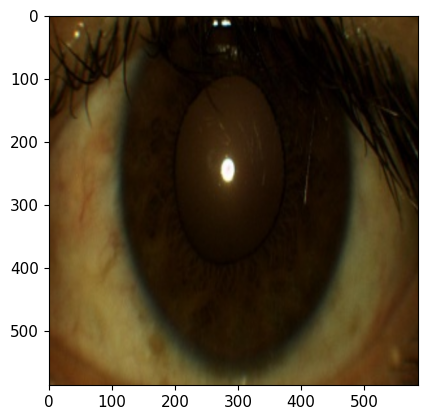

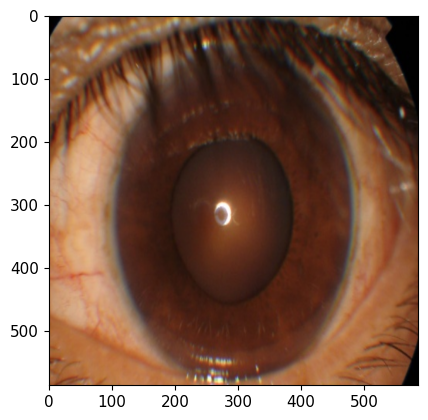

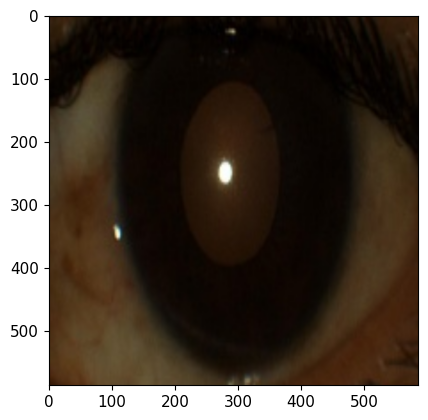

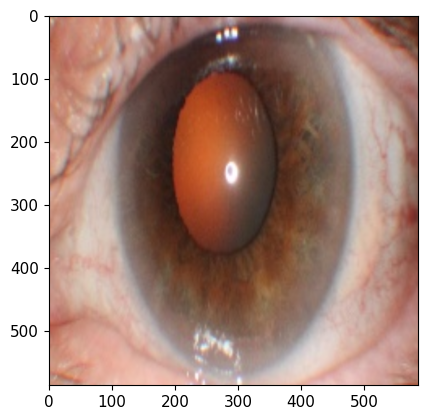

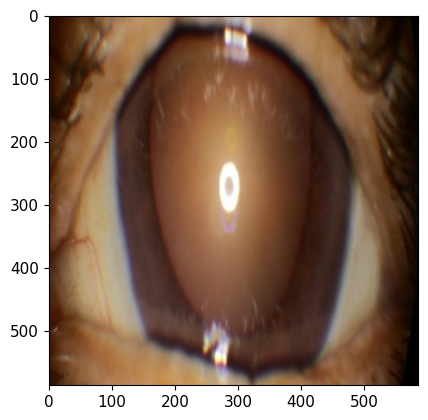

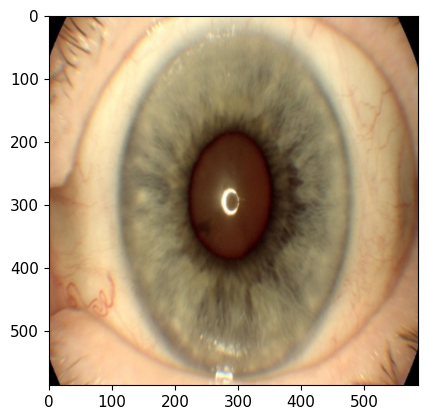

In [22]:
for i, cropped_image in enumerate(cropped_images):
  plt.figure()
  plt.imshow(cropped_image)


## Yolo inference on full data set

In [36]:
# Find all the image paths from the dataset
image_paths = []
counter = 0
for i, row in df.iterrows():
   

    # Get the basename of the image path, eg, EyePacs1KDataset/eye_0001.jpg -> eye_0001.jpg
    image_path_basename = os.path.basename(row["image_path"])
    image_paths.append(image_path_basename)

    counter += 1
    # if counter > 10:
    #     break

print(f"Create bounding boxes for {len(image_paths)}")

# Create bounding boxes for all the images
images_root = "EyePacs1KDataset"
_, bboxes_by_img_path = create_bboxes_iris(
    model, 
    image_paths, 
    images_root, 
    return_result_images=False
)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/524876_969556_10760784_Left External.jpg: 480x640 1 iris, 13.2ms
Speed: 16.0ms preprocess, 13.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/524876_969556_10760780_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



Create bounding boxes for 2088
height: 1920 width: 2560
top_left: (1039, 735) bottom_right: (1480, 1138)
height: 1920 width: 2560
top_left: (1025, 726) bottom_right: (1495, 1136)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/371956_1458068_14475121_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/371956_1458068_14475117_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1306, 845) bottom_right: (2599, 1816)


height: 2592 width: 3888
top_left: (1374, 861) bottom_right: (2509, 1681)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/914922_1310562_13425710_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1751, 1212) bottom_right: (3407, 2282)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/914922_1310562_13425711_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/997848_1436380_14335043_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1933, 1134) bottom_right: (3457, 2364)
height: 1934 width: 1956
top_left: (623, 890) bottom_right: (1253, 1394)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/997848_1436380_14335042_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/999326_1438527_14349095_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/999326_1438527_14349091_Right External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/156410_1443225_14381704_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (697, 860) bottom_right: (1209, 1259)
height: 1934 width: 2576
top_left: (704, 565) bottom_right: (1829, 1505)
height: 1934 width: 1956
top_left: (595, 812) bottom_right: (1178, 1328)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/156410_1443225_14381705_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019515_1468449_14545081_Left External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (601, 423) bottom_right: (1578, 1293)
height: 1934 width: 1956
top_left: (413, 805) bottom_right: (1398, 1375)
height: 1934 width: 1956
top_left: (574, 714) bottom_right: (1363, 1338)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019515_1468449_14545077_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920446_1319505_13492433_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920446_1319505_13492432_Right External.JPG: 640x640 1 iris, 13.5ms
Speed: 0.4ms preprocess, 13.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (533, 585) bottom_right: (1314, 1252)
height: 1934 width: 1956
top_left: (300, 286) bottom_right: (1617, 1564)
height: 1934 width: 1956
top_left: (250, 314) bottom_right: (1528, 1573)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/811609_1375927_13906443_Left External.jpg: 480x640 1 iris, 11.1ms
Speed: 0.3ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/811609_1375927_13906438_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/944015_1355828_13760122_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (1077, 787) bottom_right: (1590, 1093)
height: 1944 width: 2592
top_left: (989, 624) bottom_right: (1467, 1061)
height: 1824 width: 2736
top_left: (1018, 752) bottom_right: (1829, 1324)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/944015_1355828_13760123_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1000831_1243838_12934175_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (847, 726) bottom_right: (1552, 1288)
height: 2592 width: 3888
top_left: (1219, 901) bottom_right: (2392, 1800)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1000831_1243838_12934174_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/806917_1466111_14530019_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/806917_1466111_14530016_Right External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1319, 937) bottom_right: (2616, 2152)
height: 1824 width: 2736
top_left: (942, 391) bottom_right: (1946, 1267)
height: 1824 width: 2736
top_left: (833, 290) bottom_right: (1862, 1214)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920446_1319505_13492433_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920446_1319505_13492432_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/599078_1453469_14443868_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (300, 286) bottom_right: (1617, 1564)
height: 1934 width: 1956
top_left: (250, 314) bottom_right: (1528, 1573)
height: 1920 width: 2560
top_left: (1058, 773) bottom_right: (1835, 1286)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/599078_1453469_14443867_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/839176_1467409_14537844_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (749, 721) bottom_right: (1568, 1264)
height: 3072 width: 4096
top_left: (1635, 1082) bottom_right: (2450, 1791)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/839176_1467409_14537840_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/999488_1438800_14351311_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1514, 1080) bottom_right: (2515, 1909)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/999488_1438800_14351310_Right External.jpg: 480x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1578, 1027) bottom_right: (2592, 1846)


height: 3072 width: 4096
top_left: (1482, 1012) bottom_right: (2542, 1917)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767588_1468288_14544895_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1936, 832) bottom_right: (3678, 2514)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767588_1468288_14544898_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995995_1433532_14315685_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1758, 908) bottom_right: (3408, 2479)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995995_1433532_14315686_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1727, 1045) bottom_right: (2516, 1634)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/964120_1386392_13983721_Left External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1361, 1142) bottom_right: (2212, 1726)
height: 2304 width: 3456
top_left: (1290, 777) bottom_right: (2416, 1704)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/964120_1386392_13983722_Right External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/910255_1303258_13370336_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/910255_1303258_13370334_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (971, 699) bottom_right: (2176, 1835)
height: 1934 width: 1956
top_left: (572, 593) bottom_right: (1585, 1399)
height: 1934 width: 1956
top_left: (401, 616) bottom_right: (1406, 1410)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/885327_1266307_13103039_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/885327_1266307_13103038_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1488, 692) bottom_right: (2153, 1288)
height: 2304 width: 3456
top_left: (1264, 718) bottom_right: (2089, 1397)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/681009_1468628_14546395_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/681009_1468628_14546401_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/820963_1468889_14548061_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (680, 810) bottom_right: (1709, 1487)
height: 1920 width: 2560
top_left: (794, 402) bottom_right: (1759, 1078)
height: 1934 width: 1956
top_left: (550, 656) bottom_right: (1517, 1348)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/820963_1468889_14548064_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/705250_981932_10861144_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/705250_981932_10861140_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (456, 701) bottom_right: (1467, 1361)
height: 1944 width: 2592
top_left: (897, 426) bottom_right: (1969, 1418)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890129_1273888_13162297_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890129_1273888_13162300_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (675, 512) bottom_right: (1648, 1417)
height: 1920 width: 2560
top_left: (1044, 832) bottom_right: (1554, 1121)
height: 1920 width: 2560
top_left: (1006, 778) bottom_right: (1505, 1124)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/648840_1414053_14180139_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/648840_1414053_14180138_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (943, 461) bottom_right: (1856, 1340)
height: 1824 width: 2736
top_left: (769, 413) bottom_right: (1665, 1270)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/681932_946662_10577966_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2848 width: 4272
top_left: (1452, 1366) bottom_right: (2900, 2347)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/681932_946662_10577963_Right External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/639518_883613_10079002_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2848 width: 4272
top_left: (1400, 1060) bottom_right: (3105, 2378)
height: 1944 width: 2592
top_left: (1015, 611) bottom_right: (1624, 1275)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/639518_883613_10079003_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (783, 514) bottom_right: (1682, 1350)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/997526_1435863_14331894_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/997526_1435863_14331895_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1662, 893) bottom_right: (2688, 1860)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015059_1461804_14501331_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1623, 1084) bottom_right: (2683, 1972)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015059_1461804_14501327_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1643, 1187) bottom_right: (2524, 1937)
height: 3072 width: 4096
top_left: (1509, 1082) bottom_right: (2493, 1935)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015105_1461875_14501879_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015105_1461875_14501875_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1439, 807) bottom_right: (2326, 1697)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/959953_1380271_13938586_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1554, 787) bottom_right: (2439, 1632)
height: 2592 width: 3888
top_left: (1579, 720) bottom_right: (2930, 1758)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/959953_1380271_13938587_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021142_1470912_14561661_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1503, 704) bottom_right: (2841, 1767)


height: 3072 width: 4096
top_left: (1572, 1089) bottom_right: (2564, 1874)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021142_1470912_14561668_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/427587_1461416_14498575_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/427587_1461416_14498576_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1554, 1203) bottom_right: (2597, 1935)
height: 1920 width: 2560
top_left: (838, 627) bottom_right: (1538, 1203)
height: 1920 width: 2560
top_left: (854, 658) bottom_right: (1598, 1201)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/806989_1458135_14476012_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/806989_1458135_14476011_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (998, 498) bottom_right: (1794, 1307)
height: 1824 width: 2736
top_left: (896, 604) bottom_right: (1698, 1331)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/814863_1467372_14537688_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1653, 883) bottom_right: (2725, 1853)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/814863_1467372_14537687_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/411727_1368953_13856091_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/411727_1368953_13856089_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1426, 1050) bottom_right: (2453, 1979)
height: 1934 width: 1956
top_left: (549, 550) bottom_right: (1515, 1388)
height: 1934 width: 1956
top_left: (489, 559) bottom_right: (1543, 1473)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016546_1464077_14516744_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016546_1464077_14516743_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/527312_1465497_14525693_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (271, 487) bottom_right: (1667, 1585)
height: 1934 width: 1956
top_left: (353, 508) bottom_right: (1611, 1524)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/527312_1465497_14525692_Right External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1285, 821) bottom_right: (2237, 1642)
height: 2304 width: 3456
top_left: (1223, 741) bottom_right: (2062, 1611)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012493_1457732_14472579_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012493_1457732_14472577_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (440, 500) bottom_right: (1543, 1476)
height: 1934 width: 1956
top_left: (448, 467) bottom_right: (1441, 1332)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/794413_1121292_11982204_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2848 width: 4272
top_left: (1281, 1172) bottom_right: (2715, 2284)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/794413_1121292_11982205_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2848 width: 4272
top_left: (1428, 1128) bottom_right: (2755, 2216)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/419948_651927_8261292_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1530, 722) bottom_right: (2972, 2036)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/419948_651927_8261297_Right External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1566, 812) bottom_right: (3001, 2093)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020721_1470224_14556736_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020721_1470224_14556730_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1651, 1093) bottom_right: (2609, 2026)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/538555_1455988_14461686_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1470, 970) bottom_right: (2458, 2072)


height: 3072 width: 4096
top_left: (1607, 1231) bottom_right: (2570, 1939)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/538555_1455988_14461679_Right External.jpg: 480x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/998635_1437527_14342610_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1372, 1108) bottom_right: (2467, 1997)


height: 2800 width: 2800
top_left: (776, 1007) bottom_right: (1903, 1930)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/989632_1424343_14251454_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2257, 932) bottom_right: (3923, 2507)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/989632_1424343_14251450_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/990999_1426344_14265758_Left External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1808, 890) bottom_right: (3469, 2316)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/990999_1426344_14265757_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1208, 1279) bottom_right: (2257, 2046)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/819336_1211101_12682321_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/586150_817840_9567197_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1539, 1198) bottom_right: (2628, 2008)
height: 1934 width: 1956
top_left: (668, 657) bottom_right: (1456, 1275)
height: 1920 width: 2560
top_left: (915, 771) bottom_right: (1508, 1136)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/889078_1466800_14533953_Left External.JPG: 640x640 1 iris, 14.1ms
Speed: 0.3ms preprocess, 14.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/889078_1466800_14533952_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/850692_1210266_12676089_Left External.jpg: 448x640 1 iris, 39.5ms
Speed: 0.3ms preprocess, 39.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (437, 618) bottom_right: (1655, 1638)
height: 1934 width: 1956
top_left: (394, 549) bottom_right: (1518, 1572)
height: 1824 width: 2736
top_left: (997, 622) bottom_right: (1898, 1388)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/850692_1210266_12676087_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/495786_1457213_14469224_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/495786_1457213_14469225_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (771, 476) bottom_right: (1836, 1409)
height: 1944 width: 2592
top_left: (723, 531) bottom_right: (1823, 1296)
height: 1944 width: 2592
top_left: (917, 460) bottom_right: (1947, 1260)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016819_1464484_14519548_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016819_1464484_14519552_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020795_1470336_14557561_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (375, 609) bottom_right: (1249, 1209)
height: 1934 width: 1956
top_left: (426, 430) bottom_right: (1888, 1605)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020795_1470336_14557557_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1643, 1112) bottom_right: (2614, 2036)
height: 3072 width: 4096
top_left: (1577, 1080) bottom_right: (2535, 2024)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019810_1468885_14548135_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019810_1468885_14548138_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008784_1452137_14435160_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (893, 501) bottom_right: (1692, 1243)
height: 1824 width: 2736
top_left: (903, 522) bottom_right: (1740, 1273)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008784_1452137_14435162_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1242, 705) bottom_right: (2189, 1446)
height: 2336 width: 3504
top_left: (1130, 570) bottom_right: (2293, 1442)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861432_1227820_12808977_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861432_1227820_12808976_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1394, 871) bottom_right: (2015, 1403)
height: 2304 width: 3456
top_left: (1419, 835) bottom_right: (2033, 1375)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/990163_1425116_14257205_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/990163_1425116_14257206_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1483, 904) bottom_right: (2538, 1881)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/871833_1245103_12942722_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/871833_1245103_12942720_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1706, 971) bottom_right: (2765, 1980)
height: 1920 width: 2560
top_left: (1072, 775) bottom_right: (1558, 1178)
height: 1920 width: 2560
top_left: (1064, 775) bottom_right: (1583, 1169)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/748964_1050888_11420668_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1923, 1054) bottom_right: (3623, 2647)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/748964_1050888_11420669_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/778666_1096768_11787835_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1284, 1089) bottom_right: (3182, 2732)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/926960_1465659_14526769_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/926960_1465659_14526768_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1349, 828) bottom_right: (2874, 2046)
height: 1934 width: 1956
top_left: (497, 635) bottom_right: (1536, 1525)
height: 1934 width: 1956
top_left: (537, 649) bottom_right: (1327, 1407)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/708779_987612_10907118_Right External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/708779_987612_10907115_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1250, 682) bottom_right: (2997, 2223)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840764_1195090_12565393_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840764_1195090_12565392_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1062, 850) bottom_right: (2681, 2158)
height: 2304 width: 3456
top_left: (1381, 896) bottom_right: (2295, 1699)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767406_1079593_11653252_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1279, 767) bottom_right: (2204, 1565)
height: 2336 width: 3504
top_left: (881, 341) bottom_right: (2624, 1939)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767406_1079593_11653251_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/157563_832144_9679843_Left External.JPG: 640x640 1 iris, 13.9ms
Speed: 0.4ms preprocess, 13.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/157563_832144_9679842_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (825, 295) bottom_right: (2728, 2038)
height: 1934 width: 1956
top_left: (565, 495) bottom_right: (1712, 1406)
height: 1934 width: 1956
top_left: (254, 294) bottom_right: (1577, 1536)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/693910_964274_10718375_Right External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2009, 1422) bottom_right: (3520, 2700)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/693910_964274_10718374_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/965486_1388504_13998264_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1799, 1354) bottom_right: (3348, 2575)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/965486_1388504_13998260_Right External.JPG: 448x640 1 iris, 23.4ms
Speed: 0.3ms preprocess, 23.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1219, 653) bottom_right: (2138, 1522)
height: 2304 width: 3456
top_left: (1249, 862) bottom_right: (2159, 1454)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/740710_1037980_11315689_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/740710_1037980_11315685_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/535528_1449077_14415153_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1036, 653) bottom_right: (1913, 1263)
height: 1824 width: 2736
top_left: (867, 563) bottom_right: (1714, 1326)
height: 1944 width: 2592
top_left: (751, 427) bottom_right: (2014, 1375)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/535528_1449077_14415147_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/579028_1466183_14529970_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (651, 441) bottom_right: (2012, 1509)
height: 2592 width: 3888
top_left: (1531, 703) bottom_right: (2687, 1688)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/579028_1466183_14529966_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/935873_1343143_13668663_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/935873_1343143_13668649_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1419, 754) bottom_right: (2434, 1685)
height: 1944 width: 2592
top_left: (876, 482) bottom_right: (1852, 1223)
height: 1944 width: 2592
top_left: (795, 460) bottom_right: (1823, 1314)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018431_1466817_14534304_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018431_1466817_14534303_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1522, 988) bottom_right: (2607, 1914)
height: 3072 width: 4096
top_left: (1489, 993) bottom_right: (2542, 1923)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/440376_691488_8571390_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/440376_691488_8571385_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/981846_1412940_14172247_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (890, 849) bottom_right: (1551, 1423)
height: 1944 width: 2592
top_left: (1127, 856) bottom_right: (1781, 1354)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/981846_1412940_14172246_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/946490_1468405_14544684_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1310, 746) bottom_right: (2351, 1734)
height: 2304 width: 3456
top_left: (1053, 774) bottom_right: (2100, 1796)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/946490_1468405_14544678_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010657_1454934_14455612_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (966, 311) bottom_right: (1989, 1169)
height: 1920 width: 2560
top_left: (390, 494) bottom_right: (1613, 1533)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010657_1454934_14455608_Left External.jpg: 480x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1605, 1229) bottom_right: (2558, 2025)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/535581_995199_10969245_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/535581_995199_10969243_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1599, 1124) bottom_right: (2594, 1923)
height: 1920 width: 2560
top_left: (980, 508) bottom_right: (1773, 1283)
height: 1920 width: 2560
top_left: (812, 483) bottom_right: (1636, 1240)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/545750_1465236_14524289_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/545750_1465236_14524290_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018822_1467407_14537831_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (930, 757) bottom_right: (1600, 1243)
height: 1920 width: 2560
top_left: (790, 637) bottom_right: (1586, 1204)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018822_1467407_14537827_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1653, 861) bottom_right: (2635, 1695)
height: 2592 width: 3888
top_left: (1548, 797) bottom_right: (2530, 1671)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/100984_1448406_14413675_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020182_1469427_14551726_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (914, 578) bottom_right: (1805, 1276)


height: 3072 width: 4096
top_left: (1589, 930) bottom_right: (2490, 1565)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020182_1469427_14551724_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/839305_1192700_12546896_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1772, 1113) bottom_right: (2777, 1942)
height: 2336 width: 3504
top_left: (1419, 746) bottom_right: (2296, 1503)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/839305_1192700_12546895_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/830032_1177350_12426367_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2336 width: 3504
top_left: (1264, 838) bottom_right: (2123, 1564)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/830032_1177350_12426366_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1410, 725) bottom_right: (2570, 1780)
height: 2592 width: 3888
top_left: (1456, 680) bottom_right: (2703, 1883)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/776702_1191004_12533582_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/776702_1191004_12533581_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1673, 796) bottom_right: (2669, 1779)
height: 2304 width: 3456
top_left: (845, 637) bottom_right: (1997, 1645)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/702524_977807_10829287_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/954419_1371787_13876154_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/954419_1371787_13876153_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1402, 900) bottom_right: (2079, 1457)
height: 1824 width: 2736
top_left: (925, 688) bottom_right: (1755, 1184)
height: 1824 width: 2736
top_left: (935, 544) bottom_right: (1744, 1099)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/772038_1465616_14526473_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1531, 1130) bottom_right: (2496, 1846)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/772038_1465616_14526474_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1529, 1140) bottom_right: (2557, 2003)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/387357_546702_7433920_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1971, 1145) bottom_right: (2924, 2010)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/387357_546702_7433916_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/917822_1315247_13461115_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/847450_1204903_12634891_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1982, 1297) bottom_right: (2921, 2094)
height: 1934 width: 1956
top_left: (675, 710) bottom_right: (1258, 1184)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840533_1194806_12563323_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (364, 441) bottom_right: (1503, 1498)
height: 1944 width: 2592
top_left: (978, 642) bottom_right: (1571, 1148)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840533_1194806_12563319_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014868_1461524_14499360_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014868_1461524_14499367_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (975, 685) bottom_right: (1590, 1190)
height: 1944 width: 2592
top_left: (784, 667) bottom_right: (1765, 1459)
height: 1944 width: 2592
top_left: (655, 882) bottom_right: (1563, 1530)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/926490_1329024_13562023_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1499, 1125) bottom_right: (2566, 1878)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/926490_1329024_13562019_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919060_1317261_13476122_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919060_1317261_13476121_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1282, 984) bottom_right: (2810, 2037)
height: 1934 width: 1956
top_left: (300, 286) bottom_right: (1617, 1564)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020008_1469190_14550277_Left External.jpg: 480x640 1 iris, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020008_1469190_14550273_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (250, 314) bottom_right: (1528, 1573)
height: 1920 width: 2560
top_left: (794, 324) bottom_right: (1757, 1110)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/899032_1288081_13272989_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/899032_1288081_13272990_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (883, 509) bottom_right: (1827, 1286)
height: 1934 width: 1956
top_left: (309, 430) bottom_right: (1593, 1646)
height: 1934 width: 1956
top_left: (412, 516) bottom_right: (1599, 1541)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/941649_1352059_13731683_Left External.JPG: 448x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1935, 848) bottom_right: (3479, 2277)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/978784_1408655_14141419_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/978784_1408655_14141415_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1291, 709) bottom_right: (2405, 1546)


height: 2592 width: 3888
top_left: (1258, 768) bottom_right: (2306, 1740)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/827184_1434141_14319421_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2194, 1116) bottom_right: (3531, 2364)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/827184_1434141_14319428_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1868, 1162) bottom_right: (3114, 2316)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004349_1446068_14401151_Left External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004349_1446068_14401153_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/973648_1463940_14515815_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1332, 520) bottom_right: (2487, 1693)
height: 2304 width: 3456
top_left: (1219, 926) bottom_right: (2251, 1831)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/973648_1463940_14515811_Left External.jpg: 640x640 1 iris, 13.5ms
Speed: 0.3ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/612352_975108_10806775_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (209, 363) bottom_right: (1610, 1535)
height: 1934 width: 1956
top_left: (329, 417) bottom_right: (1561, 1394)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/612352_975108_10806774_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1282, 919) bottom_right: (2665, 2067)
height: 2592 width: 3888
top_left: (1144, 755) bottom_right: (2607, 2056)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/765028_1076021_11623907_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/765028_1076021_11623909_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/513910_1401979_14093169_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (982, 624) bottom_right: (1641, 1232)
height: 1920 width: 2560
top_left: (853, 644) bottom_right: (1630, 1308)
height: 1944 width: 2592
top_left: (1027, 826) bottom_right: (1613, 1311)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/998471_1437297_14341219_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/998471_1437297_14341228_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1542, 1048) bottom_right: (2625, 1916)


height: 3072 width: 4096
top_left: (1476, 1028) bottom_right: (2572, 1985)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015646_1462710_14507766_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1527, 1299) bottom_right: (2591, 1896)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015646_1462710_14507771_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020632_1470095_14555884_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020632_1470095_14555885_Right External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1510, 1310) bottom_right: (2656, 1830)
height: 1728 width: 2592
top_left: (1043, 554) bottom_right: (1828, 1239)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/390956_1431203_14299330_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1728 width: 2592
top_left: (989, 503) bottom_right: (1697, 1129)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/390956_1431203_14299331_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1199, 718) bottom_right: (2376, 1747)
height: 2336 width: 3504
top_left: (1268, 741) bottom_right: (2238, 1560)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/652895_1138597_12119983_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/652895_1138597_12119980_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1003884_1445374_14445580_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (871, 539) bottom_right: (1670, 1224)
height: 1920 width: 2560
top_left: (792, 512) bottom_right: (1591, 1203)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1003884_1445374_14445557_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (915, 1124) bottom_right: (2023, 1934)
height: 2800 width: 2800
top_left: (573, 1043) bottom_right: (1845, 2060)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/984259_1416544_14197015_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1488, 1071) bottom_right: (2583, 1826)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/984259_1416544_14197014_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1591, 1261) bottom_right: (2612, 1788)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/970581_1396182_14052620_Left External.JPG: 448x640 1 iris, 11.5ms
Speed: 0.3ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/970581_1396182_14052616_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1418, 959) bottom_right: (2454, 1889)


height: 2592 width: 3888
top_left: (1482, 764) bottom_right: (2562, 1683)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/777923_1468369_14546799_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1506, 1146) bottom_right: (2582, 1877)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/777923_1468369_14546798_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/752175_1469943_14554825_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/752175_1469943_14554826_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1493, 1128) bottom_right: (2515, 1830)
height: 1934 width: 1956
top_left: (425, 219) bottom_right: (1625, 1368)
height: 1934 width: 1956
top_left: (357, 493) bottom_right: (1444, 1419)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/968475_1392969_14029529_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/968475_1392969_14029526_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1281, 833) bottom_right: (2478, 1801)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875610_1251052_12987458_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875610_1251052_12987454_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1467, 828) bottom_right: (2666, 1829)
height: 1944 width: 2592
top_left: (897, 719) bottom_right: (1714, 1260)
height: 1944 width: 2592
top_left: (1118, 839) bottom_right: (1735, 1250)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/918398_1316149_13467827_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/918398_1316149_13467824_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/598547_1467445_14538186_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/598547_1467445_14538184_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (491, 703) bottom_right: (1484, 1167)
height: 1934 width: 1956
top_left: (475, 641) bottom_right: (1428, 1247)
height: 1728 width: 2592
top_left: (1090, 586) bottom_right: (1709, 1088)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/999697_1439122_14353348_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1728 width: 2592
top_left: (1016, 611) bottom_right: (1595, 1052)


height: 2592 width: 3888
top_left: (1540, 955) bottom_right: (2503, 1751)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/999697_1439122_14353344_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1341, 887) bottom_right: (2347, 1756)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/776761_1093811_11764809_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1963, 1103) bottom_right: (3242, 2347)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/776761_1093811_11764810_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713832_1470066_14555802_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1277, 1080) bottom_right: (2750, 2176)
height: 1824 width: 2736
top_left: (935, 314) bottom_right: (1888, 1294)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713832_1470066_14555801_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993301_1429577_14288010_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (919, 511) bottom_right: (1791, 1187)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993301_1429577_14288016_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1264, 653) bottom_right: (2835, 2069)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012458_1457671_14472720_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1140, 653) bottom_right: (2798, 1990)


height: 3072 width: 4096
top_left: (1564, 1204) bottom_right: (2575, 1855)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012458_1457671_14472721_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008056_1451049_14427946_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1527, 1165) bottom_right: (2490, 1845)


height: 3072 width: 4096
top_left: (1497, 1124) bottom_right: (2437, 1932)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008056_1451049_14427945_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1484, 1037) bottom_right: (2511, 1927)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/941547_1351894_13730507_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2019, 1206) bottom_right: (3534, 2543)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/941547_1351894_13730513_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004368_1446113_14465326_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1727, 1064) bottom_right: (3270, 2475)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004368_1446113_14465321_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (1053, 1079) bottom_right: (1886, 1827)
height: 2800 width: 2800
top_left: (815, 910) bottom_right: (1796, 1841)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875610_1251052_12987458_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875610_1251052_12987454_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (897, 719) bottom_right: (1714, 1260)
height: 1944 width: 2592
top_left: (1118, 839) bottom_right: (1735, 1250)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013318_1459018_14483378_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1653, 1268) bottom_right: (2602, 1918)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013318_1459018_14483377_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/933146_1339222_13637861_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1575, 1192) bottom_right: (2506, 1832)
height: 1944 width: 2592
top_left: (575, 463) bottom_right: (1974, 1680)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/855966_1329947_13568517_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017540_1465473_14526482_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (588, 608) bottom_right: (1254, 1246)


height: 3072 width: 4096
top_left: (1505, 1229) bottom_right: (2440, 1943)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017540_1465473_14526481_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/654985_906973_10263575_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1363, 1252) bottom_right: (2318, 1623)
height: 1944 width: 2592
top_left: (588, 557) bottom_right: (1758, 1539)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/654985_906973_10263571_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010082_1454057_14448294_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (740, 696) bottom_right: (1747, 1567)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010082_1454057_14448290_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1481, 1090) bottom_right: (2517, 2089)


height: 3072 width: 4096
top_left: (1493, 1104) bottom_right: (2502, 2042)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/907206_1451761_14433250_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2362, 1106) bottom_right: (3876, 2436)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/907206_1451761_14433249_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/940108_1349749_13715140_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1973, 1085) bottom_right: (3497, 2435)
height: 1920 width: 2560
top_left: (1037, 740) bottom_right: (1535, 1171)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/940108_1349749_13715138_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019195_1467982_14542070_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019195_1467982_14542066_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/878077_1371795_13876217_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (987, 702) bottom_right: (1506, 1198)
height: 1934 width: 1956
top_left: (546, 525) bottom_right: (1545, 1382)
height: 1934 width: 1956
top_left: (756, 738) bottom_right: (1342, 1245)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/878077_1371795_13876218_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (247, 312) bottom_right: (1614, 1572)
height: 1934 width: 1956
top_left: (234, 370) bottom_right: (1682, 1597)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016954_1464667_14521016_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1459, 1266) bottom_right: (2609, 2021)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019870_1468981_14549708_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1687, 1153) bottom_right: (2544, 1835)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019870_1468981_14549717_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/981484_1412379_14168103_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1712, 1163) bottom_right: (2562, 1868)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/981484_1412379_14168102_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1160, 590) bottom_right: (2344, 1471)
height: 2304 width: 3456
top_left: (1070, 491) bottom_right: (2368, 1594)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/958584_1378190_13923237_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/958584_1378190_13923236_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (955, 493) bottom_right: (1873, 1299)
height: 1824 width: 2736
top_left: (753, 431) bottom_right: (1721, 1308)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/622415_858169_9880238_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/622415_858169_9880237_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1064, 788) bottom_right: (2535, 1678)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/778707_1096838_11788319_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/778707_1096838_11788315_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1078, 737) bottom_right: (2629, 1795)
height: 1934 width: 1956
top_left: (503, 435) bottom_right: (1437, 1285)
height: 1934 width: 1956
top_left: (522, 534) bottom_right: (1438, 1379)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1009726_1453526_14502915_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1009726_1453526_14502906_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (984, 1022) bottom_right: (1828, 1703)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017290_1465090_14523235_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017290_1465090_14523239_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (731, 753) bottom_right: (1806, 1654)
height: 1944 width: 2592
top_left: (1082, 745) bottom_right: (1806, 1384)
height: 1944 width: 2592
top_left: (790, 399) bottom_right: (1669, 1163)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/967750_1391843_14021193_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/967750_1391843_14021186_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/863308_1348796_13707892_Left External.jpg: 640x640 1 iris, 13.7ms


height: 1944 width: 2592
top_left: (651, 565) bottom_right: (1935, 1523)
height: 1944 width: 2592
top_left: (702, 563) bottom_right: (2113, 1518)


Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/863308_1348796_13707888_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (814, 758) bottom_right: (1849, 1613)
height: 2800 width: 2800
top_left: (768, 745) bottom_right: (1931, 1730)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/976630_1405341_14117319_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/976630_1405341_14117318_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (756, 561) bottom_right: (1738, 1448)
height: 1920 width: 2560
top_left: (676, 537) bottom_right: (1629, 1427)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018690_1467189_14536164_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1559, 1229) bottom_right: (2545, 2019)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018690_1467189_14536160_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977189_1406210_14123406_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1540, 1129) bottom_right: (2573, 1993)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977189_1406210_14123402_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1592, 793) bottom_right: (2521, 1637)
height: 2592 width: 3888
top_left: (1433, 773) bottom_right: (2469, 1665)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/766586_1447125_14408871_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/766586_1447125_14408872_Right External.jpg: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (896, 901) bottom_right: (2018, 1939)
height: 2800 width: 2800
top_left: (628, 984) bottom_right: (1802, 1992)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016828_1464496_14519681_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016828_1464496_14519677_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1413, 709) bottom_right: (2507, 1692)
height: 2592 width: 3888
top_left: (1405, 833) bottom_right: (2482, 1660)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/746769_1047507_11393008_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/746769_1047507_11393004_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (534, 302) bottom_right: (1597, 1448)
height: 1934 width: 1956
top_left: (764, 560) bottom_right: (1488, 1202)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983289_1415113_14187390_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983289_1415113_14187392_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (980, 915) bottom_right: (2310, 1883)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/894190_1435415_14328563_Left External.jpg: 480x640 1 iris, 18.5ms
Speed: 0.3ms preprocess, 18.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/894190_1435415_14328564_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1309, 798) bottom_right: (2684, 1933)
height: 1944 width: 2592
top_left: (891, 583) bottom_right: (1981, 1367)
height: 1944 width: 2592
top_left: (707, 649) bottom_right: (1653, 1388)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/705721_1393811_14035374_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/705721_1393811_14035370_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977868_1407296_14131680_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (467, 544) bottom_right: (1306, 1208)
height: 1934 width: 1956
top_left: (318, 474) bottom_right: (1758, 1555)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977868_1407296_14131679_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1416, 1032) bottom_right: (2640, 2071)
height: 3072 width: 4096
top_left: (1460, 1086) bottom_right: (2592, 2014)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/431896_690721_8565371_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/431896_690721_8565370_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1645, 705) bottom_right: (3210, 2206)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/724661_1454262_14449528_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/724661_1454262_14449529_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1683, 805) bottom_right: (3108, 2161)
height: 1934 width: 1956
top_left: (579, 559) bottom_right: (1629, 1547)
height: 1934 width: 1956
top_left: (448, 552) bottom_right: (1457, 1423)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/826984_1467794_14541088_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/826984_1467794_14541087_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1733, 1228) bottom_right: (2616, 1759)
height: 3072 width: 4096
top_left: (1471, 1056) bottom_right: (2402, 1727)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/507255_1279434_13205086_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/507255_1279434_13205085_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1485, 1008) bottom_right: (2664, 2076)
height: 3072 width: 4096
top_left: (1436, 930) bottom_right: (2455, 2012)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/754855_1333252_13593140_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/754855_1333252_13593139_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/956471_1374928_13899255_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (719, 610) bottom_right: (1342, 1192)
height: 1934 width: 1956
top_left: (680, 649) bottom_right: (1361, 1201)
height: 1934 width: 1956
top_left: (322, 369) bottom_right: (1819, 1697)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/508977_1335869_13613218_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/508977_1335869_13613217_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1215, 1005) bottom_right: (2399, 1856)
height: 2592 width: 3888
top_left: (1265, 835) bottom_right: (2510, 1860)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016575_1464124_14517174_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016575_1464124_14517169_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1451, 947) bottom_right: (2474, 1809)
height: 3072 width: 4096
top_left: (1322, 983) bottom_right: (2213, 1784)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1009181_1452718_14438911_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1009181_1452718_14438907_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1293, 708) bottom_right: (2426, 1775)
height: 2592 width: 3888
top_left: (1484, 919) bottom_right: (2486, 1891)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/653350_1138925_12122563_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/653350_1138925_12122562_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/972105_1398508_14069784_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (631, 439) bottom_right: (1743, 1334)
height: 1920 width: 2560
top_left: (666, 334) bottom_right: (1749, 1234)
height: 1824 width: 2736
top_left: (971, 323) bottom_right: (1839, 1076)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/972105_1398508_14069785_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/728282_1104401_11847374_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1044, 408) bottom_right: (2106, 1251)
height: 2592 width: 3888
top_left: (1287, 1091) bottom_right: (2553, 1845)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/728282_1104401_11847373_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/635288_877452_10031587_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1383, 1008) bottom_right: (2758, 2035)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/635288_877452_10031586_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1164, 594) bottom_right: (2648, 1971)
height: 2592 width: 3888
top_left: (1343, 592) bottom_right: (2956, 2050)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/559966_1458368_14477102_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/559966_1458368_14477101_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1097, 814) bottom_right: (2198, 1561)
height: 2336 width: 3504
top_left: (1284, 918) bottom_right: (2268, 1595)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/538802_1382867_13957910_Left External.jpg: 480x640 1 iris, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/538802_1382867_13957914_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (622, 287) bottom_right: (1998, 1622)
height: 1944 width: 2592
top_left: (623, 266) bottom_right: (2085, 1682)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019174_1467952_14542176_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1553, 1231) bottom_right: (2426, 1901)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019174_1467952_14542175_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919837_1424299_14251679_Right External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919837_1424299_14251677_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1740, 1047) bottom_right: (2505, 1654)
height: 1824 width: 2736
top_left: (894, 452) bottom_right: (1814, 1271)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004029_1445598_14397962_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (898, 474) bottom_right: (1826, 1242)
height: 2304 width: 3456
top_left: (1232, 697) bottom_right: (2355, 1772)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004029_1445598_14397961_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/957341_1376258_13908833_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1154, 626) bottom_right: (2228, 1661)
height: 2304 width: 3456
top_left: (1258, 650) bottom_right: (2392, 1575)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/957341_1376258_13908832_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1007410_1450052_14420935_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1217, 554) bottom_right: (2507, 1690)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1007410_1450052_14420932_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (2169, 751) bottom_right: (3819, 2285)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915817_1469213_14550491_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915817_1469213_14550492_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1789, 911) bottom_right: (3421, 2375)
height: 1824 width: 2736
top_left: (922, 587) bottom_right: (1845, 1372)
height: 1824 width: 2736
top_left: (1090, 613) bottom_right: (1867, 1264)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977573_1406875_14131819_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977573_1406875_14131827_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1547, 1036) bottom_right: (2408, 1745)
height: 3072 width: 4096
top_left: (1511, 1051) bottom_right: (2437, 1813)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/629554_886049_10097498_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015085_1461845_14501844_Left External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015085_1461845_14501850_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (930, 747) bottom_right: (1469, 1149)
height: 1824 width: 2736
top_left: (900, 444) bottom_right: (1875, 1383)
height: 1824 width: 2736
top_left: (944, 550) bottom_right: (1808, 1340)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993812_1430365_14293606_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993812_1430365_14293602_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/61380_1249294_12975093_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (571, 667) bottom_right: (1266, 1256)
height: 1934 width: 1956
top_left: (507, 664) bottom_right: (1418, 1389)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/61380_1249294_12975092_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1096, 709) bottom_right: (2470, 1732)
height: 2592 width: 3888
top_left: (1181, 522) bottom_right: (2650, 1685)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/521453_1406341_14125178_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/521453_1406341_14125177_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/847947_1205695_12640827_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (944, 641) bottom_right: (1938, 1262)
height: 1824 width: 2736
top_left: (840, 674) bottom_right: (1798, 1268)
height: 1920 width: 2560
top_left: (840, 680) bottom_right: (1666, 1413)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/847947_1205695_12640826_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/824130_1167365_12399318_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (899, 628) bottom_right: (1772, 1411)
height: 3072 width: 4096
top_left: (1576, 1093) bottom_right: (2583, 1880)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/824130_1167365_12399315_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015297_1462153_14504160_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1534, 1119) bottom_right: (2494, 1900)
height: 2304 width: 3456
top_left: (1361, 884) bottom_right: (2261, 1635)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015297_1462153_14504159_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/532528_1212753_12694772_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/532528_1212753_12694768_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1072, 906) bottom_right: (2042, 1689)
height: 1920 width: 2560
top_left: (923, 716) bottom_right: (1532, 1275)
height: 1920 width: 2560
top_left: (929, 681) bottom_right: (1495, 1240)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/896960_1284859_13247276_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/896960_1284859_13247272_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/524876_725507_8842388_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (570, 691) bottom_right: (1430, 1377)
height: 1934 width: 1956
top_left: (360, 527) bottom_right: (1517, 1550)
height: 1920 width: 2560
top_left: (1010, 741) bottom_right: (1521, 1127)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/524876_725507_8842384_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/980175_1410668_14156196_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (892, 575) bottom_right: (1527, 1152)
height: 3072 width: 4096
top_left: (1555, 1004) bottom_right: (2625, 1992)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/980175_1410668_14156197_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019587_1468562_14546824_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1338, 1086) bottom_right: (2342, 1958)
height: 3072 width: 4096
top_left: (1490, 1135) bottom_right: (2492, 1978)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019587_1468562_14546823_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/887733_1458406_14477905_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1682, 1232) bottom_right: (2585, 2026)
height: 3072 width: 4096
top_left: (1480, 875) bottom_right: (2651, 1714)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/887733_1458406_14477904_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/847751_1205393_12638739_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/847751_1205393_12638738_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1450, 1070) bottom_right: (2590, 1828)
height: 2304 width: 3456
top_left: (1205, 923) bottom_right: (2184, 1654)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/513910_1401979_14093169_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/717719_1463625_14513932_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1200, 776) bottom_right: (2252, 1725)
height: 1944 width: 2592
top_left: (1027, 826) bottom_right: (1613, 1311)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/717719_1463625_14513933_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1386, 1140) bottom_right: (2556, 1997)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/535581_995199_10969245_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/535581_995199_10969243_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1641, 1049) bottom_right: (2750, 1949)
height: 1920 width: 2560
top_left: (980, 508) bottom_right: (1773, 1283)
height: 1920 width: 2560
top_left: (812, 483) bottom_right: (1636, 1240)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017998_1466134_14529550_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017998_1466134_14529552_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/987762_1421673_14233903_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (377, 455) bottom_right: (1569, 1491)
height: 1934 width: 1956
top_left: (365, 508) bottom_right: (1567, 1475)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/987762_1421673_14233907_Right External.jpg: 640x640 1 iris, 13.5ms
Speed: 0.3ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (883, 956) bottom_right: (1816, 1629)
height: 2800 width: 2800
top_left: (768, 915) bottom_right: (1781, 1598)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/838121_1460054_14489774_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/838121_1460054_14489775_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1567, 1130) bottom_right: (2572, 1823)
height: 3072 width: 4096
top_left: (1873, 1368) bottom_right: (2719, 2049)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/13868_687425_8538919_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/13868_687425_8538915_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/455098_1063875_11525523_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (631, 304) bottom_right: (1850, 1362)
height: 1944 width: 2592
top_left: (604, 271) bottom_right: (1637, 1156)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/455098_1063875_11525522_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/944015_1355828_13760122_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1243, 937) bottom_right: (2159, 1769)
height: 2304 width: 3456
top_left: (1260, 757) bottom_right: (2284, 1624)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/944015_1355828_13760123_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1018, 752) bottom_right: (1829, 1324)
height: 1824 width: 2736
top_left: (847, 726) bottom_right: (1552, 1288)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/958916_1378660_13926349_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/958916_1378660_13926352_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (2142, 1268) bottom_right: (3489, 2280)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/778898_1468339_14546737_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1890, 1053) bottom_right: (3209, 2130)
height: 3072 width: 4096
top_left: (1539, 1254) bottom_right: (2535, 1948)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/778898_1468339_14546736_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993681_1430159_14292348_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1569, 1048) bottom_right: (2499, 1844)
height: 3072 width: 4096
top_left: (1790, 1095) bottom_right: (2767, 1894)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993681_1430159_14292349_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/780437_1461174_14497318_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1414, 1079) bottom_right: (2398, 1832)
height: 3072 width: 4096
top_left: (1459, 1143) bottom_right: (2600, 2083)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/780437_1461174_14497317_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/996798_1434752_14323875_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1665, 881) bottom_right: (2892, 1963)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/996798_1434752_14323876_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1537, 837) bottom_right: (2732, 1909)
height: 3072 width: 4096
top_left: (1527, 995) bottom_right: (2597, 1956)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/57787_928525_10432296_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/57787_928525_10432295_Right External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1674, 1044) bottom_right: (2397, 1702)
height: 2592 width: 3888
top_left: (1544, 1165) bottom_right: (2274, 1819)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014446_1460840_14496022_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014446_1460840_14496019_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1583, 1065) bottom_right: (2650, 1889)
height: 3072 width: 4096
top_left: (1450, 968) bottom_right: (2434, 1775)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983265_1415073_14188178_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983265_1415073_14188179_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1562, 1005) bottom_right: (2548, 1916)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/755876_1061712_11508009_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/755876_1061712_11508010_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1542, 1068) bottom_right: (2573, 1882)
height: 1824 width: 2736
top_left: (949, 467) bottom_right: (1889, 1289)
height: 1824 width: 2736
top_left: (823, 361) bottom_right: (2019, 1414)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919060_1317261_13476122_Right External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919060_1317261_13476121_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/801590_1455020_14454604_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/801590_1455020_14454600_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (300, 286) bottom_right: (1617, 1564)
height: 1934 width: 1956
top_left: (250, 314) bottom_right: (1528, 1573)
height: 1934 width: 1956
top_left: (311, 354) bottom_right: (1618, 1397)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/462636_1464731_14521489_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/462636_1464731_14521492_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (528, 739) bottom_right: (1366, 1443)
height: 1824 width: 2736
top_left: (1012, 469) bottom_right: (1833, 1257)
height: 1824 width: 2736
top_left: (885, 514) bottom_right: (1830, 1341)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/453365_1229502_12821880_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/453365_1229502_12821874_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920446_1319505_13492433_Right External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920446_1319505_13492432_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1043, 802) bottom_right: (1561, 1165)
height: 1920 width: 2560
top_left: (1026, 831) bottom_right: (1531, 1168)
height: 1934 width: 1956
top_left: (300, 286) bottom_right: (1617, 1564)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/387941_1446274_14402797_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/387941_1446274_14402798_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (250, 314) bottom_right: (1528, 1573)
height: 1824 width: 2736
top_left: (939, 527) bottom_right: (1989, 1360)
height: 1824 width: 2736
top_left: (822, 507) bottom_right: (1825, 1273)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014683_1461221_14497281_Right External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014683_1461221_14497277_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015144_1461928_14502310_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (144, 214) bottom_right: (1824, 1817)
height: 1934 width: 1956
top_left: (262, 244) bottom_right: (1707, 1619)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/924416_1325910_13540426_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1752, 1265) bottom_right: (2529, 1927)
height: 2304 width: 3456
top_left: (1337, 883) bottom_right: (2237, 1702)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/924416_1325910_13540422_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/586150_817840_9567197_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014974_1461692_14505388_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1251, 682) bottom_right: (2226, 1569)
height: 1920 width: 2560
top_left: (915, 771) bottom_right: (1508, 1136)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014974_1461692_14505384_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1815, 1213) bottom_right: (2711, 1734)
height: 3072 width: 4096
top_left: (1363, 1351) bottom_right: (2264, 1840)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/988500_1422715_14241246_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/988500_1422715_14241253_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1349, 974) bottom_right: (2534, 1859)
height: 3072 width: 4096
top_left: (1588, 1248) bottom_right: (2417, 1776)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/567648_1380254_13938423_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/567648_1380254_13938424_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/750345_1460035_14488801_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1003, 779) bottom_right: (1504, 1148)
height: 1920 width: 2560
top_left: (999, 807) bottom_right: (1459, 1152)
height: 1934 width: 1956
top_left: (346, 413) bottom_right: (1760, 1385)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/520818_1466087_14529264_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/520818_1466087_14529266_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/832838_1468189_14543240_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1064, 608) bottom_right: (1773, 1234)
height: 1920 width: 2560
top_left: (801, 580) bottom_right: (1610, 1243)
height: 1944 width: 2592
top_left: (1045, 644) bottom_right: (1787, 1306)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/832838_1468189_14543241_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/581604_801940_9441722_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/581604_801940_9441718_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (690, 561) bottom_right: (1452, 1333)
height: 1920 width: 2560
top_left: (712, 482) bottom_right: (1869, 1271)
height: 1920 width: 2560
top_left: (635, 319) bottom_right: (1835, 1422)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018677_1467172_14536292_Left External.jpg: 448x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018677_1467172_14536294_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/865438_1234280_12859313_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (964, 634) bottom_right: (1894, 1319)
height: 1824 width: 2736
top_left: (916, 520) bottom_right: (1871, 1275)
height: 1920 width: 2560
top_left: (833, 566) bottom_right: (1726, 1403)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/865438_1234280_12859310_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/472610_1466017_14528937_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (907, 543) bottom_right: (1788, 1326)
height: 2592 width: 3888
top_left: (1431, 790) bottom_right: (2522, 1715)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/472610_1466017_14528933_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/928615_1467376_14537571_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/928615_1467376_14537566_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1410, 791) bottom_right: (2474, 1766)
height: 1728 width: 2592
top_left: (1038, 546) bottom_right: (1742, 1217)
height: 1728 width: 2592
top_left: (911, 621) bottom_right: (1596, 1232)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020136_1469358_14551202_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020136_1469358_14551201_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1284, 738) bottom_right: (3071, 2361)
height: 3072 width: 4096
top_left: (1134, 498) bottom_right: (2769, 2025)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/722359_1469017_14549740_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/722359_1469017_14549741_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1593, 1231) bottom_right: (2419, 1825)
height: 3072 width: 4096
top_left: (1629, 1112) bottom_right: (2581, 1904)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/567648_1380254_13938423_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/567648_1380254_13938424_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/524876_725507_8842388_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1003, 779) bottom_right: (1504, 1148)
height: 1920 width: 2560
top_left: (999, 807) bottom_right: (1459, 1152)
height: 1920 width: 2560
top_left: (1010, 741) bottom_right: (1521, 1127)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/524876_725507_8842384_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/614554_1065889_11541730_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/614554_1065889_11541732_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (892, 575) bottom_right: (1527, 1152)
height: 1944 width: 2592
top_left: (528, 405) bottom_right: (1876, 1535)
height: 1944 width: 2592
top_left: (638, 587) bottom_right: (1752, 1458)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/833812_1468588_14546108_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/833812_1468588_14546107_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1418, 1092) bottom_right: (2671, 1984)
height: 3072 width: 4096
top_left: (1460, 1196) bottom_right: (2607, 2041)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/770121_1447967_14411942_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1851, 1079) bottom_right: (3231, 2326)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/770121_1447967_14411941_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/973945_1470022_14555342_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/973945_1470022_14555341_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1732, 1419) bottom_right: (3237, 2457)
height: 1728 width: 2592
top_left: (932, 482) bottom_right: (1766, 1248)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/654371_1445603_14398722_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (929, 503) bottom_right: (1615, 1161)
height: 3072 width: 4096
top_left: (1456, 1142) bottom_right: (2614, 2020)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/654371_1445603_14398721_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995343_1432581_14309263_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1455, 1231) bottom_right: (2637, 2119)
height: 3072 width: 4096
top_left: (1528, 1115) bottom_right: (2430, 1860)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995343_1432581_14309262_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/918773_1468378_14544413_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1596, 1071) bottom_right: (2475, 1846)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/918773_1468378_14544411_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1830, 683) bottom_right: (3966, 2656)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/517699_1063637_11523595_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1386, 899) bottom_right: (3431, 2734)
height: 2304 width: 3456
top_left: (1121, 558) bottom_right: (2277, 1745)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/517699_1063637_11523594_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/88044_1451163_14428668_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/88044_1451163_14428666_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/909732_1444096_14387743_Left External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1141, 675) bottom_right: (2227, 1752)
height: 1934 width: 1956
top_left: (526, 547) bottom_right: (1519, 1315)
height: 1934 width: 1956
top_left: (493, 534) bottom_right: (1512, 1415)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/975222_1403104_14101024_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/975222_1403104_14101023_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (417, 428) bottom_right: (1573, 1224)
height: 1920 width: 2560
top_left: (1026, 577) bottom_right: (1614, 1150)
height: 1920 width: 2560
top_left: (1054, 634) bottom_right: (1604, 1171)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840750_1195070_12565256_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840750_1195070_12565252_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019254_1468068_14542799_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (938, 614) bottom_right: (1711, 1267)
height: 1944 width: 2592
top_left: (859, 754) bottom_right: (1559, 1378)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019254_1468068_14542801_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1636, 1171) bottom_right: (2648, 1941)
height: 3072 width: 4096
top_left: (1407, 1225) bottom_right: (2433, 1970)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017307_1465116_14523398_Right External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017307_1465116_14523396_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017652_1465627_14526469_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (622, 700) bottom_right: (2125, 1782)
height: 2800 width: 2800
top_left: (612, 564) bottom_right: (2099, 1444)
height: 1934 width: 1956
top_left: (523, 525) bottom_right: (1334, 1237)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017652_1465627_14526465_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019395_1468258_14546687_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (492, 608) bottom_right: (1347, 1364)
height: 3072 width: 4096
top_left: (1206, 770) bottom_right: (2588, 1924)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019395_1468258_14546686_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/806001_1138981_12123055_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/806001_1138981_12123051_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1228, 916) bottom_right: (2703, 2149)
height: 1920 width: 2560
top_left: (859, 615) bottom_right: (1849, 1338)
height: 1920 width: 2560
top_left: (706, 553) bottom_right: (1784, 1490)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011118_1455637_14458814_Left External.jpg: 480x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011118_1455637_14458813_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1549, 1075) bottom_right: (2659, 2068)
height: 3072 width: 4096
top_left: (1457, 1028) bottom_right: (2409, 1839)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993920_1430531_14294729_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993920_1430531_14294725_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (913, 1071) bottom_right: (1762, 1684)
height: 2800 width: 2800
top_left: (920, 1013) bottom_right: (1832, 1698)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/852774_1213455_12699962_Left External.JPG: 448x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/852774_1213455_12699953_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742352_1350294_13719089_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1086, 420) bottom_right: (2400, 1645)
height: 2304 width: 3456
top_left: (1100, 588) bottom_right: (2412, 1668)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742352_1350294_13719087_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/735545_1029740_11248152_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (994, 828) bottom_right: (1457, 1126)
height: 1920 width: 2560
top_left: (1089, 799) bottom_right: (1531, 1125)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/735545_1029740_11248150_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1240, 895) bottom_right: (2354, 1533)
height: 2336 width: 3504
top_left: (1051, 825) bottom_right: (2245, 1558)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/388773_1393764_14034942_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/388773_1393764_14034944_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1317, 963) bottom_right: (2670, 1830)
height: 2592 width: 3888
top_left: (982, 944) bottom_right: (2751, 1924)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/788619_1445084_14394520_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2043, 1335) bottom_right: (3336, 2406)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/788619_1445084_14394519_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/829316_1407353_14132144_Right External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (2282, 865) bottom_right: (3592, 2034)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015573_1462577_14509170_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1605, 976) bottom_right: (2423, 1722)
height: 2800 width: 2800
top_left: (619, 870) bottom_right: (1935, 1884)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015573_1462577_14509172_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993344_1429656_14288594_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (639, 694) bottom_right: (1970, 1699)
height: 2592 width: 3888
top_left: (1611, 784) bottom_right: (2591, 1765)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993344_1429656_14288590_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977199_1406226_14123486_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1379, 819) bottom_right: (2393, 1817)
height: 2592 width: 3888
top_left: (1328, 842) bottom_right: (2528, 1887)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977199_1406226_14123482_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/880088_1257953_13039835_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/880088_1257953_13039834_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1139, 804) bottom_right: (2390, 1808)
height: 2304 width: 3456
top_left: (1340, 621) bottom_right: (2220, 1375)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/969318_1459654_14486225_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1350, 659) bottom_right: (2227, 1370)
height: 2336 width: 3504
top_left: (1150, 675) bottom_right: (2301, 1524)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/969318_1459654_14486226_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911392_1305017_13383347_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911392_1305017_13383345_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1187, 907) bottom_right: (2403, 1770)
height: 1824 width: 2736
top_left: (1132, 629) bottom_right: (1800, 1322)
height: 1824 width: 2736
top_left: (757, 582) bottom_right: (1560, 1440)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/380047_1403758_14106211_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/380047_1403758_14106212_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732846_1272548_13151949_Right External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1028, 537) bottom_right: (1900, 1370)
height: 1824 width: 2736
top_left: (880, 445) bottom_right: (1770, 1274)
height: 1920 width: 2560
top_left: (981, 725) bottom_right: (1503, 1180)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732846_1272548_13151945_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/372160_1468452_14545089_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/372160_1468452_14545087_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (946, 730) bottom_right: (1417, 1128)
height: 1944 width: 2592
top_left: (834, 771) bottom_right: (1848, 1475)
height: 1944 width: 2592
top_left: (764, 589) bottom_right: (1661, 1384)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/954419_1371787_13876154_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/954419_1371787_13876153_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915012_1310708_13426762_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (925, 688) bottom_right: (1755, 1184)
height: 1824 width: 2736
top_left: (935, 544) bottom_right: (1744, 1099)
height: 1934 width: 1956
top_left: (395, 217) bottom_right: (1597, 1301)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915012_1310708_13426758_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/978178_1407712_14134678_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/978178_1407712_14134679_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (485, 483) bottom_right: (1438, 1348)
height: 1944 width: 2592
top_left: (524, 379) bottom_right: (1720, 1659)
height: 1944 width: 2592
top_left: (585, 441) bottom_right: (1765, 1515)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012680_1458031_14474814_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012680_1458031_14474818_Left External.jpg: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/863841_1460256_14490417_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (452, 703) bottom_right: (1614, 1555)
height: 1934 width: 1956
top_left: (339, 534) bottom_right: (1522, 1480)
height: 1824 width: 2736
top_left: (1033, 458) bottom_right: (1844, 1197)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/863841_1460256_14490422_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/967632_1391663_14019680_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/967632_1391663_14019679_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (870, 463) bottom_right: (1774, 1366)
height: 1934 width: 1956
top_left: (559, 711) bottom_right: (1466, 1502)
height: 1934 width: 1956
top_left: (419, 590) bottom_right: (1401, 1447)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008278_1451400_14430536_Right External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008278_1451400_14430535_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1226, 347) bottom_right: (2618, 1787)
height: 2336 width: 3504
top_left: (878, 529) bottom_right: (2510, 1959)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019419_1468297_14544311_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019419_1468297_14544310_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1592, 1137) bottom_right: (2438, 1741)
height: 3072 width: 4096
top_left: (1789, 1230) bottom_right: (2592, 1832)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021023_1470690_14560066_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021023_1470690_14560071_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1227, 717) bottom_right: (3429, 2634)
height: 3072 width: 4096
top_left: (659, 724) bottom_right: (2457, 2438)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/936803_1344554_13676672_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/936803_1344554_13676671_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/593976_1397169_14059865_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (566, 615) bottom_right: (1402, 1398)
height: 1934 width: 1956
top_left: (507, 699) bottom_right: (1318, 1434)
height: 1920 width: 2560
top_left: (1022, 797) bottom_right: (1566, 1222)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/593976_1397169_14059863_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/965416_1388395_13997425_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/965416_1388395_13997427_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1037, 790) bottom_right: (1537, 1149)
height: 1920 width: 2560
top_left: (955, 569) bottom_right: (1679, 1236)
height: 1920 width: 2560
top_left: (864, 562) bottom_right: (1645, 1290)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/619390_1410264_14153100_Left External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 4000 width: 6000
top_left: (2265, 1345) bottom_right: (4075, 2787)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/619390_1410264_14153098_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732798_1464160_14517437_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732798_1464160_14517435_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 4000 width: 6000
top_left: (2211, 1531) bottom_right: (4135, 3107)
height: 1920 width: 2560
top_left: (864, 821) bottom_right: (1833, 1449)
height: 1920 width: 2560
top_left: (679, 572) bottom_right: (1685, 1282)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/649229_898093_10193796_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/649229_898093_10193792_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/761859_1276126_13179757_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (868, 353) bottom_right: (2035, 1374)
height: 1944 width: 2592
top_left: (589, 475) bottom_right: (1782, 1468)
height: 1934 width: 1956
top_left: (792, 792) bottom_right: (1483, 1468)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/761859_1276126_13179756_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/99950_1186854_12501191_Right External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/912330_1468963_14548610_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (696, 783) bottom_right: (1424, 1445)
height: 2336 width: 3504
top_left: (1333, 717) bottom_right: (2404, 1551)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/912330_1468963_14548613_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/474241_1427695_14274967_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (593, 631) bottom_right: (1546, 1503)
height: 1934 width: 1956
top_left: (432, 514) bottom_right: (1528, 1482)
height: 1944 width: 2592
top_left: (670, 493) bottom_right: (1927, 1425)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/474241_1427695_14274968_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/574803_793037_9372217_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (742, 492) bottom_right: (1846, 1414)
height: 2336 width: 3504
top_left: (1205, 575) bottom_right: (2320, 1644)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/574803_793037_9372208_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/411960_575853_7660506_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2336 width: 3504
top_left: (1199, 664) bottom_right: (2427, 1849)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/411960_575853_7660502_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1498, 639) bottom_right: (3383, 2070)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/609651_1452216_14435763_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1729, 964) bottom_right: (3399, 2274)
height: 2304 width: 3456
top_left: (1456, 731) bottom_right: (2318, 1531)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/609651_1452216_14435761_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/855897_1218486_12738111_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/855897_1218486_12738110_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1329, 691) bottom_right: (2244, 1548)
height: 2304 width: 3456
top_left: (1322, 868) bottom_right: (2061, 1548)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/417326_1442038_14373585_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/417326_1442038_14373586_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/705250_981932_10861144_Left External.jpg: 480x640 1 iris, 10.8ms


height: 2304 width: 3456
top_left: (1435, 822) bottom_right: (2236, 1574)
height: 1934 width: 1956
top_left: (603, 623) bottom_right: (1521, 1368)
height: 1934 width: 1956
top_left: (349, 416) bottom_right: (1384, 1391)


Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/705250_981932_10861140_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/607818_1003201_11034195_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (897, 426) bottom_right: (1969, 1418)
height: 1944 width: 2592
top_left: (675, 512) bottom_right: (1648, 1417)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/607818_1003201_11034189_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1143, 1271) bottom_right: (2591, 2350)
height: 2592 width: 3888
top_left: (1462, 779) bottom_right: (3003, 1967)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884093_1264430_13089168_Right External.JPG: 640x640 1 iris, 14.1ms
Speed: 0.3ms preprocess, 14.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884093_1264430_13089167_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/852091_1429954_14290661_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/852091_1429954_14290657_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (183, 485) bottom_right: (1762, 1693)
height: 1934 width: 1956
top_left: (85, 514) bottom_right: (1624, 1570)
height: 1934 width: 1956
top_left: (488, 682) bottom_right: (1283, 1339)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/706314_983658_10875082_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (435, 582) bottom_right: (1376, 1441)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017891_1465978_14528609_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017891_1465978_14528605_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2451, 1066) bottom_right: (3955, 2379)
height: 1934 width: 1956
top_left: (464, 520) bottom_right: (1311, 1167)
height: 1934 width: 1956
top_left: (393, 622) bottom_right: (1371, 1351)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758943_1232781_12847962_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758943_1232781_12847956_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1003455_1444761_14392329_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1007, 682) bottom_right: (1523, 1114)
height: 1920 width: 2560
top_left: (1023, 721) bottom_right: (1518, 1159)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1003455_1444761_14392328_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1575, 1013) bottom_right: (2586, 1961)
height: 3072 width: 4096
top_left: (1564, 1116) bottom_right: (2565, 1889)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/617789_851245_9824647_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/617789_851245_9824646_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1073, 727) bottom_right: (2374, 1823)
height: 2336 width: 3504
top_left: (1069, 686) bottom_right: (2366, 1810)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018781_1467336_14537268_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018781_1467336_14537274_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/936401_1344003_13672789_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2336 width: 3504
top_left: (837, 579) bottom_right: (2339, 1860)
height: 2336 width: 3504
top_left: (1009, 448) bottom_right: (2540, 1812)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/936401_1344003_13672791_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004315_1446007_14400762_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (985, 692) bottom_right: (1511, 1174)
height: 1920 width: 2560
top_left: (1085, 754) bottom_right: (1561, 1099)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004315_1446007_14400763_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1269, 868) bottom_right: (2365, 1763)
height: 2304 width: 3456
top_left: (1036, 803) bottom_right: (2216, 1831)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019181_1467962_14544369_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.5ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019181_1467962_14544368_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (682, 727) bottom_right: (1826, 1652)
height: 2800 width: 2800
top_left: (946, 745) bottom_right: (2146, 1747)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949026_1468896_14548107_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949026_1468896_14548103_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1619, 771) bottom_right: (2628, 1691)
height: 2592 width: 3888
top_left: (1332, 762) bottom_right: (2436, 1676)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/641741_1456747_14466009_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/641741_1456747_14466004_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1099, 555) bottom_right: (2420, 1607)
height: 2336 width: 3504
top_left: (1059, 561) bottom_right: (2393, 1596)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/909831_1302598_13365334_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/909831_1302598_13365335_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/473571_1020521_11173937_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (723, 901) bottom_right: (2129, 1973)
height: 2800 width: 2800
top_left: (821, 833) bottom_right: (2016, 1837)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/473571_1020521_11173933_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (877, 639) bottom_right: (1715, 1298)
height: 1920 width: 2560
top_left: (819, 591) bottom_right: (1796, 1302)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977545_1406809_14128271_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977545_1406809_14128270_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1705, 691) bottom_right: (3230, 2090)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/683661_1297764_13327952_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/86484_1458196_14475951_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1826, 691) bottom_right: (3363, 2212)
height: 1934 width: 1956
top_left: (244, 370) bottom_right: (1820, 1520)
height: 1934 width: 1956
top_left: (483, 617) bottom_right: (1630, 1541)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/86484_1458196_14475950_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020569_1469988_14555235_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (454, 528) bottom_right: (1534, 1445)
height: 3072 width: 4096
top_left: (1472, 1147) bottom_right: (2521, 1848)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020569_1469988_14555234_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1510, 1156) bottom_right: (2512, 1864)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/953754_1370736_13868599_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1956, 1358) bottom_right: (3441, 2427)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/953754_1370736_13868598_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/904838_1294822_13305274_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/904838_1294822_13305270_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1915, 1602) bottom_right: (3665, 2599)
height: 1920 width: 2560
top_left: (991, 803) bottom_right: (1519, 1103)
height: 1920 width: 2560
top_left: (925, 854) bottom_right: (1457, 1189)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/684769_1463858_14515867_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/684769_1463858_14515866_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1393, 1023) bottom_right: (2736, 2089)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/931828_1453241_14442303_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1329, 1065) bottom_right: (2674, 2129)
height: 2304 width: 3456
top_left: (1184, 683) bottom_right: (2396, 1720)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/931828_1453241_14442301_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/637137_880070_10052060_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/637137_880070_10052056_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (937, 658) bottom_right: (2360, 1837)
height: 1944 width: 2592
top_left: (450, 31) bottom_right: (2275, 1693)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/868276_1470603_14559295_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/868276_1470603_14559293_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (615, 204) bottom_right: (1914, 1539)
height: 1944 width: 2592
top_left: (655, 439) bottom_right: (2128, 1487)
height: 1944 width: 2592
top_left: (515, 466) bottom_right: (2016, 1357)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/860976_1227014_12802830_Left External.JPG: 448x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/860976_1227014_12802834_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2848 width: 4272
top_left: (979, 619) bottom_right: (3133, 2242)
height: 2848 width: 4272
top_left: (1074, 665) bottom_right: (2717, 2184)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/975553_1403625_14105033_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/975553_1403625_14105034_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1312, 951) bottom_right: (2675, 1960)
height: 3072 width: 4096
top_left: (1311, 1005) bottom_right: (2586, 1993)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019474_1468384_14544464_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019474_1468384_14544468_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (566, 533) bottom_right: (1518, 1318)
height: 1934 width: 1956
top_left: (246, 299) bottom_right: (1722, 1509)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/852536_1447985_14412094_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1966, 1386) bottom_right: (3383, 2494)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/852536_1447985_14412100_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/776761_1093811_11764809_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1870, 980) bottom_right: (3338, 2329)


height: 3168 width: 4752
top_left: (1963, 1103) bottom_right: (3242, 2347)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/776761_1093811_11764810_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018596_1467059_14535385_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018596_1467059_14535390_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1277, 1080) bottom_right: (2750, 2176)
height: 1824 width: 2736
top_left: (1138, 641) bottom_right: (1920, 1197)
height: 1824 width: 2736
top_left: (894, 638) bottom_right: (1763, 1326)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/749423_1460815_14496000_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/754855_1333252_13593140_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/754855_1333252_13593139_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1558, 939) bottom_right: (2562, 1723)
height: 1934 width: 1956
top_left: (719, 610) bottom_right: (1342, 1192)
height: 1934 width: 1956
top_left: (680, 649) bottom_right: (1361, 1201)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/642762_1087871_11718618_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/642762_1087871_11718616_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/906145_1426907_14269669_Right External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/906145_1426907_14269667_Right External.jpg: 448x640 1 iris, 10.0ms


height: 1934 width: 1956
top_left: (546, 683) bottom_right: (1498, 1455)
height: 1934 width: 1956
top_left: (464, 600) bottom_right: (1436, 1463)
height: 1824 width: 2736
top_left: (1166, 475) bottom_right: (1901, 1178)


Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (766, 412) bottom_right: (1638, 1228)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/775801_1447002_14410555_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1776, 1121) bottom_right: (2730, 1884)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/775801_1447002_14410554_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019477_1468389_14554891_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1504, 1133) bottom_right: (2499, 1995)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019477_1468389_14554871_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (924, 974) bottom_right: (2034, 1970)
height: 2800 width: 2800
top_left: (710, 1022) bottom_right: (1758, 1931)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/740198_1470238_14556809_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/740198_1470238_14556806_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (983, 614) bottom_right: (1680, 1151)
height: 1728 width: 2592
top_left: (877, 657) bottom_right: (1542, 1204)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008945_1452404_14437681_Left External.jpg: 480x640 1 iris, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1661, 1092) bottom_right: (2558, 1719)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008945_1452404_14437682_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/917116_1314052_13452189_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1561, 1001) bottom_right: (2407, 1639)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/917116_1314052_13452187_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1338, 600) bottom_right: (2607, 1535)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/534754_1443474_14383631_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/534754_1443474_14383630_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1204, 781) bottom_right: (2501, 1759)
height: 1934 width: 1956
top_left: (480, 669) bottom_right: (1480, 1306)
height: 1934 width: 1956
top_left: (444, 667) bottom_right: (1378, 1306)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/787267_1110240_11894171_Left External.jpg: 480x640 1 iris, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/787267_1110240_11894168_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (743, 549) bottom_right: (1706, 1285)
height: 1920 width: 2560
top_left: (980, 409) bottom_right: (1983, 1214)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011477_1456190_14462250_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1649, 1132) bottom_right: (2544, 1910)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011477_1456190_14462251_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/979204_1409326_14146184_Left External.JPG: 448x640 1 iris, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1591, 1078) bottom_right: (2433, 1798)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/979204_1409326_14146185_Right External.JPG: 448x640 1 iris, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1246, 548) bottom_right: (2539, 1841)
height: 2304 width: 3456
top_left: (1275, 751) bottom_right: (2542, 1735)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015285_1462134_14503889_Right External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/560684_917061_10341374_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/560684_917061_10341373_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1372, 979) bottom_right: (2634, 2014)
height: 1920 width: 2560
top_left: (808, 698) bottom_right: (1659, 1301)
height: 1920 width: 2560
top_left: (774, 572) bottom_right: (1615, 1186)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/775982_1465291_14526494_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (982, 1183) bottom_right: (2886, 2094)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/775982_1465291_14526489_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/851736_1211889_12688118_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1253, 1262) bottom_right: (2648, 1922)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/851736_1211889_12688117_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1923, 1254) bottom_right: (3446, 2502)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/410668_1466537_14532147_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2043, 1245) bottom_right: (3563, 2374)
height: 3072 width: 4096
top_left: (1505, 1019) bottom_right: (2655, 1892)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/410668_1466537_14532146_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/129729_1426733_14268359_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1297, 1021) bottom_right: (2517, 2033)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/129729_1426733_14268358_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1433, 656) bottom_right: (2585, 1691)
height: 2592 width: 3888
top_left: (1380, 724) bottom_right: (2708, 1754)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1002559_1443389_14382997_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1002559_1443389_14382996_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (943, 608) bottom_right: (2562, 1848)


height: 2592 width: 3888
top_left: (1216, 681) bottom_right: (2596, 1640)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/611996_1398213_14067256_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2211, 1193) bottom_right: (3717, 2329)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/611996_1398213_14067255_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995251_1432433_14308476_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1654, 1106) bottom_right: (3299, 2544)
height: 1944 width: 2592
top_left: (779, 545) bottom_right: (1760, 1183)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995251_1432433_14308477_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (800, 610) bottom_right: (1754, 1231)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/704122_1185396_12489631_Left External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1526, 518) bottom_right: (3837, 2665)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/704122_1185396_12489635_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/705250_981932_10861144_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/705250_981932_10861140_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1664, 940) bottom_right: (3580, 2668)
height: 1944 width: 2592
top_left: (897, 426) bottom_right: (1969, 1418)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/850294_1209569_12670942_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/850294_1209569_12670943_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (675, 512) bottom_right: (1648, 1417)
height: 1824 width: 2736
top_left: (1009, 409) bottom_right: (1914, 1042)
height: 1824 width: 2736
top_left: (746, 458) bottom_right: (1720, 1385)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010747_1455070_14454934_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010747_1455070_14454930_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/931934_1443247_14381816_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/931934_1443247_14381817_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (281, 230) bottom_right: (1711, 1502)
height: 1934 width: 1956
top_left: (376, 611) bottom_right: (1441, 1626)
height: 1934 width: 1956
top_left: (329, 654) bottom_right: (1630, 1308)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/755930_1235387_12868115_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/755930_1235387_12868119_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (287, 385) bottom_right: (1538, 1388)
height: 1944 width: 2592
top_left: (681, 711) bottom_right: (1927, 1493)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/932877_1464360_14518676_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/932877_1464360_14518669_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011796_1456690_14465550_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (735, 752) bottom_right: (1790, 1485)
height: 1934 width: 1956
top_left: (264, 183) bottom_right: (1825, 1544)
height: 1934 width: 1956
top_left: (413, 314) bottom_right: (1655, 1460)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011796_1456690_14465547_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (875, 513) bottom_right: (1577, 1135)
height: 1728 width: 2592
top_left: (952, 592) bottom_right: (1639, 1166)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/852774_1213455_12699962_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/852774_1213455_12699953_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1086, 420) bottom_right: (2400, 1645)
height: 2304 width: 3456
top_left: (1100, 588) bottom_right: (2412, 1668)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/990614_1425776_14262439_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/990614_1425776_14262437_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (813, 358) bottom_right: (1865, 1322)
height: 1824 width: 2736
top_left: (867, 417) bottom_right: (1883, 1327)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010584_1454806_14453036_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010584_1454806_14453029_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2336 width: 3504
top_left: (1152, 635) bottom_right: (2428, 1781)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/878968_1256244_13026676_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/878968_1256244_13026675_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1036, 699) bottom_right: (2268, 1744)
height: 1934 width: 1956
top_left: (272, 110) bottom_right: (1685, 1411)
height: 1934 width: 1956
top_left: (183, 115) bottom_right: (1686, 1526)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/943511_1379075_13929788_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/943511_1379075_13929786_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015178_1461971_14502657_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1022, 756) bottom_right: (1567, 1183)
height: 1920 width: 2560
top_left: (1127, 770) bottom_right: (1633, 1180)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015178_1461971_14502653_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1612, 708) bottom_right: (2611, 1572)
height: 2592 width: 3888
top_left: (1305, 777) bottom_right: (2329, 1710)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004679_1446578_14405203_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004679_1446578_14405202_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1578, 1080) bottom_right: (2643, 2063)
height: 3072 width: 4096
top_left: (1439, 1214) bottom_right: (2441, 2137)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008286_1451412_14430641_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008286_1451412_14430640_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/506885_1445623_14398573_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (1021, 596) bottom_right: (1725, 1304)
height: 1824 width: 2736
top_left: (1012, 604) bottom_right: (1720, 1283)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/506885_1445623_14398572_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1200, 704) bottom_right: (2702, 1825)
height: 2592 width: 3888
top_left: (1274, 515) bottom_right: (2838, 1760)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/431896_642946_8189600_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/431896_642946_8189599_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1501, 612) bottom_right: (3258, 2315)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/494039_1115094_11933527_Left External.JPG: 640x640 1 iris, 13.9ms
Speed: 0.3ms preprocess, 13.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/494039_1115094_11933521_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1524, 566) bottom_right: (3253, 2289)
height: 1934 width: 1956
top_left: (441, 435) bottom_right: (1473, 1386)
height: 1934 width: 1956
top_left: (448, 410) bottom_right: (1541, 1453)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/985021_1417668_14204514_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/985021_1417668_14204515_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/937207_1345185_13691236_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (867, 642) bottom_right: (1844, 1430)
height: 1824 width: 2736
top_left: (893, 556) bottom_right: (1786, 1363)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/31306_1119502_11967841_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/31306_1119502_11967839_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/649637_1469206_14550462_Left External.jpg: 448x640 1 iris, 10.4ms


height: 3072 width: 4096
top_left: (1497, 1088) bottom_right: (2451, 1829)
height: 1934 width: 1956
top_left: (444, 519) bottom_right: (1452, 1468)
height: 1934 width: 1956
top_left: (274, 364) bottom_right: (1400, 1392)


Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/649637_1469206_14550461_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/612652_1440396_14362164_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (929, 470) bottom_right: (1874, 1356)
height: 1824 width: 2736
top_left: (975, 524) bottom_right: (1894, 1364)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/612652_1440396_14362162_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1113, 607) bottom_right: (2742, 1995)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/426547_802493_9446471_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/426547_802493_9446467_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1155, 633) bottom_right: (2808, 1977)
height: 1944 width: 2592
top_left: (949, 432) bottom_right: (1841, 1304)
height: 1944 width: 2592
top_left: (796, 488) bottom_right: (1680, 1280)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/847751_1205393_12638739_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/847751_1205393_12638738_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/66841_993796_10958099_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1205, 923) bottom_right: (2184, 1654)
height: 2304 width: 3456
top_left: (1200, 776) bottom_right: (2252, 1725)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/947186_1360758_13796669_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/947186_1360758_13796668_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758225_1065279_11536740_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (439, 422) bottom_right: (1613, 1509)
height: 1934 width: 1956
top_left: (170, 225) bottom_right: (1672, 1542)
height: 1934 width: 1956
top_left: (227, 246) bottom_right: (1717, 1636)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758225_1065279_11536743_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018739_1467264_14536736_Left External.jpg: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (406, 488) bottom_right: (1510, 1377)
height: 1934 width: 1956
top_left: (491, 389) bottom_right: (1523, 1354)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018739_1467264_14536748_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (818, 1025) bottom_right: (1871, 1863)


height: 2800 width: 2800
top_left: (904, 975) bottom_right: (1886, 1847)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/771462_1426675_14268368_Left External.jpg: 480x640 1 iris, 11.4ms
Speed: 0.3ms preprocess, 11.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1577, 1021) bottom_right: (2594, 2034)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/771462_1426675_14268369_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/813183_1209470_12670195_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1476, 844) bottom_right: (2592, 1922)
height: 1944 width: 2592
top_left: (792, 568) bottom_right: (1818, 1452)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/813183_1209470_12670196_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (803, 626) bottom_right: (1798, 1487)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1001793_1442209_14374752_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1496, 1085) bottom_right: (2582, 1891)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1001793_1442209_14374747_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018720_1467236_14536729_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1513, 1125) bottom_right: (2567, 1960)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018720_1467236_14536728_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1557, 1097) bottom_right: (2534, 1983)
height: 3072 width: 4096
top_left: (1613, 965) bottom_right: (2600, 1852)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/542859_1253443_13005846_Left External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/542859_1253443_13005847_Right External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/476787_1002031_11024711_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1728 width: 2592
top_left: (994, 477) bottom_right: (1627, 1150)
height: 1728 width: 2592
top_left: (848, 399) bottom_right: (1453, 1046)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/476787_1002031_11024715_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1809, 873) bottom_right: (3078, 1997)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/52628_569019_7607394_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1363, 763) bottom_right: (2810, 2081)
height: 2592 width: 3888
top_left: (1320, 690) bottom_right: (2253, 1591)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919190_1317482_13477876_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919190_1317482_13477877_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (872, 939) bottom_right: (2132, 2006)
height: 2800 width: 2800
top_left: (678, 1011) bottom_right: (1933, 1934)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015568_1462570_14506780_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015568_1462570_14506777_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1560, 1208) bottom_right: (2660, 1867)
height: 3072 width: 4096
top_left: (1426, 1217) bottom_right: (2610, 1925)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019247_1468059_14542741_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019247_1468059_14542742_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1515, 1074) bottom_right: (2660, 1970)
height: 3072 width: 4096
top_left: (1410, 1111) bottom_right: (2527, 2081)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/862489_1229474_12821648_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/862489_1229474_12821647_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1001302_1441524_14370286_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (985, 751) bottom_right: (1417, 1106)
height: 1920 width: 2560
top_left: (982, 835) bottom_right: (1485, 1160)
height: 1824 width: 2736
top_left: (904, 480) bottom_right: (1839, 1329)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1001302_1441524_14370284_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650457_1470389_14558174_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650457_1470389_14558176_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (835, 452) bottom_right: (1846, 1279)
height: 1824 width: 2736
top_left: (909, 471) bottom_right: (1791, 1322)
height: 1824 width: 2736
top_left: (914, 470) bottom_right: (1639, 1210)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015074_1461831_14501543_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1679, 1076) bottom_right: (2647, 1858)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015074_1461831_14501539_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/695108_1467960_14543886_Left External.jpg: 640x640 1 iris, 14.0ms
Speed: 0.3ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1562, 1241) bottom_right: (2599, 1960)
height: 2800 width: 2800
top_left: (767, 546) bottom_right: (2134, 1658)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/695108_1467960_14543885_Right External.jpg: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977742_1407093_14130040_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977742_1407093_14130039_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (792, 794) bottom_right: (2126, 1552)
height: 1920 width: 2560
top_left: (987, 686) bottom_right: (1534, 1131)
height: 1920 width: 2560
top_left: (991, 679) bottom_right: (1537, 1197)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/461514_639001_8158324_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/461514_639001_8158323_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1235, 647) bottom_right: (2396, 1664)
height: 2304 width: 3456
top_left: (1258, 673) bottom_right: (2265, 1577)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/681009_1468628_14546395_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/681009_1468628_14546401_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742570_1452255_14436033_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (680, 810) bottom_right: (1709, 1487)
height: 1920 width: 2560
top_left: (794, 402) bottom_right: (1759, 1078)
height: 1934 width: 1956
top_left: (514, 452) bottom_right: (1353, 1221)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742570_1452255_14436029_Right External.JPG: 640x640 1 iris, 13.5ms
Speed: 0.4ms preprocess, 13.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/704728_1186092_12495258_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/704728_1186092_12495254_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (484, 754) bottom_right: (1289, 1342)
height: 1920 width: 2560
top_left: (916, 607) bottom_right: (1635, 1231)
height: 1920 width: 2560
top_left: (969, 643) bottom_right: (1654, 1250)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/979549_1409834_14149969_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/979549_1409834_14149966_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1247, 668) bottom_right: (2630, 1834)


height: 2592 width: 3888
top_left: (1282, 578) bottom_right: (2650, 1769)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/582361_802943_9450615_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1859, 538) bottom_right: (3293, 1957)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/582361_802943_9450614_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1576, 1172) bottom_right: (3059, 2427)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/502384_1436602_14336399_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/502384_1436602_14336397_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1289, 784) bottom_right: (2924, 1927)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875241_1250520_12983470_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875241_1250520_12983471_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1282, 944) bottom_right: (2756, 2056)
height: 1934 width: 1956
top_left: (142, 167) bottom_right: (1581, 1385)
height: 1934 width: 1956
top_left: (173, 329) bottom_right: (1581, 1565)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/720408_1468924_14549617_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/720408_1468924_14549615_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1589, 1279) bottom_right: (2442, 1923)
height: 3072 width: 4096
top_left: (1490, 1137) bottom_right: (2433, 1878)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/725262_1408634_14141252_Left External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/725262_1408634_14141248_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1462, 955) bottom_right: (2420, 1746)
height: 2592 width: 3888
top_left: (1528, 792) bottom_right: (2498, 1694)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/737143_1032318_11268883_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/695250_1218977_12741953_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/695250_1218977_12741954_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1294, 983) bottom_right: (2225, 1652)
height: 2304 width: 3456
top_left: (1162, 405) bottom_right: (2653, 1568)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/824977_1168822_12358779_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1073, 553) bottom_right: (2479, 1873)
height: 2304 width: 3456
top_left: (1410, 1008) bottom_right: (2121, 1607)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/824977_1168822_12358781_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/877122_1251175_13001146_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1431, 979) bottom_right: (2065, 1517)
height: 3072 width: 4096
top_left: (1490, 972) bottom_right: (2552, 1856)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/877122_1251175_13001147_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012184_1457272_14469655_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1547, 984) bottom_right: (2649, 1869)
height: 3072 width: 4096
top_left: (1557, 1233) bottom_right: (2659, 1941)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012184_1457272_14469653_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018792_1467352_14537411_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1489, 1237) bottom_right: (2586, 1975)
height: 2592 width: 3888
top_left: (1585, 865) bottom_right: (2581, 1709)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018792_1467352_14537407_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1473, 870) bottom_right: (2546, 1771)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/768795_1081731_11670258_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/415339_1306012_13391750_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (2232, 1188) bottom_right: (3484, 2045)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013780_1459759_14487136_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (883, 419) bottom_right: (1748, 1201)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013780_1459759_14487124_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1545, 992) bottom_right: (2569, 1976)


height: 3072 width: 4096
top_left: (1493, 717) bottom_right: (2497, 1674)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/699797_1097198_11791175_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1779, 859) bottom_right: (3517, 2604)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/699797_1097198_11791174_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/357599_1464035_14516420_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1735, 906) bottom_right: (3410, 2578)
height: 1944 width: 2592
top_left: (1091, 956) bottom_right: (1751, 1398)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/357599_1464035_14516419_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/616573_849571_9812397_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/669835_929025_10436293_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (765, 791) bottom_right: (1487, 1277)
height: 1944 width: 2592
top_left: (728, 319) bottom_right: (1847, 1396)
height: 1824 width: 2736
top_left: (1006, 370) bottom_right: (1860, 1168)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/669835_929025_10436289_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (844, 303) bottom_right: (1754, 1153)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/561213_1450909_14427004_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1650, 1133) bottom_right: (2591, 1903)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/561213_1450909_14427003_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016999_1464738_14521499_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1539, 1201) bottom_right: (2498, 1919)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016999_1464738_14521498_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1361, 767) bottom_right: (2277, 1660)
height: 2304 width: 3456
top_left: (1080, 763) bottom_right: (1992, 1673)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012661_1457989_14474475_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012661_1457989_14474471_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1409, 600) bottom_right: (2592, 1696)


height: 2592 width: 3888
top_left: (1404, 812) bottom_right: (2418, 1701)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949013_1363595_13817302_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2016, 1316) bottom_right: (3300, 2400)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949013_1363595_13817299_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/668121_1077149_11633448_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2077, 1211) bottom_right: (3367, 2289)
height: 1920 width: 2560
top_left: (780, 247) bottom_right: (1905, 1205)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018744_1467270_14536817_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018744_1467270_14536821_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (918, 885) bottom_right: (1862, 1778)
height: 2800 width: 2800
top_left: (962, 958) bottom_right: (1817, 1742)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/783254_1439929_14359184_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1465, 904) bottom_right: (2724, 1880)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/783254_1439929_14359185_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/710657_990509_10931175_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1399, 1126) bottom_right: (2627, 2095)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/710657_990509_10931170_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/725015_1012891_11112410_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2336 width: 3504
top_left: (1372, 888) bottom_right: (2059, 1515)
height: 2336 width: 3504
top_left: (1403, 892) bottom_right: (2125, 1459)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/725015_1012891_11112406_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875030_1250218_12981581_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (775, 563) bottom_right: (1797, 1483)
height: 1944 width: 2592
top_left: (882, 677) bottom_right: (1761, 1408)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875030_1250218_12981580_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.4ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1373, 806) bottom_right: (2189, 1578)
height: 2304 width: 3456
top_left: (1374, 934) bottom_right: (2101, 1632)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/720581_1461093_14496376_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/720581_1461093_14496372_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1519, 889) bottom_right: (2518, 1604)
height: 2592 width: 3888
top_left: (1420, 916) bottom_right: (2507, 1736)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/956151_1374410_13895333_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/956151_1374410_13895335_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1385, 898) bottom_right: (2772, 1620)
height: 2592 width: 3888
top_left: (1424, 838) bottom_right: (2733, 1846)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019251_1468064_14542777_Left External.jpg: 640x640 1 iris, 14.1ms
Speed: 0.3ms preprocess, 14.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019251_1468064_14542771_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017886_1465969_14528573_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (274, 577) bottom_right: (1618, 1467)
height: 1934 width: 1956
top_left: (356, 579) bottom_right: (1516, 1434)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017886_1465969_14528572_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1415, 1439) bottom_right: (2302, 2039)
height: 3072 width: 4096
top_left: (1551, 1363) bottom_right: (2518, 1981)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/772854_1468599_14546865_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/772854_1468599_14546864_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1621, 1023) bottom_right: (2711, 1892)
height: 3072 width: 4096
top_left: (1342, 1114) bottom_right: (2442, 1941)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/773091_1455570_14458325_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/773091_1455570_14458326_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1491, 1091) bottom_right: (2560, 1904)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/998068_1436673_14336996_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/998068_1436673_14336992_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1384, 1060) bottom_right: (2462, 1879)
height: 1944 width: 2592
top_left: (1187, 848) bottom_right: (1837, 1334)
height: 1944 width: 2592
top_left: (1069, 971) bottom_right: (1743, 1449)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/30353_1193860_12555862_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/30353_1193860_12555868_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014452_1460851_14494659_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1361, 928) bottom_right: (2067, 1539)
height: 2304 width: 3456
top_left: (1373, 916) bottom_right: (2074, 1531)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014452_1460851_14494660_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (357, 380) bottom_right: (1706, 1694)
height: 1934 width: 1956
top_left: (297, 391) bottom_right: (1671, 1666)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1001340_1441582_14370729_Left External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1961, 747) bottom_right: (3553, 2252)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1001340_1441582_14370727_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919060_1317261_13476122_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1670, 717) bottom_right: (3278, 2266)
height: 1934 width: 1956
top_left: (300, 286) bottom_right: (1617, 1564)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919060_1317261_13476121_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/690814_1257695_13037689_Left External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/690814_1257695_13037693_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (250, 314) bottom_right: (1528, 1573)
height: 1728 width: 2592
top_left: (975, 532) bottom_right: (1719, 1076)
height: 1728 width: 2592
top_left: (799, 510) bottom_right: (1716, 1235)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/988797_1423132_14243663_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/988797_1423132_14243659_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (772, 694) bottom_right: (1771, 1153)
height: 1944 width: 2592
top_left: (591, 405) bottom_right: (1196, 1067)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/815479_1461929_14502327_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1595, 1187) bottom_right: (2594, 2026)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/815479_1461929_14502323_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013383_1459121_14482489_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1303, 1219) bottom_right: (2520, 2160)
height: 1934 width: 2576
top_left: (541, 494) bottom_right: (1967, 1620)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013383_1459121_14482486_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/599078_1453469_14443868_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/599078_1453469_14443867_Right External.jpg: 480x640 1 iris, 15.8ms
Speed: 0.3ms preprocess, 15.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 2576
top_left: (495, 306) bottom_right: (1972, 1632)
height: 1920 width: 2560
top_left: (1058, 773) bottom_right: (1835, 1286)
height: 1920 width: 2560
top_left: (749, 721) bottom_right: (1568, 1264)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983369_1449935_14420095_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983369_1449935_14420094_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1686, 1185) bottom_right: (2690, 1936)
height: 3072 width: 4096
top_left: (1604, 1109) bottom_right: (2518, 1844)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019365_1468207_14543659_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019365_1468207_14543660_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1596, 1192) bottom_right: (2426, 1755)
height: 3072 width: 4096
top_left: (1462, 1109) bottom_right: (2390, 1820)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/31653_1435412_14328555_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/31653_1435412_14328556_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013893_1459943_14488172_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (912, 311) bottom_right: (2013, 1404)
height: 1944 width: 2592
top_left: (634, 526) bottom_right: (1539, 1279)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013893_1459943_14488175_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1506, 1181) bottom_right: (2361, 1941)
height: 3072 width: 4096
top_left: (1508, 1094) bottom_right: (2392, 1811)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/935530_1461191_14497044_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/935530_1461191_14497040_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1398, 817) bottom_right: (2429, 1714)
height: 2592 width: 3888
top_left: (1374, 850) bottom_right: (2403, 1753)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1002684_1443592_14384754_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1002684_1443592_14384753_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1469, 1131) bottom_right: (2617, 2030)
height: 3072 width: 4096
top_left: (1405, 1174) bottom_right: (2539, 2052)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/880215_1457010_14467838_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/880215_1457010_14467840_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/85202_1458190_14475904_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (690, 614) bottom_right: (2018, 1371)
height: 1944 width: 2592
top_left: (662, 704) bottom_right: (1980, 1406)
height: 1934 width: 1956
top_left: (542, 535) bottom_right: (1510, 1351)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/85202_1458190_14475903_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012403_1457601_14471693_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012403_1457601_14471697_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (488, 461) bottom_right: (1499, 1397)
height: 1934 width: 1956
top_left: (479, 593) bottom_right: (1568, 1569)
height: 1934 width: 1956
top_left: (242, 464) bottom_right: (1697, 1753)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875030_1250218_12981581_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875030_1250218_12981580_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/987173_1420823_14227579_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1373, 806) bottom_right: (2189, 1578)
height: 2304 width: 3456
top_left: (1374, 934) bottom_right: (2101, 1632)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848816_1207110_12652157_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848816_1207110_12652156_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2056 width: 3088
top_left: (964, 675) bottom_right: (2320, 1831)
height: 2304 width: 3456
top_left: (1371, 1125) bottom_right: (2187, 1731)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/534155_1372539_13881523_Left External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1433, 883) bottom_right: (2237, 1495)
height: 2592 width: 3888
top_left: (1229, 970) bottom_right: (2505, 1922)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/534155_1372539_13881518_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017444_1465341_14525026_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1211, 787) bottom_right: (2732, 1905)
height: 2800 width: 2800
top_left: (615, 382) bottom_right: (2001, 1575)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017444_1465341_14525027_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/754678_1059850_11493157_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (733, 478) bottom_right: (2019, 1510)
height: 2304 width: 3456
top_left: (1342, 864) bottom_right: (2040, 1495)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/754678_1059850_11493156_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/547129_1261652_13067712_Left External.JPG: 640x640 1 iris, 13.9ms
Speed: 0.3ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/547129_1261652_13067709_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1165, 927) bottom_right: (2104, 1782)
height: 1934 width: 1956
top_left: (452, 534) bottom_right: (1520, 1203)
height: 1934 width: 1956
top_left: (384, 534) bottom_right: (1369, 1307)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/823842_1462675_14507684_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2215, 931) bottom_right: (3908, 2565)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/823842_1462675_14507683_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018429_1466812_14534100_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1902, 1080) bottom_right: (3350, 2587)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018429_1466812_14534101_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/707895_1144168_12163973_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (248, 322) bottom_right: (1546, 1503)
height: 1934 width: 1956
top_left: (247, 331) bottom_right: (1610, 1512)
height: 1944 width: 2592
top_left: (969, 485) bottom_right: (1672, 1154)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/707895_1144168_12163972_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/686420_953320_10635554_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/686420_953320_10635550_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (889, 489) bottom_right: (1706, 1271)
height: 1944 width: 2592
top_left: (717, 603) bottom_right: (2004, 1647)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019568_1468522_14545575_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019568_1468522_14545571_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (774, 471) bottom_right: (1948, 1466)
height: 1934 width: 1956
top_left: (590, 609) bottom_right: (1197, 1164)
height: 1934 width: 1956
top_left: (637, 745) bottom_right: (1247, 1322)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/833112_1182507_12466340_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/833112_1182507_12466339_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1172, 909) bottom_right: (2873, 2058)
height: 2592 width: 3888
top_left: (1067, 644) bottom_right: (2838, 2069)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382302_1470123_14555981_Left External.JPG: 640x640 1 iris, 14.0ms
Speed: 0.3ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382302_1470123_14555979_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/728700_1413147_14173994_Left External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/728700_1413147_14173990_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (580, 530) bottom_right: (1558, 1417)
height: 1934 width: 1956
top_left: (491, 515) bottom_right: (1409, 1376)
height: 1934 width: 1956
top_left: (737, 678) bottom_right: (1709, 1445)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/885110_1468897_14548111_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/885110_1468897_14548115_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019159_1467928_14541675_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (539, 583) bottom_right: (1330, 1269)
height: 1934 width: 1956
top_left: (507, 720) bottom_right: (1416, 1433)
height: 1934 width: 1956
top_left: (345, 537) bottom_right: (1640, 1517)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019159_1467928_14541674_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/627763_866295_9944975_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (251, 470) bottom_right: (1705, 1567)
height: 1934 width: 1956
top_left: (468, 494) bottom_right: (1577, 1414)
height: 1944 width: 2592
top_left: (1101, 295) bottom_right: (2004, 1234)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/627763_866295_9944971_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/817073_1461603_14500063_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (735, 492) bottom_right: (1633, 1354)
height: 3072 width: 4096
top_left: (1541, 1378) bottom_right: (2403, 1870)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/817073_1461603_14500062_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/710766_990671_10932489_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1463, 1057) bottom_right: (2329, 1668)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/710766_990671_10932488_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1935, 776) bottom_right: (3674, 2525)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/947186_1360758_13796669_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/947186_1360758_13796668_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1690, 887) bottom_right: (3420, 2640)
height: 1934 width: 1956
top_left: (170, 225) bottom_right: (1672, 1542)
height: 1934 width: 1956
top_left: (227, 246) bottom_right: (1717, 1636)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/618067_1458400_14477848_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/618067_1458400_14477847_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1523, 1071) bottom_right: (2609, 1958)
height: 3072 width: 4096
top_left: (1356, 923) bottom_right: (2554, 1968)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/411319_575006_7653834_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/411319_575006_7653830_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1728, 1052) bottom_right: (2774, 1625)
height: 2592 width: 3888
top_left: (1298, 1170) bottom_right: (2424, 1823)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/978554_1408330_14139291_Right External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/978554_1408330_14139293_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016184_1463519_14513050_Left External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (295, 545) bottom_right: (1675, 1518)
height: 1934 width: 1956
top_left: (393, 612) bottom_right: (1596, 1337)
height: 1824 width: 2736
top_left: (911, 643) bottom_right: (1718, 1347)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016184_1463519_14513049_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/783218_1416731_14198341_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/783218_1416731_14198342_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (923, 600) bottom_right: (1702, 1330)
height: 1944 width: 2592
top_left: (1095, 641) bottom_right: (1872, 1298)
height: 1944 width: 2592
top_left: (823, 650) bottom_right: (1648, 1278)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/936019_1343387_13668136_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/936019_1343387_13668135_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015380_1462264_14504755_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (161, 482) bottom_right: (1677, 1702)
height: 1934 width: 1956
top_left: (273, 624) bottom_right: (1678, 1591)
height: 1944 width: 2592
top_left: (1138, 759) bottom_right: (1878, 1324)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015380_1462264_14504759_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/943511_1379075_13929788_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/943511_1379075_13929786_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (734, 666) bottom_right: (1665, 1389)
height: 1920 width: 2560
top_left: (1022, 756) bottom_right: (1567, 1183)
height: 1920 width: 2560
top_left: (1127, 770) bottom_right: (1633, 1180)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/415339_1435647_14329919_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/415339_1435647_14329921_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977573_1407134_14131810_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (1048, 557) bottom_right: (1865, 1363)
height: 1824 width: 2736
top_left: (904, 425) bottom_right: (1740, 1265)


height: 3072 width: 4096
top_left: (1547, 1036) bottom_right: (2408, 1745)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977573_1407134_14131811_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/501797_693156_8584793_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1511, 1051) bottom_right: (2437, 1813)
height: 2336 width: 3504
top_left: (1064, 714) bottom_right: (2125, 1689)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/501797_693156_8584792_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1253, 612) bottom_right: (2348, 1555)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/934009_1340560_13647886_Left External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2397, 1142) bottom_right: (4022, 2179)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/921868_1465443_14526296_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2015, 952) bottom_right: (3648, 2371)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/921868_1465443_14526297_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012733_1458126_14476003_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012733_1458126_14476010_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2050, 1179) bottom_right: (3646, 2579)
height: 1824 width: 2736
top_left: (1097, 588) bottom_right: (1881, 1270)
height: 1824 width: 2736
top_left: (1021, 674) bottom_right: (1834, 1322)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/407969_1345316_13682180_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/407969_1345316_13682178_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1735, 828) bottom_right: (3316, 2333)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/809373_1468601_14546642_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1730, 970) bottom_right: (3263, 2340)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/809373_1468601_14546641_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (2400, 1104) bottom_right: (3892, 2505)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/931920_1462443_14505835_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1880, 844) bottom_right: (3381, 2273)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/931920_1462443_14505827_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1757, 455) bottom_right: (3345, 1787)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983364_1415224_14188371_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983364_1415224_14188375_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1453, 781) bottom_right: (3091, 2186)
height: 1934 width: 1956
top_left: (345, 464) bottom_right: (1695, 1698)
height: 1934 width: 1956
top_left: (244, 376) bottom_right: (1651, 1696)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995683_1433096_14312652_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995683_1433096_14312656_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1554, 1274) bottom_right: (2638, 2067)
height: 3072 width: 4096
top_left: (1593, 1290) bottom_right: (2637, 2088)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650908_1038928_11323627_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650908_1038928_11323623_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/630533_1455008_14454494_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (975, 552) bottom_right: (1670, 1205)
height: 1920 width: 2560
top_left: (915, 580) bottom_right: (1653, 1231)
height: 1944 width: 2592
top_left: (800, 489) bottom_right: (1766, 1381)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/630533_1455008_14454495_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/998068_1436673_14336996_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/998068_1436673_14336992_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (718, 685) bottom_right: (1555, 1464)
height: 1944 width: 2592
top_left: (1187, 848) bottom_right: (1837, 1334)
height: 1944 width: 2592
top_left: (1069, 971) bottom_right: (1743, 1449)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/975659_1403836_14106825_Left External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/975659_1403836_14106821_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1430, 755) bottom_right: (2470, 1748)
height: 2592 width: 3888
top_left: (1395, 859) bottom_right: (2286, 1761)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/828445_1458010_14474732_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.4ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/828445_1458010_14474724_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1505, 1094) bottom_right: (2566, 2102)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/932473_1462673_14507428_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/932473_1462673_14507429_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/86712_1462339_14505131_Left External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1511, 1072) bottom_right: (2509, 1917)
height: 1934 width: 1956
top_left: (433, 607) bottom_right: (1533, 1501)
height: 1934 width: 1956
top_left: (341, 500) bottom_right: (1583, 1557)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/86712_1462339_14505130_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/399421_559463_7535795_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (589, 678) bottom_right: (1714, 1351)
height: 1934 width: 1956
top_left: (461, 610) bottom_right: (1519, 1296)


height: 3168 width: 4752
top_left: (1410, 612) bottom_right: (2980, 1973)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/399421_559463_7535791_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/969075_1393873_14035939_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/969075_1393873_14035935_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1557, 1200) bottom_right: (2772, 2320)
height: 1934 width: 1956
top_left: (254, 80) bottom_right: (1822, 1698)
height: 1934 width: 1956
top_left: (469, 402) bottom_right: (1562, 1446)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/550790_1464628_14520661_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/550790_1464628_14520664_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/826788_1171854_12382758_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/826788_1171854_12382751_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1728 width: 2592
top_left: (937, 485) bottom_right: (1639, 1117)
height: 1728 width: 2592
top_left: (992, 539) bottom_right: (1699, 1173)
height: 1934 width: 1956
top_left: (663, 408) bottom_right: (1493, 1194)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/946490_1468405_14544684_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/946490_1468405_14544678_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (496, 431) bottom_right: (1410, 1267)
height: 1920 width: 2560
top_left: (966, 311) bottom_right: (1989, 1169)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/520818_1466087_14529264_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/520818_1466087_14529266_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (390, 494) bottom_right: (1613, 1533)
height: 1920 width: 2560
top_left: (1064, 608) bottom_right: (1773, 1234)
height: 1920 width: 2560
top_left: (801, 580) bottom_right: (1610, 1243)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010832_1455221_14456151_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/889092_1272263_13149690_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2172, 1065) bottom_right: (3645, 2263)
height: 1944 width: 2592
top_left: (827, 876) bottom_right: (1623, 1618)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/889092_1272263_13149689_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/540318_746912_9010763_Left External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (814, 844) bottom_right: (1424, 1431)
height: 2848 width: 4272
top_left: (1986, 1318) bottom_right: (3183, 2181)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/633647_1197017_12577927_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/633647_1197017_12577923_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1205, 665) bottom_right: (2139, 1500)
height: 2304 width: 3456
top_left: (1164, 604) bottom_right: (2097, 1453)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/958018_1377346_13917027_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/958018_1377346_13917026_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1547, 1117) bottom_right: (2667, 2154)
height: 3072 width: 4096
top_left: (1497, 1280) bottom_right: (2508, 2010)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767030_1466165_14529836_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767030_1466165_14529832_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1394, 799) bottom_right: (2376, 1681)
height: 2592 width: 3888
top_left: (1356, 809) bottom_right: (2367, 1748)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/373604_1466390_14530992_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/373604_1466390_14530988_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1463, 846) bottom_right: (2741, 2033)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/885327_1266307_13103039_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1398, 1189) bottom_right: (2924, 2652)
height: 2304 width: 3456
top_left: (1488, 692) bottom_right: (2153, 1288)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/885327_1266307_13103038_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/658624_912457_10306040_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1264, 718) bottom_right: (2089, 1397)
height: 2336 width: 3504
top_left: (1394, 809) bottom_right: (2174, 1556)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/658624_912457_10306039_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/37441_932686_10464744_Left External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1450, 823) bottom_right: (2236, 1531)
height: 2592 width: 3888
top_left: (730, 614) bottom_right: (2506, 1862)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/37441_932686_10464743_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/631294_1467462_14538379_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (946, 677) bottom_right: (2503, 1865)
height: 2336 width: 3504
top_left: (686, 446) bottom_right: (2213, 1616)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/631294_1467462_14538380_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/163000_1157157_12265909_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/163000_1157157_12265912_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2336 width: 3504
top_left: (1234, 431) bottom_right: (2773, 1785)
height: 2304 width: 3456
top_left: (1451, 881) bottom_right: (2072, 1472)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011113_1455624_14458605_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011113_1455624_14458606_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1347, 834) bottom_right: (2000, 1429)
height: 1824 width: 2736
top_left: (1018, 590) bottom_right: (1867, 1451)
height: 1824 width: 2736
top_left: (906, 567) bottom_right: (1716, 1326)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/912081_1306072_13391345_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2125, 1341) bottom_right: (3459, 2246)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/912081_1306072_13391346_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/708611_1463596_14513660_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1984, 1266) bottom_right: (3247, 2367)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/708611_1463596_14513661_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1488, 996) bottom_right: (2550, 1881)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/123022_1451982_14434166_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/123022_1451982_14434167_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1484, 1028) bottom_right: (2595, 1947)
height: 1944 width: 2592
top_left: (840, 446) bottom_right: (1937, 1314)
height: 1944 width: 2592
top_left: (789, 601) bottom_right: (1745, 1315)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/984560_1416998_14201346_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/984560_1416998_14201347_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1003096_1444191_14388430_Right External.jpg: 640x640 1 iris, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (866, 348) bottom_right: (1727, 1208)
height: 1824 width: 2736
top_left: (848, 412) bottom_right: (1783, 1304)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848816_1207110_12652157_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848816_1207110_12652156_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (508, 744) bottom_right: (1293, 1500)
height: 2304 width: 3456
top_left: (1371, 1125) bottom_right: (2187, 1731)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/406984_1182271_12464930_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1433, 883) bottom_right: (2237, 1495)
height: 2304 width: 3456
top_left: (1200, 699) bottom_right: (2345, 1627)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/406984_1182271_12464934_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016494_1463988_14516133_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016494_1463988_14516131_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1081, 543) bottom_right: (2180, 1535)
height: 1944 width: 2592
top_left: (1088, 741) bottom_right: (1745, 1325)
height: 1944 width: 2592
top_left: (939, 857) bottom_right: (1591, 1456)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/849721_1208561_12663318_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/849721_1208561_12663317_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020008_1469190_14550277_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1336, 897) bottom_right: (2072, 1569)
height: 2304 width: 3456
top_left: (1336, 833) bottom_right: (2209, 1579)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020008_1469190_14550273_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911574_1305298_13385683_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (794, 324) bottom_right: (1757, 1110)
height: 1920 width: 2560
top_left: (883, 509) bottom_right: (1827, 1286)
height: 1824 width: 2736
top_left: (1247, 623) bottom_right: (2040, 1453)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911574_1305298_13385682_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/763773_1456504_14464464_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1128, 399) bottom_right: (2031, 1306)
height: 3072 width: 4096
top_left: (1680, 861) bottom_right: (2524, 1634)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/763773_1456504_14464463_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/950544_1365974_13834451_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/996094_1433677_14316193_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1581, 901) bottom_right: (2359, 1668)
height: 1944 width: 2592
top_left: (825, 725) bottom_right: (1737, 1358)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/996094_1433677_14316197_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/987554_1421396_14231672_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (865, 1109) bottom_right: (1836, 1701)
height: 2800 width: 2800
top_left: (954, 1157) bottom_right: (1810, 1741)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/987554_1421396_14231668_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015832_1462992_14509551_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015832_1462992_14509547_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (683, 627) bottom_right: (1485, 1279)
height: 1934 width: 1956
top_left: (556, 525) bottom_right: (1427, 1197)
height: 1934 width: 1956
top_left: (627, 699) bottom_right: (1438, 1255)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/590772_1085132_11697311_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/420023_586121_7740451_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (597, 637) bottom_right: (1495, 1271)
height: 1934 width: 1956
top_left: (329, 425) bottom_right: (1518, 1528)
height: 2336 width: 3504
top_left: (846, 592) bottom_right: (2546, 1769)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/420023_586121_7740447_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/790709_1464911_14522528_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/790709_1464911_14522524_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (987, 605) bottom_right: (2277, 1775)
height: 1944 width: 2592
top_left: (618, 569) bottom_right: (1921, 1676)
height: 1944 width: 2592
top_left: (704, 432) bottom_right: (1869, 1446)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017300_1465103_14523309_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017300_1465103_14523313_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/558272_1468682_14546987_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (771, 549) bottom_right: (1780, 1282)
height: 1944 width: 2592
top_left: (730, 363) bottom_right: (1815, 1252)
height: 1920 width: 2560
top_left: (939, 518) bottom_right: (1718, 1092)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/558272_1468682_14546984_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840764_1195090_12565393_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840764_1195090_12565392_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1039, 625) bottom_right: (1734, 1150)
height: 2304 width: 3456
top_left: (1381, 896) bottom_right: (2295, 1699)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/654985_906973_10263575_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/654985_906973_10263571_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1279, 767) bottom_right: (2204, 1565)
height: 1944 width: 2592
top_left: (588, 557) bottom_right: (1758, 1539)
height: 1944 width: 2592
top_left: (740, 696) bottom_right: (1747, 1567)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/721021_1464490_14519601_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/721021_1464490_14519597_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/929580_1403700_14105684_Left External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/929580_1403700_14105683_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (433, 586) bottom_right: (1493, 1437)
height: 1934 width: 1956
top_left: (750, 767) bottom_right: (1404, 1249)
height: 1934 width: 1956
top_left: (341, 475) bottom_right: (1602, 1553)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020259_1469535_14552676_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (324, 482) bottom_right: (1615, 1675)
height: 3072 width: 4096
top_left: (1412, 975) bottom_right: (2473, 2047)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020259_1469535_14552677_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/837766_1228137_12811389_Right External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1552, 880) bottom_right: (2578, 1873)
height: 2848 width: 4272
top_left: (1169, 537) bottom_right: (2827, 1981)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/837766_1228137_12811385_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/951517_1460973_14495383_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/951517_1460973_14495379_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2848 width: 4272
top_left: (1494, 944) bottom_right: (3200, 1992)
height: 1934 width: 1956
top_left: (603, 546) bottom_right: (1440, 1258)
height: 1934 width: 1956
top_left: (466, 765) bottom_right: (1313, 1523)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/798817_1128235_12038916_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/798817_1128235_12038915_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1136, 517) bottom_right: (2385, 1732)
height: 2304 width: 3456
top_left: (1211, 632) bottom_right: (2216, 1571)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/776702_1261819_13068950_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/776702_1261819_13068953_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1668, 730) bottom_right: (2771, 1768)
height: 2592 width: 3888
top_left: (1111, 612) bottom_right: (2521, 1936)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/755295_1264248_13088320_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2247, 1263) bottom_right: (3804, 2513)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/755295_1264248_13088318_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015271_1462113_14558122_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1891, 1010) bottom_right: (3518, 2404)
height: 2800 width: 2800
top_left: (936, 1007) bottom_right: (1925, 1886)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015271_1462113_14558123_Right External.jpg: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/648529_897079_10185957_Right External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (881, 1003) bottom_right: (1906, 1925)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/994312_1431078_14298707_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2848 width: 4272
top_left: (1575, 891) bottom_right: (3019, 2084)
height: 2800 width: 2800
top_left: (867, 782) bottom_right: (2078, 1987)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/994312_1431078_14298711_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767201_1444030_14388582_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (732, 842) bottom_right: (1904, 1915)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767201_1444030_14388577_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (2088, 942) bottom_right: (3726, 2381)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018625_1467102_14535592_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1672, 843) bottom_right: (3414, 2548)
height: 3072 width: 4096
top_left: (1656, 1298) bottom_right: (2639, 2093)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018625_1467102_14535580_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011780_1456661_14465354_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1359, 1053) bottom_right: (2605, 2054)
height: 2592 width: 3888
top_left: (1438, 853) bottom_right: (2398, 1743)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011780_1456661_14465346_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/965416_1388395_13997425_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/965416_1388395_13997427_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1493, 839) bottom_right: (2501, 1773)
height: 1920 width: 2560
top_left: (955, 569) bottom_right: (1679, 1236)
height: 1920 width: 2560
top_left: (864, 562) bottom_right: (1645, 1290)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019929_1469075_14549505_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019929_1469075_14549506_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/580922_1222529_12768786_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (925, 500) bottom_right: (1807, 1372)
height: 1824 width: 2736
top_left: (931, 427) bottom_right: (1957, 1384)
height: 1944 width: 2592
top_left: (913, 581) bottom_right: (1555, 1237)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/580922_1222529_12768782_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/876547_1252496_12998654_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/876547_1252496_12998655_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (940, 660) bottom_right: (1601, 1324)
height: 1934 width: 1956
top_left: (219, 458) bottom_right: (1679, 1670)
height: 1934 width: 1956
top_left: (294, 311) bottom_right: (1720, 1678)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/845633_1202090_12613656_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/845633_1202090_12613655_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/895012_1433880_14317652_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1312, 883) bottom_right: (2115, 1617)
height: 2304 width: 3456
top_left: (1313, 824) bottom_right: (2115, 1600)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/895012_1433880_14317648_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/916503_1462876_14508637_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (583, 454) bottom_right: (1460, 1086)
height: 1934 width: 1956
top_left: (376, 561) bottom_right: (1420, 1208)
height: 1944 width: 2592
top_left: (508, 575) bottom_right: (2043, 1695)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/916503_1462876_14508636_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1000831_1440811_14365788_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (592, 438) bottom_right: (2071, 1665)
height: 2592 width: 3888
top_left: (1227, 749) bottom_right: (2608, 1962)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1000831_1440811_14365787_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/706597_1467347_14537363_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1389, 847) bottom_right: (2646, 1965)
height: 2592 width: 3888
top_left: (1468, 793) bottom_right: (2521, 1705)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/706597_1467347_14537359_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/599352_1007118_11065747_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1458, 716) bottom_right: (2579, 1710)
height: 2592 width: 3888
top_left: (1146, 564) bottom_right: (2823, 1788)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/599352_1007118_11065746_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/61656_1190839_12532274_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/61656_1190839_12532281_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1094, 475) bottom_right: (2607, 1804)
height: 2304 width: 3456
top_left: (1453, 933) bottom_right: (2014, 1440)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/717271_1400209_14081609_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1364, 917) bottom_right: (2070, 1545)
height: 3072 width: 4096
top_left: (1450, 925) bottom_right: (2439, 1871)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/717271_1400209_14081598_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/829886_1368416_13852343_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1624, 973) bottom_right: (2543, 1841)
height: 2592 width: 3888
top_left: (1480, 803) bottom_right: (2511, 1561)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/829886_1368416_13852339_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/908394_1404212_14109629_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/908394_1404212_14109634_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1407, 1070) bottom_right: (2336, 1686)
height: 1920 width: 2560
top_left: (1059, 759) bottom_right: (1570, 1192)
height: 1920 width: 2560
top_left: (956, 796) bottom_right: (1458, 1227)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/502336_1467262_14536717_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/502336_1467262_14536719_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (475, 450) bottom_right: (1521, 1421)
height: 1934 width: 1956
top_left: (489, 477) bottom_right: (1507, 1400)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/419948_651927_8261292_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1530, 722) bottom_right: (2972, 2036)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/419948_651927_8261297_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/538197_1465999_14528848_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1566, 812) bottom_right: (3001, 2093)
height: 1824 width: 2736
top_left: (1093, 457) bottom_right: (1908, 1246)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/538197_1465999_14528849_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020564_1469979_14555065_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (863, 339) bottom_right: (1688, 1189)
height: 3072 width: 4096
top_left: (1657, 1248) bottom_right: (2586, 1919)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020564_1469979_14555061_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/646234_1015418_11132919_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/646234_1015418_11132915_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1473, 1314) bottom_right: (2331, 1854)
height: 1920 width: 2560
top_left: (728, 570) bottom_right: (1823, 1226)
height: 1920 width: 2560
top_left: (823, 461) bottom_right: (1818, 1220)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840855_1195239_12566538_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840855_1195239_12566537_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1339, 989) bottom_right: (2127, 1641)
height: 2304 width: 3456
top_left: (1236, 946) bottom_right: (2145, 1612)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/400432_560798_7542894_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/400432_560798_7542888_Right External.JPG: 448x640 2 iriss, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/940108_1357936_13775691_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (986, 524) bottom_right: (2902, 2286)
height: 2592 width: 3888
top_left: (1100, 563) bottom_right: (3062, 1987)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/940108_1357936_13775694_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/765517_1457985_14474429_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (995, 727) bottom_right: (1506, 1168)
height: 1920 width: 2560
top_left: (933, 629) bottom_right: (1510, 1203)
height: 1728 width: 2592
top_left: (974, 568) bottom_right: (1747, 1308)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/765517_1457985_14474428_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1000758_1440698_14364319_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1000758_1440698_14364313_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (863, 523) bottom_right: (1650, 1270)
height: 1944 width: 2592
top_left: (891, 610) bottom_right: (1606, 1288)
height: 1944 width: 2592
top_left: (807, 595) bottom_right: (1575, 1330)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/459092_1465945_14528420_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/459092_1465945_14528422_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/653042_903951_10239857_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (953, 562) bottom_right: (1779, 1194)
height: 1920 width: 2560
top_left: (761, 570) bottom_right: (1675, 1217)
height: 1920 width: 2560
top_left: (920, 560) bottom_right: (1653, 1196)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/653042_903951_10239849_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/845633_1202090_12613656_Left External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/845633_1202090_12613655_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1065, 878) bottom_right: (1644, 1243)
height: 2304 width: 3456
top_left: (1312, 883) bottom_right: (2115, 1617)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/898337_1286943_13264085_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/898337_1286943_13264084_Right External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1313, 824) bottom_right: (2115, 1600)
height: 1824 width: 2736
top_left: (692, 358) bottom_right: (1726, 1241)
height: 1824 width: 2736
top_left: (980, 431) bottom_right: (2053, 1421)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/687201_1405205_14116433_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/687201_1405205_14116429_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/659958_914495_10321839_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (1024, 638) bottom_right: (1736, 1202)
height: 1944 width: 2592
top_left: (934, 714) bottom_right: (1690, 1314)
height: 1944 width: 2592
top_left: (780, 619) bottom_right: (1835, 1428)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/659958_914495_10321835_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/602113_1430645_14295770_Left External.JPG: 448x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (732, 561) bottom_right: (1766, 1346)
height: 2304 width: 3456
top_left: (1275, 767) bottom_right: (2291, 1723)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/602113_1430645_14295767_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/722366_1125683_12018127_Right External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/722366_1125683_12018131_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1188, 730) bottom_right: (2217, 1751)
height: 1920 width: 2560
top_left: (787, 695) bottom_right: (1486, 1278)
height: 1920 width: 2560
top_left: (1070, 836) bottom_right: (1714, 1369)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/410382_732553_8898670_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/410382_732553_8898669_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1447, 652) bottom_right: (2685, 1805)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/905547_1296019_13314627_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1357, 652) bottom_right: (2547, 1727)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/905547_1296019_13314626_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1538, 1215) bottom_right: (2528, 1985)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/93147_590374_7773765_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1414, 1103) bottom_right: (2451, 2013)
height: 2336 width: 3504
top_left: (678, 296) bottom_right: (2715, 2074)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/93147_590374_7773764_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/139056_1441411_14369467_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (784, 231) bottom_right: (2777, 1977)
height: 2592 width: 3888
top_left: (1418, 730) bottom_right: (2429, 1713)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/139056_1441411_14369463_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/785913_1108186_11877591_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/785913_1108186_11877587_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1364, 959) bottom_right: (2488, 1911)
height: 1934 width: 1956
top_left: (530, 646) bottom_right: (1595, 1412)
height: 1934 width: 1956
top_left: (511, 661) bottom_right: (1365, 1341)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/807222_1140795_12137208_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2301, 1058) bottom_right: (3835, 2420)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/807222_1140795_12137207_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1009869_1453748_14445727_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/376025_1144187_12164113_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1771, 1479) bottom_right: (3666, 2726)
height: 1824 width: 2736
top_left: (1001, 549) bottom_right: (1859, 1340)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/376025_1144187_12164112_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/707627_1436168_14333432_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1391, 957) bottom_right: (2123, 1505)
height: 2304 width: 3456
top_left: (1321, 833) bottom_right: (2082, 1491)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884093_1264430_13089168_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884093_1264430_13089167_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/899064_1434246_14320249_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (911, 651) bottom_right: (1640, 1197)
height: 1934 width: 1956
top_left: (183, 485) bottom_right: (1762, 1693)
height: 1934 width: 1956
top_left: (85, 514) bottom_right: (1624, 1570)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/899064_1434246_14320251_Right External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/947186_1360758_13796669_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/947186_1360758_13796668_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (996, 548) bottom_right: (1886, 1256)
height: 1824 width: 2736
top_left: (691, 463) bottom_right: (1664, 1247)
height: 1934 width: 1956
top_left: (170, 225) bottom_right: (1672, 1542)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/718921_1234647_12862096_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/718921_1234647_12862092_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (227, 246) bottom_right: (1717, 1636)
height: 1944 width: 2592
top_left: (1040, 745) bottom_right: (1536, 1114)
height: 1944 width: 2592
top_left: (1068, 743) bottom_right: (1579, 1124)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/688858_1463120_14510479_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/688858_1463120_14510477_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1349, 772) bottom_right: (2365, 1707)
height: 2304 width: 3456
top_left: (1028, 773) bottom_right: (2072, 1856)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/885614_1429632_14288379_Left External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/885614_1429632_14288378_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (2091, 1220) bottom_right: (3444, 2401)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840533_1194806_12563323_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840533_1194806_12563319_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2106, 1458) bottom_right: (3597, 2658)
height: 1944 width: 2592
top_left: (978, 642) bottom_right: (1571, 1148)
height: 1944 width: 2592
top_left: (975, 685) bottom_right: (1590, 1190)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884310_1264764_13091776_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884310_1264764_13091769_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/966863_1390516_14012321_Right External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (988, 784) bottom_right: (1502, 1105)
height: 1920 width: 2560
top_left: (1043, 742) bottom_right: (1564, 1136)
height: 1824 width: 2736
top_left: (798, 509) bottom_right: (1653, 1169)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/966863_1390516_14012319_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/712785_993856_10958630_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/712785_993856_10958626_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1004, 600) bottom_right: (1858, 1255)
height: 1920 width: 2560
top_left: (843, 215) bottom_right: (2107, 1327)
height: 1920 width: 2560
top_left: (592, 215) bottom_right: (1807, 1301)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010736_1455055_14454863_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010736_1455055_14454859_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/825096_1468624_14546325_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (609, 590) bottom_right: (1502, 1313)
height: 1934 width: 1956
top_left: (668, 750) bottom_right: (1433, 1325)
height: 2304 width: 3456
top_left: (1267, 863) bottom_right: (2072, 1559)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/825096_1468624_14546324_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/979017_1409010_14143751_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/979017_1409010_14143747_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1110, 925) bottom_right: (1934, 1610)
height: 1944 width: 2592
top_left: (909, 518) bottom_right: (1753, 1305)
height: 1944 width: 2592
top_left: (948, 695) bottom_right: (1749, 1433)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019068_1467796_14540765_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019068_1467796_14540763_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/615280_1200528_12601969_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (687, 464) bottom_right: (1894, 1538)
height: 1944 width: 2592
top_left: (823, 449) bottom_right: (1750, 1324)
height: 1920 width: 2560
top_left: (849, 513) bottom_right: (1777, 1340)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/615280_1200528_12601965_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014271_1460574_14494738_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (917, 724) bottom_right: (1648, 1285)


height: 3072 width: 4096
top_left: (1527, 1186) bottom_right: (2412, 1825)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014271_1460574_14494739_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014219_1460471_14492098_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1534, 1177) bottom_right: (2491, 1965)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014219_1460471_14492102_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (905, 568) bottom_right: (2325, 1729)
height: 2800 width: 2800
top_left: (697, 569) bottom_right: (2072, 1653)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/908884_1301086_13353436_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/908884_1301086_13353432_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (468, 500) bottom_right: (1452, 1459)
height: 1934 width: 1956
top_left: (591, 411) bottom_right: (1540, 1228)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021146_1470916_14561706_Left External.jpg: 480x640 1 iris, 11.2ms
Speed: 0.3ms preprocess, 11.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1480, 1256) bottom_right: (2476, 1949)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021146_1470916_14561708_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/985215_1417954_14206650_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/985215_1417954_14206646_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1632, 1177) bottom_right: (2666, 1954)
height: 1934 width: 1956
top_left: (605, 531) bottom_right: (1341, 1113)
height: 1934 width: 1956
top_left: (562, 624) bottom_right: (1403, 1349)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/648840_1302106_13361261_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/648840_1302106_13361264_Right External.jpg: 448x640 1 iris, 15.1ms
Speed: 0.3ms preprocess, 15.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758943_1232781_12847962_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (880, 442) bottom_right: (1810, 1352)
height: 1824 width: 2736
top_left: (921, 531) bottom_right: (1870, 1381)
height: 1920 width: 2560
top_left: (1007, 682) bottom_right: (1523, 1114)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758943_1232781_12847956_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018593_1467057_14535288_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1023, 721) bottom_right: (1518, 1159)
height: 3072 width: 4096
top_left: (1440, 1135) bottom_right: (2428, 1957)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018593_1467057_14535292_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993551_1429970_14290750_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1631, 1102) bottom_right: (2588, 1919)
height: 3072 width: 4096
top_left: (1569, 1236) bottom_right: (2562, 1993)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993551_1429970_14290746_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/549629_1309855_13420502_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/549629_1309855_13420498_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1523, 1042) bottom_right: (2461, 1761)
height: 1920 width: 2560
top_left: (945, 715) bottom_right: (1468, 1167)
height: 1920 width: 2560
top_left: (1065, 741) bottom_right: (1588, 1196)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713309_1466361_14530836_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713309_1466361_14530838_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004342_1446056_14401100_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (755, 368) bottom_right: (1865, 1298)
height: 1944 width: 2592
top_left: (670, 547) bottom_right: (1706, 1298)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004342_1446056_14401105_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1312, 752) bottom_right: (2339, 1712)
height: 2304 width: 3456
top_left: (1065, 593) bottom_right: (2375, 1791)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/994531_1431371_14300711_Left External.jpg: 640x640 1 iris, 14.0ms
Speed: 0.3ms preprocess, 14.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/994531_1431371_14300705_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (921, 1200) bottom_right: (1857, 1841)
height: 2800 width: 2800
top_left: (916, 1239) bottom_right: (1845, 1870)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/822976_1467212_14536360_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/822976_1467212_14536356_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1627, 1103) bottom_right: (2617, 2039)
height: 3072 width: 4096
top_left: (1506, 1005) bottom_right: (2568, 1997)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016743_1464368_14518758_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016743_1464368_14518754_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/945638_1358377_13779176_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (573, 589) bottom_right: (1469, 1313)
height: 1934 width: 1956
top_left: (609, 709) bottom_right: (1317, 1302)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/945638_1358377_13779170_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1556, 750) bottom_right: (2778, 1856)
height: 3072 width: 4096
top_left: (1354, 822) bottom_right: (2558, 1922)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/741757_1039688_11329760_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2288, 862) bottom_right: (3863, 2192)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/741757_1039688_11329757_Right External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/733242_1427311_14272246_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1654, 1404) bottom_right: (3182, 2745)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/733242_1427311_14272245_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1485, 1008) bottom_right: (2720, 1847)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/799441_1380829_13942860_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1417, 927) bottom_right: (2907, 1889)
height: 2592 width: 3888
top_left: (1230, 905) bottom_right: (2654, 1953)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/799441_1380829_13942861_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/629561_868948_9965089_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1213, 783) bottom_right: (2757, 1839)
height: 2592 width: 3888
top_left: (1325, 955) bottom_right: (2557, 1838)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/629561_868948_9965088_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012486_1457724_14473159_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1281, 1047) bottom_right: (2561, 1891)


height: 3072 width: 4096
top_left: (1552, 1040) bottom_right: (2551, 1873)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012486_1457724_14473160_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019384_1468238_14543515_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019384_1468238_14543513_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1492, 1220) bottom_right: (2524, 2090)
height: 1920 width: 2560
top_left: (972, 548) bottom_right: (1679, 1250)
height: 1920 width: 2560
top_left: (935, 485) bottom_right: (1685, 1230)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/842972_1197994_12584274_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/842972_1197994_12584270_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1243, 597) bottom_right: (2261, 1570)
height: 2304 width: 3456
top_left: (1229, 652) bottom_right: (2247, 1608)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/981892_1413011_14172811_Left External.jpg: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/981892_1413011_14172807_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/521793_1154582_12245112_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (337, 597) bottom_right: (1427, 1458)
height: 1934 width: 1956
top_left: (500, 643) bottom_right: (1359, 1391)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/521793_1154582_12245113_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1268, 833) bottom_right: (2116, 1484)
height: 2304 width: 3456
top_left: (1207, 859) bottom_right: (2113, 1649)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/444244_918620_10353641_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/863308_1348796_13707892_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3872
top_left: (1516, 1000) bottom_right: (2424, 1796)
height: 2800 width: 2800
top_left: (814, 758) bottom_right: (1849, 1613)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/863308_1348796_13707888_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/32978_860935_9902267_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/32978_860935_9902266_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (768, 745) bottom_right: (1931, 1730)
height: 1944 width: 2592
top_left: (710, 401) bottom_right: (1876, 1366)
height: 1944 width: 2592
top_left: (840, 377) bottom_right: (2033, 1435)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/910255_1455550_14458107_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/821301_1463640_14513869_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (508, 655) bottom_right: (1410, 1345)
height: 2304 width: 3456
top_left: (1102, 645) bottom_right: (2189, 1594)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/821301_1463640_14513868_Right External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019876_1468989_14548825_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1224, 609) bottom_right: (2377, 1606)
height: 2592 width: 3888
top_left: (1337, 741) bottom_right: (2552, 1868)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019876_1468989_14548821_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/727818_1283287_13234951_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/727818_1283287_13234953_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1230, 989) bottom_right: (2427, 2001)
height: 1824 width: 2736
top_left: (848, 356) bottom_right: (1864, 1251)
height: 1824 width: 2736
top_left: (956, 332) bottom_right: (1942, 1218)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848706_1206929_12650362_Left External.JPG: 640x640 1 iris, 14.0ms
Speed: 0.3ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848706_1206929_12650368_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/735815_1030216_11251999_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (620, 835) bottom_right: (1239, 1349)
height: 1934 width: 1956
top_left: (675, 640) bottom_right: (1416, 1249)
height: 1824 width: 2736
top_left: (905, 642) bottom_right: (1698, 1188)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/735815_1030216_11251995_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/748460_1465913_14528156_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1021, 669) bottom_right: (1834, 1302)
height: 2592 width: 3888
top_left: (1495, 792) bottom_right: (2526, 1697)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/748460_1465913_14528152_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875241_1250520_12983470_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875241_1250520_12983471_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1358, 873) bottom_right: (2521, 1762)
height: 1934 width: 1956
top_left: (142, 167) bottom_right: (1581, 1385)
height: 1934 width: 1956
top_left: (173, 329) bottom_right: (1581, 1565)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/766085_1412428_14168547_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/766085_1412428_14168539_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1606, 956) bottom_right: (2729, 1812)
height: 3072 width: 4096
top_left: (1387, 1038) bottom_right: (2631, 1859)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012082_1457117_14468643_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012082_1457117_14468639_Right External.jpg: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016234_1463601_14513676_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016234_1463601_14513678_Left External.jpg: 448x640 1 iris, 10.1ms


height: 1934 width: 1956
top_left: (457, 434) bottom_right: (1475, 1462)
height: 1934 width: 1956
top_left: (534, 406) bottom_right: (1554, 1456)
height: 1824 width: 2736
top_left: (1092, 639) bottom_right: (1897, 1344)


Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/710616_990445_10930659_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/710616_990445_10930655_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (965, 565) bottom_right: (1717, 1250)
height: 1920 width: 2560
top_left: (907, 564) bottom_right: (1914, 1453)
height: 1920 width: 2560
top_left: (681, 655) bottom_right: (1592, 1404)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861115_1308808_13412832_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012484_1457718_14518729_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (986, 679) bottom_right: (1543, 1172)
height: 2800 width: 2800
top_left: (672, 831) bottom_right: (2044, 2042)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012484_1457718_14518725_Right External.jpg: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/658251_911918_10301682_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/725015_1012891_11112410_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (683, 921) bottom_right: (1894, 1946)
height: 1934 width: 1956
top_left: (470, 441) bottom_right: (1505, 1432)
height: 1944 width: 2592
top_left: (775, 563) bottom_right: (1797, 1483)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/725015_1012891_11112406_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/670898_1006767_11062588_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (882, 677) bottom_right: (1761, 1408)
height: 2336 width: 3504
top_left: (1125, 487) bottom_right: (2543, 1785)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/670898_1006767_11062592_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/422951_1467822_14541067_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (949, 450) bottom_right: (2482, 1862)
height: 3072 width: 4096
top_left: (1565, 1034) bottom_right: (3172, 2088)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/422951_1467822_14541068_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/778881_1465433_14525492_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1283, 1338) bottom_right: (2718, 2361)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/778881_1465433_14525493_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1349, 1284) bottom_right: (2560, 2149)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/47273_1394310_14038933_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/47273_1394310_14038935_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1406, 1079) bottom_right: (2666, 2049)
height: 1934 width: 1956
top_left: (363, 496) bottom_right: (1497, 1434)
height: 1934 width: 1956
top_left: (494, 439) bottom_right: (1526, 1394)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/660884_915845_10332109_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2471, 1442) bottom_right: (3649, 2498)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/660884_915845_10332104_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/917634_1442865_14379369_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1858, 1381) bottom_right: (3065, 2283)
height: 1824 width: 2736
top_left: (932, 577) bottom_right: (1852, 1418)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/917634_1442865_14379368_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/971753_1464059_14516612_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/971753_1464059_14516608_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/926607_1329199_13563322_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (876, 584) bottom_right: (1742, 1382)
height: 1934 width: 1956
top_left: (507, 704) bottom_right: (1315, 1357)
height: 1934 width: 1956
top_left: (474, 665) bottom_right: (1285, 1310)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/926607_1329199_13563321_Left External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920258_1445969_14400554_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (416, 392) bottom_right: (1547, 1513)
height: 1934 width: 1956
top_left: (291, 290) bottom_right: (1537, 1508)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920258_1445969_14400550_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1618, 1097) bottom_right: (2721, 1931)
height: 3072 width: 4096
top_left: (1459, 1110) bottom_right: (2702, 2048)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/144323_898744_10199001_Right External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011632_1456419_14463817_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1201, 562) bottom_right: (3011, 1890)
height: 3072 width: 4096
top_left: (1397, 1060) bottom_right: (2672, 2080)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011632_1456419_14463820_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/591666_1090801_11741291_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/591666_1090801_11741287_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1192, 1047) bottom_right: (3212, 2586)
height: 1920 width: 2560
top_left: (1060, 753) bottom_right: (1647, 1274)
height: 1920 width: 2560
top_left: (1022, 707) bottom_right: (1583, 1209)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848835_1207130_12652164_Right External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/761859_1276126_13179757_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/761859_1276126_13179756_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/930807_1432094_14306022_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1360, 928) bottom_right: (2134, 1587)
height: 1934 width: 1956
top_left: (792, 792) bottom_right: (1483, 1468)
height: 1934 width: 1956
top_left: (696, 783) bottom_right: (1424, 1445)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/930807_1432094_14306024_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993171_1429370_14286403_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (918, 469) bottom_right: (1901, 1381)
height: 1824 width: 2736
top_left: (658, 253) bottom_right: (1760, 1266)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/993171_1429370_14286399_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1537, 1002) bottom_right: (2706, 1904)
height: 3072 width: 4096
top_left: (1425, 1041) bottom_right: (2641, 2030)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/917116_1314052_13452189_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/917116_1314052_13452187_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1338, 600) bottom_right: (2607, 1535)
height: 2592 width: 3888
top_left: (1204, 781) bottom_right: (2501, 1759)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732708_1395423_14047269_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732708_1395423_14047265_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1301, 845) bottom_right: (2668, 1897)
height: 2592 width: 3888
top_left: (1325, 863) bottom_right: (2631, 1884)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/780990_1447314_14410439_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/780990_1447314_14410463_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1440, 1086) bottom_right: (2652, 2084)
height: 3072 width: 4096
top_left: (1503, 1040) bottom_right: (2705, 2017)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713533_1427771_14275324_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713533_1427771_14275320_Right External.jpg: 480x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/462044_1375675_13904496_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (721, 320) bottom_right: (2014, 1488)
height: 1944 width: 2592
top_left: (707, 461) bottom_right: (1800, 1602)
height: 1934 width: 1956
top_left: (555, 559) bottom_right: (1611, 1525)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/462044_1375675_13904495_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911842_1395100_14044641_Left External.jpg: 480x640 1 iris, 11.1ms
Speed: 0.3ms preprocess, 11.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911842_1395100_14044642_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (390, 463) bottom_right: (1474, 1455)
height: 1920 width: 2560
top_left: (966, 711) bottom_right: (1478, 1133)
height: 1920 width: 2560
top_left: (1056, 764) bottom_right: (1586, 1153)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382056_1422110_14236696_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382056_1422110_14236699_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/396214_1394870_14043198_Left External.jpg: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (1197, 1066) bottom_right: (1623, 1289)
height: 1944 width: 2592
top_left: (1344, 993) bottom_right: (1767, 1188)
height: 1934 width: 1956
top_left: (363, 528) bottom_right: (1577, 1520)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/396214_1394870_14043194_Right External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/760073_1230329_12827771_Left External.jpg: 480x640 1 iris, 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/760073_1230329_12827770_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (522, 700) bottom_right: (1427, 1438)
height: 1920 width: 2560
top_left: (929, 761) bottom_right: (1787, 1489)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713673_1418149_14208500_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (737, 470) bottom_right: (1744, 1345)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713673_1418149_14208499_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1494, 1026) bottom_right: (2555, 2025)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/849704_1208525_12662978_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/849704_1208525_12662984_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1380, 1005) bottom_right: (2573, 2038)
height: 1824 width: 2736
top_left: (1018, 528) bottom_right: (1662, 1177)
height: 1824 width: 2736
top_left: (1072, 603) bottom_right: (1780, 1181)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911574_1305298_13385683_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911574_1305298_13385682_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/700980_975355_10808790_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1247, 623) bottom_right: (2040, 1453)
height: 1824 width: 2736
top_left: (1128, 399) bottom_right: (2031, 1306)
height: 1944 width: 2592
top_left: (903, 429) bottom_right: (1662, 1050)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/700980_975355_10808789_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/916863_1467934_14543631_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (646, 437) bottom_right: (1627, 1135)
height: 2800 width: 2800
top_left: (682, 755) bottom_right: (2140, 1953)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/916863_1467934_14543630_Right External.jpg: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/547711_1127967_12036656_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/547711_1127967_12036655_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (604, 539) bottom_right: (2013, 1856)
height: 1920 width: 2560
top_left: (994, 795) bottom_right: (1505, 1166)
height: 1920 width: 2560
top_left: (1028, 710) bottom_right: (1520, 1152)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019384_1468238_14543515_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019384_1468238_14543513_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949999_1365111_13828331_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (972, 548) bottom_right: (1679, 1250)
height: 1920 width: 2560
top_left: (935, 485) bottom_right: (1685, 1230)
height: 1824 width: 2736
top_left: (915, 432) bottom_right: (1838, 1331)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949999_1365111_13828329_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/968424_1392881_14028787_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/968424_1392881_14028783_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (868, 544) bottom_right: (1738, 1336)
height: 1934 width: 1956
top_left: (727, 668) bottom_right: (1544, 1348)
height: 1934 width: 1956
top_left: (598, 583) bottom_right: (1460, 1354)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1007967_1450910_14427022_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1007967_1450910_14427021_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1426, 1278) bottom_right: (2519, 2165)
height: 3072 width: 4096
top_left: (1317, 1095) bottom_right: (2503, 2033)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890607_1274700_13168807_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890607_1274700_13168806_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/387941_1373927_13891716_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (862, 502) bottom_right: (1887, 1304)
height: 1824 width: 2736
top_left: (892, 497) bottom_right: (1839, 1216)
height: 1824 width: 2736
top_left: (1300, 711) bottom_right: (2043, 1293)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/387941_1373927_13891715_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/501797_821923_9599173_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (905, 727) bottom_right: (1615, 1201)
height: 2592 width: 3888
top_left: (1405, 929) bottom_right: (2711, 2104)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/501797_821923_9599174_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848835_1207130_12652164_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019885_1469012_14549029_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1394, 886) bottom_right: (2551, 1931)
height: 2304 width: 3456
top_left: (1360, 928) bottom_right: (2134, 1587)
height: 1934 width: 1956
top_left: (467, 629) bottom_right: (1641, 1570)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019885_1469012_14549030_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920370_1319366_13491554_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920370_1319366_13491558_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (525, 744) bottom_right: (1423, 1316)
height: 1934 width: 1956
top_left: (249, 473) bottom_right: (1671, 1608)
height: 1934 width: 1956
top_left: (390, 481) bottom_right: (1442, 1328)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/828524_1242471_12922991_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/828524_1242471_12922987_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1295, 682) bottom_right: (2134, 1458)
height: 2304 width: 3456
top_left: (1299, 821) bottom_right: (2159, 1611)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/768516_1233373_12851990_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/768516_1233373_12851986_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1884, 1145) bottom_right: (3886, 2771)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/858253_1222347_12767564_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1402, 1110) bottom_right: (3180, 2685)
height: 2304 width: 3456
top_left: (1158, 809) bottom_right: (2204, 1663)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/947368_1361010_13798313_Left External.jpg: 640x640 1 iris, 13.9ms
Speed: 0.4ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/947368_1361010_13798311_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/929580_1333714_13597070_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (928, 862) bottom_right: (2021, 1818)
height: 2800 width: 2800
top_left: (866, 875) bottom_right: (1992, 1754)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/929580_1333714_13597063_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/801540_1132335_12071139_Left External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (331, 533) bottom_right: (1518, 1544)
height: 1934 width: 1956
top_left: (446, 530) bottom_right: (1518, 1521)
height: 1824 width: 2736
top_left: (1030, 736) bottom_right: (1679, 1111)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/801540_1132335_12071137_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019229_1468035_14542501_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019229_1468035_14542505_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (865, 749) bottom_right: (1585, 1221)
height: 1934 width: 1956
top_left: (458, 780) bottom_right: (1388, 1436)
height: 1934 width: 1956
top_left: (588, 542) bottom_right: (1405, 1222)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/892492_1468596_14546172_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/892492_1468596_14546171_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1397, 994) bottom_right: (2705, 2150)
height: 3072 width: 4096
top_left: (1391, 979) bottom_right: (2641, 2169)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/992191_1427949_14276641_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1888, 1069) bottom_right: (3623, 2400)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/992191_1427949_14276640_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/664026_1462682_14507507_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1943, 1332) bottom_right: (3435, 2452)
height: 2336 width: 3504
top_left: (971, 593) bottom_right: (2227, 1635)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/664026_1462682_14507513_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/754963_1468975_14548691_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/754963_1468975_14548687_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1217, 701) bottom_right: (2364, 1734)
height: 1934 width: 1956
top_left: (301, 404) bottom_right: (1776, 1616)
height: 1934 width: 1956
top_left: (496, 604) bottom_right: (1339, 1309)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/726924_1015934_11137157_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/726924_1015934_11137153_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/838918_1192017_12541530_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (976, 553) bottom_right: (1898, 1434)
height: 1944 width: 2592
top_left: (683, 566) bottom_right: (1637, 1471)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/838918_1192017_12541529_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/427587_1461416_14498575_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1377, 813) bottom_right: (2148, 1545)
height: 2304 width: 3456
top_left: (1343, 756) bottom_right: (2082, 1472)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/427587_1461416_14498576_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/563363_1456756_14466097_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (838, 627) bottom_right: (1538, 1203)
height: 1920 width: 2560
top_left: (854, 658) bottom_right: (1598, 1201)
height: 1934 width: 1956
top_left: (416, 584) bottom_right: (1575, 1547)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/563363_1456756_14466096_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/808569_1467799_14541060_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (361, 585) bottom_right: (1533, 1545)
height: 3072 width: 4096
top_left: (1564, 1078) bottom_right: (2677, 1815)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/808569_1467799_14541057_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/39574_1470025_14555383_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/39574_1470025_14555385_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1364, 1066) bottom_right: (2541, 1919)
height: 1824 width: 2736
top_left: (990, 571) bottom_right: (1933, 1330)
height: 1824 width: 2736
top_left: (950, 621) bottom_right: (1836, 1357)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915159_1310907_13428272_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915159_1310907_13428271_Right External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/981423_1412290_14167605_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (639, 730) bottom_right: (1251, 1259)
height: 1934 width: 1956
top_left: (636, 685) bottom_right: (1214, 1178)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/981423_1412290_14167616_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1577, 982) bottom_right: (2649, 1954)
height: 3072 width: 4096
top_left: (1580, 915) bottom_right: (2659, 1897)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/517140_1447324_14409544_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/517140_1447324_14409546_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/617789_1387861_13993478_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (470, 556) bottom_right: (1456, 1473)
height: 1934 width: 1956
top_left: (416, 606) bottom_right: (1273, 1444)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/617789_1387861_13993475_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1210, 590) bottom_right: (2680, 1851)
height: 2592 width: 3888
top_left: (1236, 601) bottom_right: (2726, 1882)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/578879_798324_9413869_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/578879_798324_9413857_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1465, 1008) bottom_right: (3314, 2478)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/833636_1183360_12473443_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/833636_1183360_12473437_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1532, 983) bottom_right: (3043, 2210)
height: 1920 width: 2560
top_left: (953, 655) bottom_right: (1768, 1196)
height: 1920 width: 2560
top_left: (853, 694) bottom_right: (1651, 1185)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/925827_1461681_14500508_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/925827_1461681_14500512_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884310_1264764_13091776_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (227, 611) bottom_right: (1131, 1346)
height: 1934 width: 1956
top_left: (436, 306) bottom_right: (1420, 1175)
height: 1920 width: 2560
top_left: (988, 784) bottom_right: (1502, 1105)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884310_1264764_13091769_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013098_1458689_14479347_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013098_1458689_14479351_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/675117_1165148_12329590_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1043, 742) bottom_right: (1564, 1136)
height: 1728 width: 2592
top_left: (1014, 619) bottom_right: (1654, 1082)
height: 1728 width: 2592
top_left: (934, 602) bottom_right: (1601, 1138)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/675117_1165148_12329586_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/691554_1255235_13019167_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (877, 687) bottom_right: (1854, 1501)
height: 1944 width: 2592
top_left: (677, 816) bottom_right: (1457, 1487)
height: 1944 width: 2592
top_left: (754, 405) bottom_right: (1840, 1419)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/691554_1255235_13019168_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/818673_1158562_12277152_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/818673_1158562_12277145_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (793, 447) bottom_right: (1737, 1352)
height: 1920 width: 2560
top_left: (929, 372) bottom_right: (1871, 1241)
height: 1920 width: 2560
top_left: (915, 400) bottom_right: (1739, 1153)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019062_1467788_14540698_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019062_1467788_14540699_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919190_1462953_14509851_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (842, 465) bottom_right: (2024, 1399)
height: 1944 width: 2592
top_left: (738, 582) bottom_right: (1768, 1320)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/919190_1462953_14509853_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/771958_1459457_14484748_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (721, 680) bottom_right: (2168, 1937)
height: 2800 width: 2800
top_left: (727, 558) bottom_right: (2066, 1615)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/771958_1459457_14484746_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017401_1465279_14524597_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1033, 536) bottom_right: (1895, 1228)
height: 1824 width: 2736
top_left: (749, 514) bottom_right: (1757, 1395)
height: 1944 width: 2592
top_left: (1020, 650) bottom_right: (1464, 1049)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017401_1465279_14524593_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/969136_1393974_14036645_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (851, 808) bottom_right: (1340, 1257)
height: 2592 width: 3888
top_left: (1074, 530) bottom_right: (2572, 1882)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/969136_1393974_14036643_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/451163_1469486_14552118_Right External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/985021_1417668_14204514_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1083, 811) bottom_right: (2523, 2164)
height: 1934 width: 1956
top_left: (452, 642) bottom_right: (1405, 1427)
height: 1824 width: 2736
top_left: (867, 642) bottom_right: (1844, 1430)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/985021_1417668_14204515_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/832261_1181109_12455472_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/832261_1181109_12455468_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (893, 556) bottom_right: (1786, 1363)
height: 2304 width: 3456
top_left: (1303, 759) bottom_right: (2202, 1615)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018861_1467475_14538504_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018861_1467475_14538500_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1141, 718) bottom_right: (2157, 1647)
height: 1934 width: 1956
top_left: (666, 771) bottom_right: (1395, 1261)
height: 1934 width: 1956
top_left: (637, 648) bottom_right: (1345, 1287)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/804970_1411965_14165847_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/804970_1411965_14165846_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1596, 967) bottom_right: (2514, 1780)
height: 3072 width: 4096
top_left: (1785, 1132) bottom_right: (2659, 1860)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/979017_1409010_14143751_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/979017_1409010_14143747_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/857150_1220538_12753537_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (909, 518) bottom_right: (1753, 1305)
height: 1944 width: 2592
top_left: (948, 695) bottom_right: (1749, 1433)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/857150_1220538_12753538_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1257, 880) bottom_right: (2302, 1777)
height: 2336 width: 3504
top_left: (1192, 893) bottom_right: (2238, 1720)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/681932_1126894_12028017_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/681932_1126894_12028016_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2848 width: 4272
top_left: (1109, 1211) bottom_right: (2758, 2324)
height: 2848 width: 4272
top_left: (1405, 960) bottom_right: (3254, 2429)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/964123_1386396_13983752_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/964123_1386396_13983754_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014244_1460525_14492355_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1159, 674) bottom_right: (2310, 1508)
height: 2304 width: 3456
top_left: (1064, 446) bottom_right: (2347, 1528)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014244_1460525_14492351_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/972013_1398358_14068301_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (866, 263) bottom_right: (2003, 1289)
height: 1944 width: 2592
top_left: (743, 442) bottom_right: (1804, 1288)
height: 1934 width: 1956
top_left: (480, 511) bottom_right: (1601, 1375)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/972013_1398358_14068302_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/504904_1446238_14402462_Left External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (474, 552) bottom_right: (1530, 1424)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/504904_1446238_14402463_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (2060, 867) bottom_right: (3411, 2089)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/556579_1469680_14553521_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/556579_1469680_14553520_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1772, 901) bottom_right: (3186, 2209)
height: 1934 width: 1956
top_left: (601, 571) bottom_right: (1623, 1388)
height: 1934 width: 1956
top_left: (435, 389) bottom_right: (1786, 1422)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/669977_929246_10438089_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/669977_929246_10438091_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (985, 961) bottom_right: (2282, 2048)
height: 2592 width: 3888
top_left: (1348, 916) bottom_right: (2704, 2032)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020010_1469193_14550306_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020010_1469193_14550312_Right External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/971251_1397173_14059911_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1055, 483) bottom_right: (1884, 1296)
height: 1824 width: 2736
top_left: (1051, 582) bottom_right: (1816, 1300)
height: 1934 width: 1956
top_left: (478, 572) bottom_right: (1623, 1459)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/971251_1397173_14059910_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/153714_1195171_12566015_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/153714_1195171_12566011_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (446, 591) bottom_right: (1658, 1480)
height: 2304 width: 3456
top_left: (1148, 898) bottom_right: (2192, 1577)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/894132_1331637_13579495_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1145, 870) bottom_right: (2231, 1631)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/894132_1331637_13579494_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (944, 708) bottom_right: (2906, 2304)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/639208_883151_10075441_Left External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (871, 476) bottom_right: (2950, 2267)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/769714_1207567_12655422_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/769714_1207567_12655419_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1075, 789) bottom_right: (2448, 1740)
height: 1934 width: 1956
top_left: (548, 628) bottom_right: (1470, 1392)
height: 1934 width: 1956
top_left: (600, 648) bottom_right: (1518, 1403)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/471911_1464032_14516384_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/471911_1464032_14516385_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019154_1467922_14543342_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (1031, 640) bottom_right: (1653, 1124)
height: 1944 width: 2592
top_left: (694, 625) bottom_right: (1318, 1165)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019154_1467922_14543344_Right External.jpg: 640x640 1 iris, 13.5ms
Speed: 0.3ms preprocess, 13.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (637, 473) bottom_right: (2020, 1630)
height: 2800 width: 2800
top_left: (749, 600) bottom_right: (2173, 1891)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/664020_1461377_14498320_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/664020_1461377_14498324_Left External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016945_1464647_14520809_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2336 width: 3504
top_left: (1247, 849) bottom_right: (2293, 1709)
height: 2336 width: 3504
top_left: (1059, 873) bottom_right: (2173, 1803)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016945_1464647_14520810_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017565_1465507_14525924_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (554, 521) bottom_right: (1623, 1606)
height: 1934 width: 1956
top_left: (553, 474) bottom_right: (1539, 1410)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017565_1465507_14525925_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1481, 1284) bottom_right: (2398, 1908)
height: 3072 width: 4096
top_left: (1724, 1287) bottom_right: (2614, 1948)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/723581_1464434_14519236_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/723581_1464434_14519237_Right External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/725015_1012891_11112410_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (939, 608) bottom_right: (1707, 1247)
height: 1728 width: 2592
top_left: (944, 522) bottom_right: (1665, 1049)
height: 1944 width: 2592
top_left: (775, 563) bottom_right: (1797, 1483)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/725015_1012891_11112406_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013263_1458935_14481418_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (882, 677) bottom_right: (1761, 1408)
height: 2800 width: 2800
top_left: (776, 426) bottom_right: (2216, 1474)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013263_1458935_14481419_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/561376_1464150_14517576_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (704, 1104) bottom_right: (1898, 1810)
height: 3072 width: 4096
top_left: (1622, 1240) bottom_right: (2511, 1803)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/561376_1464150_14517575_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650046_900769_10214755_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1491, 1235) bottom_right: (2509, 2105)
height: 2592 width: 3888
top_left: (1361, 884) bottom_right: (2990, 2176)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650046_900769_10214753_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/723687_1076717_11630059_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1375, 1018) bottom_right: (2857, 2130)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/723687_1076717_11630057_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1969, 1270) bottom_right: (3523, 2532)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/727818_1216642_12724650_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1862, 1279) bottom_right: (3333, 2333)
height: 2304 width: 3456
top_left: (1085, 343) bottom_right: (2505, 1583)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/727818_1216642_12724647_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019386_1468244_14546665_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (952, 550) bottom_right: (2215, 1567)
height: 3072 width: 4096
top_left: (1519, 1076) bottom_right: (2549, 1835)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019386_1468244_14546666_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019156_1467924_14543432_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1509, 1087) bottom_right: (2541, 1896)
height: 2800 width: 2800
top_left: (820, 681) bottom_right: (2278, 1629)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019156_1467924_14543430_Right External.jpg: 640x640 1 iris, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/403842_1442963_14380089_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (750, 707) bottom_right: (2140, 1682)
height: 2592 width: 3888
top_left: (1415, 856) bottom_right: (2619, 1856)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/876547_1252496_12998654_Right External.JPG: 640x640 1 iris, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/876547_1252496_12998655_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015848_1463014_14509694_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (219, 458) bottom_right: (1679, 1670)
height: 1934 width: 1956
top_left: (294, 311) bottom_right: (1720, 1678)
height: 1920 width: 2560
top_left: (765, 537) bottom_right: (1541, 1165)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015848_1463014_14509693_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/369955_523593_7256185_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/369955_523593_7256184_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (922, 675) bottom_right: (1606, 1224)
height: 2336 width: 3504
top_left: (1180, 602) bottom_right: (2379, 1707)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/794463_1121381_11983066_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/794463_1121381_11983068_Right External.JPG: 448x640 1 iris, 10.1ms


height: 2336 width: 3504
top_left: (1172, 611) bottom_right: (2279, 1684)
height: 2304 width: 3456
top_left: (1457, 1017) bottom_right: (2054, 1447)


Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/669835_929025_10436293_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/669835_929025_10436289_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1381, 1045) bottom_right: (2037, 1519)
height: 1824 width: 2736
top_left: (1006, 370) bottom_right: (1860, 1168)
height: 1824 width: 2736
top_left: (844, 303) bottom_right: (1754, 1153)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/814972_1418646_14211885_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/814972_1418646_14211882_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1577, 1084) bottom_right: (2877, 2107)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732846_1272548_13151949_Right External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732846_1272548_13151945_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1411, 1118) bottom_right: (2689, 2028)
height: 1920 width: 2560
top_left: (981, 725) bottom_right: (1503, 1180)
height: 1920 width: 2560
top_left: (946, 730) bottom_right: (1417, 1128)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/75175_1458750_14479960_Right External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/75175_1458750_14479959_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/545750_1465236_14524289_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (897, 417) bottom_right: (1846, 1343)
height: 1824 width: 2736
top_left: (873, 472) bottom_right: (1772, 1300)
height: 1920 width: 2560
top_left: (930, 757) bottom_right: (1600, 1243)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/545750_1465236_14524290_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014211_1460462_14492054_Left External.jpg: 480x640 1 iris, 14.8ms
Speed: 0.4ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014211_1460462_14492051_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (790, 637) bottom_right: (1586, 1204)
height: 1944 width: 2592
top_left: (652, 379) bottom_right: (2006, 1592)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/516430_1469099_14549558_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (544, 554) bottom_right: (1832, 1629)
height: 2592 width: 3888
top_left: (1434, 913) bottom_right: (2446, 1626)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/516430_1469099_14549554_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/959939_1380247_13938400_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/959939_1380247_13938399_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1394, 888) bottom_right: (2510, 1630)
height: 1920 width: 2560
top_left: (1004, 837) bottom_right: (1563, 1164)
height: 1920 width: 2560
top_left: (955, 778) bottom_right: (1465, 1104)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/987528_1421358_14231296_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/987528_1421358_14231292_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/831036_1179014_12439422_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (491, 552) bottom_right: (1231, 1268)
height: 1934 width: 1956
top_left: (614, 641) bottom_right: (1398, 1374)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/831036_1179014_12439413_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1425, 919) bottom_right: (2661, 1962)
height: 3072 width: 4096
top_left: (1456, 996) bottom_right: (2584, 2028)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/407969_1345316_13682180_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/407969_1345316_13682178_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1735, 828) bottom_right: (3316, 2333)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/938573_1347267_13696468_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/938573_1347267_13696469_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/155677_1368824_13855152_Left External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1730, 970) bottom_right: (3263, 2340)
height: 1934 width: 1956
top_left: (315, 375) bottom_right: (1598, 1609)
height: 1934 width: 1956
top_left: (337, 484) bottom_right: (1614, 1594)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/155677_1368824_13855151_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1005153_1447273_14409286_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (446, 493) bottom_right: (1518, 1301)
height: 1934 width: 1956
top_left: (546, 527) bottom_right: (1616, 1308)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1005153_1447273_14409285_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.4ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1465, 1303) bottom_right: (2561, 2073)
height: 3072 width: 4096
top_left: (1471, 1119) bottom_right: (2642, 2146)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/876263_1252043_12995143_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/876263_1252043_12995137_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016189_1463530_14513141_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (974, 485) bottom_right: (1779, 1248)
height: 1728 width: 2592
top_left: (864, 571) bottom_right: (1643, 1262)
height: 1944 width: 2592
top_left: (958, 442) bottom_right: (1736, 1084)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016189_1463530_14513145_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020364_1469713_14553752_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (1030, 618) bottom_right: (1739, 1205)
height: 3072 width: 4096
top_left: (1718, 966) bottom_right: (2611, 1603)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020364_1469713_14553754_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/534754_1443474_14383631_Left External.JPG: 640x640 1 iris, 13.9ms
Speed: 0.3ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/534754_1443474_14383630_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1687, 1339) bottom_right: (2569, 1887)
height: 1934 width: 1956
top_left: (480, 669) bottom_right: (1480, 1306)
height: 1934 width: 1956
top_left: (444, 667) bottom_right: (1378, 1306)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/793681_1120113_11972824_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/821487_1462645_14507259_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/821487_1462645_14507258_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1795, 1221) bottom_right: (3810, 2834)
height: 1934 width: 1956
top_left: (435, 458) bottom_right: (1432, 1397)
height: 1934 width: 1956
top_left: (457, 534) bottom_right: (1452, 1399)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019896_1469033_14549765_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019896_1469033_14549764_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1817, 837) bottom_right: (2766, 1696)
height: 3072 width: 4096
top_left: (1617, 860) bottom_right: (2552, 1730)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/524876_969556_10760784_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/524876_969556_10760780_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/498482_833319_9689044_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1039, 735) bottom_right: (1480, 1138)
height: 1920 width: 2560
top_left: (1025, 726) bottom_right: (1495, 1136)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/622086_1454452_14450779_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/622086_1454452_14450782_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1922, 1177) bottom_right: (3314, 2245)
height: 1944 width: 2592
top_left: (574, 590) bottom_right: (1951, 1637)
height: 1944 width: 2592
top_left: (598, 549) bottom_right: (2001, 1707)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/764623_1302222_13362159_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/764623_1302222_13362155_Left External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875241_1250520_12983470_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875241_1250520_12983471_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (525, 637) bottom_right: (1448, 1346)
height: 1934 width: 1956
top_left: (343, 623) bottom_right: (1519, 1511)
height: 1934 width: 1956
top_left: (142, 167) bottom_right: (1581, 1385)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014921_1461610_14499913_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014921_1461610_14499909_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (173, 329) bottom_right: (1581, 1565)
height: 1934 width: 1956
top_left: (622, 660) bottom_right: (1434, 1263)
height: 1934 width: 1956
top_left: (578, 640) bottom_right: (1402, 1277)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/626088_1168916_12359545_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/626088_1168916_12359541_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/654985_906973_10263575_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (964, 437) bottom_right: (1820, 1242)
height: 1920 width: 2560
top_left: (748, 552) bottom_right: (1584, 1344)
height: 1944 width: 2592
top_left: (588, 557) bottom_right: (1758, 1539)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/654985_906973_10263571_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/845842_1202374_12615733_Right External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (740, 696) bottom_right: (1747, 1567)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/845842_1202374_12615734_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1780, 1081) bottom_right: (3189, 2208)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/580922_1222529_12768786_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/580922_1222529_12768782_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2281, 1009) bottom_right: (3477, 2011)
height: 1944 width: 2592
top_left: (913, 581) bottom_right: (1555, 1237)
height: 1944 width: 2592
top_left: (940, 660) bottom_right: (1601, 1324)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/16609_1012889_11112398_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/16609_1012889_11112400_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2848 width: 4272
top_left: (1526, 1645) bottom_right: (2528, 2484)
height: 2848 width: 4272
top_left: (1591, 1582) bottom_right: (2711, 2285)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015455_1462376_14505369_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015455_1462376_14505365_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758522_1469627_14553188_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (492, 479) bottom_right: (1424, 1239)
height: 1934 width: 1956
top_left: (341, 540) bottom_right: (1407, 1385)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758522_1469627_14553187_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1643, 1192) bottom_right: (2550, 1927)
height: 3072 width: 4096
top_left: (1668, 1138) bottom_right: (2513, 1808)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/593976_1397169_14059865_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/593976_1397169_14059863_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/728375_1463130_14510570_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1022, 797) bottom_right: (1566, 1222)
height: 1920 width: 2560
top_left: (1037, 790) bottom_right: (1537, 1149)
height: 1944 width: 2592
top_left: (1176, 599) bottom_right: (1774, 1186)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/728375_1463130_14510577_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/923753_1324870_13532078_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/923753_1324870_13532074_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (972, 530) bottom_right: (1593, 1146)
height: 1934 width: 1956
top_left: (757, 713) bottom_right: (1453, 1324)
height: 1934 width: 1956
top_left: (649, 746) bottom_right: (1353, 1320)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021019_1470679_14560085_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021019_1470679_14560086_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1394, 1078) bottom_right: (2632, 1935)
height: 3072 width: 4096
top_left: (1464, 1188) bottom_right: (2723, 2074)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/614444_846559_9789203_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/614444_846559_9789202_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/691492_1461307_14497823_Right External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (497, 747) bottom_right: (1463, 1494)
height: 1934 width: 1956
top_left: (570, 718) bottom_right: (1341, 1413)
height: 1944 width: 2592
top_left: (752, 445) bottom_right: (1839, 1497)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/691492_1461307_14497824_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/808542_1464898_14522473_Right External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016200_1463545_14513233_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (794, 411) bottom_right: (1746, 1287)
height: 2800 width: 2800
top_left: (723, 1166) bottom_right: (1701, 1857)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016200_1463545_14513234_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758323_1470305_14557314_Left External.jpg: 448x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (319, 440) bottom_right: (1617, 1564)
height: 1934 width: 1956
top_left: (240, 227) bottom_right: (1809, 1682)
height: 1728 width: 2592
top_left: (1045, 611) bottom_right: (1723, 1230)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/758323_1470305_14557309_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/859739_1423093_14243419_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1728 width: 2592
top_left: (933, 537) bottom_right: (1611, 1171)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/859739_1423093_14243415_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1998, 996) bottom_right: (3334, 2269)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/717242_1167780_12350639_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1842, 1200) bottom_right: (3199, 2280)
height: 2304 width: 3456
top_left: (1408, 811) bottom_right: (2152, 1545)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/717242_1167780_12350636_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/771496_1248781_12971182_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/771496_1248781_12971185_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1419, 949) bottom_right: (2105, 1558)
height: 1920 width: 2560
top_left: (1071, 649) bottom_right: (1552, 1088)
height: 1920 width: 2560
top_left: (1005, 688) bottom_right: (1522, 1148)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/996180_1433644_14318410_Left External.JPG: 448x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/996180_1433644_14318409_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1059, 607) bottom_right: (2590, 1668)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861115_1308808_13412832_Right External.jpg: 480x640 1 iris, 11.2ms
Speed: 0.3ms preprocess, 11.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/453365_1229502_12821880_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1441, 884) bottom_right: (2887, 1779)
height: 1920 width: 2560
top_left: (986, 679) bottom_right: (1543, 1172)
height: 1920 width: 2560
top_left: (1043, 802) bottom_right: (1561, 1165)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/453365_1229502_12821874_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/862489_1229474_12821648_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/862489_1229474_12821647_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1026, 831) bottom_right: (1531, 1168)
height: 1920 width: 2560
top_left: (985, 751) bottom_right: (1417, 1106)
height: 1920 width: 2560
top_left: (982, 835) bottom_right: (1485, 1160)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/893329_1428643_14281571_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/893329_1428643_14281567_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1530, 1003) bottom_right: (2525, 1849)
height: 2592 width: 3888
top_left: (1422, 918) bottom_right: (2524, 1824)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/936401_1344003_13672789_Left External.jpg: 480x640 1 iris, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/936401_1344003_13672791_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/159875_599531_7846156_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (985, 692) bottom_right: (1511, 1174)
height: 1920 width: 2560
top_left: (1085, 754) bottom_right: (1561, 1099)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/159875_599531_7846152_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1163, 977) bottom_right: (2258, 1910)
height: 2336 width: 3504
top_left: (1223, 737) bottom_right: (2480, 1833)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/140596_1457984_14474424_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/140596_1457984_14474420_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1669, 956) bottom_right: (2675, 1727)
height: 2592 width: 3888
top_left: (1488, 1021) bottom_right: (2420, 1802)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/821263_1467959_14542208_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/821263_1467959_14542203_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1681, 1273) bottom_right: (2510, 1812)
height: 3072 width: 4096
top_left: (1623, 1238) bottom_right: (2502, 1834)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/415339_877468_10031821_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/415339_877468_10031819_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (3018, 1058) bottom_right: (4200, 2286)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/797990_1459464_14484788_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1184, 1303) bottom_right: (2402, 2450)
height: 3072 width: 4096
top_left: (1322, 927) bottom_right: (2810, 2037)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/797990_1459464_14484787_Right External.jpg: 480x640 1 iris, 10.6ms
Speed: 0.4ms preprocess, 10.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/569271_1173769_12398047_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/569271_1173769_12398048_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1273, 1063) bottom_right: (2506, 1963)
height: 1944 width: 2592
top_left: (578, 436) bottom_right: (1906, 1582)
height: 1944 width: 2592
top_left: (712, 522) bottom_right: (1946, 1557)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/854084_1470039_14555518_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/854084_1470039_14555514_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/467188_1235445_12868576_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (988, 492) bottom_right: (1636, 1110)
height: 1728 width: 2592
top_left: (946, 525) bottom_right: (1585, 1082)
height: 2304 width: 3456
top_left: (1184, 348) bottom_right: (2546, 1564)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/467188_1235445_12868575_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/794451_1121361_11982866_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/794451_1121361_11982862_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1093, 587) bottom_right: (2280, 1513)
height: 2304 width: 3456
top_left: (1229, 891) bottom_right: (2191, 1635)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019844_1468943_14548520_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1274, 906) bottom_right: (2163, 1595)
height: 2592 width: 3888
top_left: (1445, 781) bottom_right: (2518, 1557)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019844_1468943_14548516_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713533_1263931_13085339_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/713533_1263931_13085337_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1506, 867) bottom_right: (2638, 1690)
height: 1944 width: 2592
top_left: (901, 427) bottom_right: (1829, 1302)
height: 1944 width: 2592
top_left: (907, 329) bottom_right: (1810, 1299)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/552991_1029109_11243081_Right External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1849, 887) bottom_right: (3570, 2235)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/552991_1029109_11243080_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016200_1463545_14513233_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016200_1463545_14513234_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1677, 873) bottom_right: (3698, 2325)
height: 1934 width: 1956
top_left: (319, 440) bottom_right: (1617, 1564)
height: 1934 width: 1956
top_left: (240, 227) bottom_right: (1809, 1682)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018798_1467362_14537474_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018798_1467362_14537477_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911392_1305017_13383347_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2336 width: 3504
top_left: (911, 602) bottom_right: (2389, 1829)
height: 2336 width: 3504
top_left: (1062, 534) bottom_right: (2399, 1635)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911392_1305017_13383345_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732798_1464160_14517437_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1132, 629) bottom_right: (1800, 1322)
height: 1824 width: 2736
top_left: (757, 582) bottom_right: (1560, 1440)
height: 1920 width: 2560
top_left: (864, 821) bottom_right: (1833, 1449)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/732798_1464160_14517435_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/878968_1256244_13026676_Left External.JPG: 640x640 1 iris, 25.6ms
Speed: 0.3ms preprocess, 25.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/878968_1256244_13026675_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (679, 572) bottom_right: (1685, 1282)
height: 1934 width: 1956
top_left: (272, 110) bottom_right: (1685, 1411)
height: 1934 width: 1956
top_left: (183, 115) bottom_right: (1686, 1526)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1007661_1450430_14423629_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1007661_1450430_14423625_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/946605_1359870_13790188_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (884, 341) bottom_right: (1897, 1243)
height: 1824 width: 2736
top_left: (868, 420) bottom_right: (1768, 1245)
height: 1934 width: 1956
top_left: (238, 468) bottom_right: (1705, 1671)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/946605_1359870_13790189_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/876547_1252496_12998654_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/876547_1252496_12998655_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/614131_1466986_14534956_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (279, 483) bottom_right: (1523, 1509)
height: 1934 width: 1956
top_left: (219, 458) bottom_right: (1679, 1670)
height: 1934 width: 1956
top_left: (294, 311) bottom_right: (1720, 1678)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/614131_1466986_14534952_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/61118_1461027_14496007_Right External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (721, 610) bottom_right: (1504, 1332)
height: 1944 width: 2592
top_left: (1015, 642) bottom_right: (1758, 1305)
height: 1824 width: 2736
top_left: (986, 328) bottom_right: (1902, 1207)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/61118_1461027_14496008_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/990926_1426241_14265131_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/990926_1426241_14265130_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (905, 570) bottom_right: (1696, 1307)
height: 1934 width: 1956
top_left: (419, 386) bottom_right: (1622, 1510)
height: 1934 width: 1956
top_left: (269, 479) bottom_right: (1453, 1499)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/551152_1272789_13153759_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/551152_1272789_13153757_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1314, 791) bottom_right: (2499, 1939)
height: 2592 width: 3888
top_left: (1141, 689) bottom_right: (2579, 1889)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/759749_1439757_14358522_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/759749_1439757_14358523_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1384, 748) bottom_right: (2427, 1617)
height: 3072 width: 4096
top_left: (1739, 1193) bottom_right: (2624, 1900)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016855_1464529_14520534_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016855_1464529_14520533_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1442, 1237) bottom_right: (2261, 1842)
height: 3072 width: 4096
top_left: (1658, 1272) bottom_right: (2472, 1914)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/63535_1072298_11593338_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/600671_892263_10147106_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1439, 1065) bottom_right: (2006, 1470)
height: 2592 width: 3888
top_left: (1203, 1004) bottom_right: (2716, 2073)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/600671_892263_10147105_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/488822_1018964_11161409_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/488822_1018964_11161414_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1333, 674) bottom_right: (2920, 2017)
height: 1944 width: 2592
top_left: (934, 477) bottom_right: (1932, 1381)
height: 1944 width: 2592
top_left: (740, 451) bottom_right: (1764, 1361)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/940108_1357936_13775691_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/940108_1357936_13775694_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/731328_1023030_11194926_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (995, 727) bottom_right: (1506, 1168)
height: 1920 width: 2560
top_left: (933, 629) bottom_right: (1510, 1203)
height: 1824 width: 2736
top_left: (1110, 637) bottom_right: (1881, 1281)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/731328_1023030_11194925_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861625_1460155_14489570_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861625_1460155_14489560_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (903, 644) bottom_right: (1662, 1235)
height: 1824 width: 2736
top_left: (1115, 724) bottom_right: (1875, 1334)
height: 1824 width: 2736
top_left: (1047, 682) bottom_right: (1775, 1285)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020388_1469751_14554071_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020388_1469751_14554067_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920890_1462150_14504135_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (821, 363) bottom_right: (1772, 1244)
height: 1920 width: 2560
top_left: (588, 553) bottom_right: (1639, 1401)
height: 1824 width: 2736
top_left: (1092, 652) bottom_right: (1859, 1398)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920890_1462150_14504137_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/501528_784287_9305167_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019190_1467975_14545300_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (887, 447) bottom_right: (1901, 1393)
height: 1920 width: 2560
top_left: (870, 604) bottom_right: (1599, 1014)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019190_1467975_14545301_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/726267_1014913_11128761_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (788, 899) bottom_right: (1894, 1759)
height: 2800 width: 2800
top_left: (842, 638) bottom_right: (2053, 1711)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/726267_1014913_11128762_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016969_1464691_14521230_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (453, 625) bottom_right: (1604, 1516)
height: 1934 width: 1956
top_left: (446, 563) bottom_right: (1516, 1414)
height: 1920 width: 2560
top_left: (949, 583) bottom_right: (1639, 1219)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016969_1464691_14521229_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915954_1393932_14036346_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (821, 621) bottom_right: (1635, 1284)


height: 3456 width: 5184
top_left: (1904, 901) bottom_right: (3192, 2138)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915954_1393932_14036345_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012185_1457275_14469666_Left External.jpg: 480x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (2018, 1103) bottom_right: (3387, 2359)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012185_1457275_14469670_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1493, 1160) bottom_right: (2652, 1906)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/917840_1315271_13461325_Left External.jpg: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1491, 1181) bottom_right: (2577, 1944)
height: 2800 width: 2800
top_left: (764, 925) bottom_right: (1757, 1797)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/917840_1315271_13461311_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920852_1465517_14525795_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (891, 909) bottom_right: (1963, 1782)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/920852_1465517_14525794_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1681, 523) bottom_right: (3735, 2391)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949726_1364704_13825212_Right External.JPG: 640x640 1 iris, 13.9ms
Speed: 0.4ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949726_1364704_13825211_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1361, 821) bottom_right: (3245, 2466)
height: 1934 width: 1956
top_left: (293, 360) bottom_right: (1589, 1596)
height: 1934 width: 1956
top_left: (266, 448) bottom_right: (1700, 1610)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911842_1395100_14044641_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/911842_1395100_14044642_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/640817_1347305_13696808_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (966, 711) bottom_right: (1478, 1133)
height: 1920 width: 2560
top_left: (1056, 764) bottom_right: (1586, 1153)
height: 1920 width: 2560
top_left: (1041, 789) bottom_right: (1511, 1117)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/640817_1347305_13696812_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/438283_1074761_11613884_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1092, 791) bottom_right: (1570, 1170)
height: 2848 width: 4272
top_left: (1415, 762) bottom_right: (3091, 2225)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/438283_1074761_11613879_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1007115_1449591_14418026_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2848 width: 4272
top_left: (1436, 987) bottom_right: (3065, 2381)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1007115_1449591_14418028_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1965, 890) bottom_right: (3623, 2236)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/796050_1469578_14552855_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1687, 798) bottom_right: (3442, 2365)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/796050_1469578_14552853_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1757, 1425) bottom_right: (3192, 2540)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382044_1140891_12138013_Left External.JPG: 640x640 1 iris, 13.9ms
Speed: 0.3ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382044_1140891_12138012_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1875, 1567) bottom_right: (3223, 2550)
height: 1934 width: 1956
top_left: (545, 478) bottom_right: (1526, 1432)
height: 1934 width: 1956
top_left: (481, 518) bottom_right: (1450, 1385)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1003321_1444533_14390842_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1003321_1444533_14390843_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (651, 864) bottom_right: (2108, 1921)
height: 2800 width: 2800
top_left: (480, 944) bottom_right: (1759, 1957)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890576_1274654_13168497_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890576_1274654_13168498_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/940108_1349749_13715140_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1227, 523) bottom_right: (2382, 1542)
height: 2304 width: 3456
top_left: (1184, 683) bottom_right: (2217, 1534)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/940108_1349749_13715138_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1037, 740) bottom_right: (1535, 1171)
height: 1920 width: 2560
top_left: (987, 702) bottom_right: (1506, 1198)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/932984_1460710_14493579_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2141, 818) bottom_right: (3923, 2505)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/932984_1460710_14493584_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/944167_1356070_13761759_Right External.jpg: 480x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/996242_1433945_14318208_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1808, 945) bottom_right: (3514, 2572)
height: 1944 width: 2592
top_left: (636, 317) bottom_right: (1629, 1256)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/996242_1433945_14318228_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/658600_912417_10305659_Right External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2800 width: 2800
top_left: (838, 969) bottom_right: (1904, 1929)
height: 2800 width: 2800
top_left: (880, 963) bottom_right: (1883, 1852)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/143244_1467238_14536534_Left External.JPG: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (732, 507) bottom_right: (1670, 1353)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/143244_1467238_14536530_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1565, 908) bottom_right: (2486, 1713)
height: 2592 width: 3888
top_left: (1419, 911) bottom_right: (2410, 1746)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/941050_1351160_13725667_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1650, 1078) bottom_right: (2459, 1804)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/941050_1351160_13725668_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/823426_1328852_13560660_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/823426_1328852_13560664_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1661, 1107) bottom_right: (2496, 1853)
height: 1934 width: 1956
top_left: (410, 722) bottom_right: (1212, 1363)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/717966_1457524_14471349_Left External.jpg: 480x640 1 iris, 11.3ms
Speed: 0.3ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (527, 504) bottom_right: (1442, 1252)


height: 3072 width: 4096
top_left: (1436, 892) bottom_right: (2453, 1920)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/717966_1457524_14471348_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840855_1195239_12566538_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840855_1195239_12566537_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1547, 1126) bottom_right: (2591, 2105)
height: 2304 width: 3456
top_left: (1339, 989) bottom_right: (2127, 1641)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995551_1432932_14311906_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/995551_1432932_14311902_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019664_1468692_14547044_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1236, 946) bottom_right: (2145, 1612)
height: 1934 width: 1956
top_left: (312, 598) bottom_right: (1325, 1355)
height: 1934 width: 1956
top_left: (194, 473) bottom_right: (1594, 1461)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019664_1468692_14547040_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/953310_1370122_13864148_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (191, 525) bottom_right: (1480, 1675)
height: 1934 width: 1956
top_left: (296, 345) bottom_right: (1645, 1656)
height: 1824 width: 2736
top_left: (927, 606) bottom_right: (1854, 1201)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/953310_1370122_13864149_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/771496_1248781_12971182_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/771496_1248781_12971185_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (954, 483) bottom_right: (1843, 1305)
height: 1920 width: 2560
top_left: (1071, 649) bottom_right: (1552, 1088)
height: 1920 width: 2560
top_left: (1005, 688) bottom_right: (1522, 1148)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/459092_1465945_14528420_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/459092_1465945_14528422_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/958584_1378190_13923237_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (953, 562) bottom_right: (1779, 1194)
height: 1920 width: 2560
top_left: (761, 570) bottom_right: (1675, 1217)
height: 1824 width: 2736
top_left: (955, 493) bottom_right: (1873, 1299)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/958584_1378190_13923236_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017295_1465097_14523408_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (753, 431) bottom_right: (1721, 1308)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017295_1465097_14523405_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (2229, 1112) bottom_right: (3903, 2714)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/496034_1469172_14550139_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/496034_1469172_14550138_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1631, 1164) bottom_right: (3199, 2682)
height: 1920 width: 2560
top_left: (889, 535) bottom_right: (1746, 1121)
height: 1920 width: 2560
top_left: (778, 623) bottom_right: (1539, 1206)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016257_1463643_14513893_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016257_1463643_14513892_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/994869_1431869_14306053_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/994869_1431869_14306054_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (194, 433) bottom_right: (1566, 1539)
height: 1934 width: 1956
top_left: (241, 628) bottom_right: (1439, 1520)
height: 1824 width: 2736
top_left: (976, 314) bottom_right: (1944, 1302)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/994797_1431768_14303611_Right External.jpg: 640x640 1 iris, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (818, 360) bottom_right: (1743, 1336)
height: 2800 width: 2800
top_left: (898, 980) bottom_right: (1848, 1862)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015840_1463003_14509716_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015840_1463003_14509715_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1573, 1072) bottom_right: (2488, 1859)
height: 3072 width: 4096
top_left: (1502, 1241) bottom_right: (2407, 1819)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/782925_1103332_11838708_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/782925_1103332_11838707_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977742_1407093_14130040_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (747, 425) bottom_right: (1791, 1413)
height: 1824 width: 2736
top_left: (839, 365) bottom_right: (1782, 1254)
height: 1920 width: 2560
top_left: (987, 686) bottom_right: (1534, 1131)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/977742_1407093_14130039_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/648415_896918_10184673_Left External.JPG: 640x640 1 iris, 13.9ms
Speed: 0.3ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/648415_896918_10184672_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (991, 679) bottom_right: (1537, 1197)
height: 1934 width: 1956
top_left: (245, 295) bottom_right: (1842, 1639)
height: 1934 width: 1956
top_left: (381, 596) bottom_right: (1439, 1540)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/791290_1412332_14169490_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/791290_1412332_14169491_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1414, 926) bottom_right: (2621, 1862)
height: 3072 width: 4096
top_left: (1432, 969) bottom_right: (2764, 2019)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/521856_956878_10659937_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/521856_956878_10659938_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1044, 667) bottom_right: (2280, 1918)
height: 2592 width: 3888
top_left: (1323, 923) bottom_right: (2596, 2042)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/629554_886049_10097498_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/856618_1469407_14551544_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/856618_1469407_14551543_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (930, 747) bottom_right: (1469, 1149)
height: 1934 width: 1956
top_left: (408, 650) bottom_right: (1619, 1483)
height: 1934 width: 1956
top_left: (332, 775) bottom_right: (1569, 1484)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/777583_1345489_13683552_Left External.JPG: 448x640 1 iris, 12.2ms
Speed: 0.4ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/777583_1345489_13683548_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1484, 1117) bottom_right: (2602, 1935)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017546_1465479_14526505_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1352, 982) bottom_right: (2518, 1766)


height: 3072 width: 4096
top_left: (1461, 1164) bottom_right: (2405, 1978)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017546_1465479_14526506_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650046_899442_10204346_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1505, 1212) bottom_right: (2459, 2044)
height: 2592 width: 3888
top_left: (1115, 655) bottom_right: (2617, 1945)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650046_899442_10204345_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/804201_1393990_14036778_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1254, 723) bottom_right: (2708, 1958)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/804201_1393990_14036767_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (2054, 939) bottom_right: (3414, 2213)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019078_1467816_14555344_Left External.jpg: 640x640 1 iris, 14.7ms
Speed: 0.4ms preprocess, 14.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2039, 1105) bottom_right: (3649, 2383)
height: 2800 width: 2800
top_left: (781, 758) bottom_right: (2032, 1837)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019078_1467816_14555311_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020388_1469751_14554071_Left External.jpg: 480x640 1 iris, 11.1ms
Speed: 0.3ms preprocess, 11.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020388_1469751_14554067_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (638, 1004) bottom_right: (1869, 2061)
height: 1920 width: 2560
top_left: (821, 363) bottom_right: (1772, 1244)
height: 1920 width: 2560
top_left: (588, 553) bottom_right: (1639, 1401)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010498_1454699_14452590_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010498_1454699_14452594_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1364, 1085) bottom_right: (2476, 1939)
height: 3072 width: 4096
top_left: (1602, 1110) bottom_right: (2825, 2039)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/956814_1463952_14515885_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/956814_1463952_14515882_Right External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/886388_1461620_14500188_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (420, 355) bottom_right: (1642, 1378)
height: 1934 width: 1956
top_left: (229, 374) bottom_right: (1500, 1513)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/886388_1461620_14500187_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1641, 1197) bottom_right: (2831, 2072)
height: 3072 width: 4096
top_left: (1277, 937) bottom_right: (2616, 2083)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/908394_1404212_14109629_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/908394_1404212_14109634_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/423517_1416818_14198869_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1059, 759) bottom_right: (1570, 1192)
height: 1920 width: 2560
top_left: (956, 796) bottom_right: (1458, 1227)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/423517_1416818_14198865_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1507, 793) bottom_right: (2565, 1771)
height: 2592 width: 3888
top_left: (1375, 878) bottom_right: (2514, 1791)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840055_1462812_14510489_Left External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840055_1462812_14510485_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (2143, 1298) bottom_right: (3771, 2340)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/611998_1422994_14242698_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1886, 1317) bottom_right: (3284, 2358)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/611998_1422994_14242699_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (2116, 1062) bottom_right: (3514, 2320)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/631535_1067422_11553791_Right External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/821895_1442615_14377584_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1857, 991) bottom_right: (3317, 2274)
height: 1944 width: 2592
top_left: (652, 815) bottom_right: (1749, 1558)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/821895_1442615_14377583_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1182, 794) bottom_right: (2166, 1641)
height: 2304 width: 3456
top_left: (1055, 755) bottom_right: (2059, 1649)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/357713_1171090_12377038_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1904, 587) bottom_right: (3969, 2593)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/357713_1171090_12377039_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019829_1468918_14548481_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019829_1468918_14548480_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1786, 854) bottom_right: (3695, 2619)
height: 1824 width: 2736
top_left: (763, 535) bottom_right: (1626, 1217)
height: 1824 width: 2736
top_left: (956, 513) bottom_right: (1803, 1163)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018410_1466781_14533847_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018410_1466781_14533843_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016224_1463584_14513422_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (457, 622) bottom_right: (1348, 1344)
height: 1934 width: 1956
top_left: (590, 618) bottom_right: (1389, 1328)
height: 1824 width: 2736
top_left: (935, 538) bottom_right: (1766, 1311)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016224_1463584_14513419_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (899, 553) bottom_right: (1706, 1305)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/795490_1439568_14356914_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2210, 834) bottom_right: (3814, 2100)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/795490_1439568_14356915_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/866830_1470880_14561462_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1708, 985) bottom_right: (3292, 2297)
height: 1728 width: 2592
top_left: (876, 616) bottom_right: (1672, 1071)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/866830_1470880_14561456_Right External.jpg: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/897033_1284965_13248191_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/897033_1284965_13248197_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (982, 675) bottom_right: (1661, 1036)
height: 1944 width: 2592
top_left: (664, 197) bottom_right: (2039, 1587)
height: 1944 width: 2592
top_left: (556, 220) bottom_right: (2020, 1635)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/763722_1436031_14332442_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/763722_1436031_14332441_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1514, 963) bottom_right: (2913, 2156)
height: 3072 width: 4096
top_left: (1368, 978) bottom_right: (2595, 1937)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020200_1469453_14551896_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020200_1469453_14551895_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015829_1462986_14509488_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (537, 410) bottom_right: (1542, 1353)
height: 1934 width: 1956
top_left: (467, 496) bottom_right: (1459, 1403)
height: 1920 width: 2560
top_left: (876, 611) bottom_right: (1591, 1175)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015829_1462986_14509486_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890576_1274654_13168497_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890576_1274654_13168498_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (865, 621) bottom_right: (1631, 1209)
height: 2304 width: 3456
top_left: (1227, 523) bottom_right: (2382, 1542)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/813183_1209470_12670195_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/813183_1209470_12670196_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1184, 683) bottom_right: (2217, 1534)
height: 1944 width: 2592
top_left: (792, 568) bottom_right: (1818, 1452)
height: 1944 width: 2592
top_left: (803, 626) bottom_right: (1798, 1487)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/899441_1288700_13277641_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/899441_1288700_13277637_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1032, 609) bottom_right: (2516, 1862)
height: 2592 width: 3888
top_left: (1189, 533) bottom_right: (2606, 1800)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/896683_1387872_13993541_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/896683_1387872_13993540_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1822, 853) bottom_right: (4023, 2729)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021028_1470702_14560288_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (963, 792) bottom_right: (3110, 2634)
height: 3072 width: 4096
top_left: (1530, 1129) bottom_right: (2560, 1983)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021028_1470702_14560287_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/468521_1395519_14048566_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/468521_1395519_14048565_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1571, 1009) bottom_right: (2635, 1902)
height: 1824 width: 2736
top_left: (1099, 582) bottom_right: (1881, 1195)
height: 1824 width: 2736
top_left: (958, 541) bottom_right: (1775, 1263)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/964231_1386538_13984725_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/964231_1386538_13984726_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1231, 803) bottom_right: (3009, 2352)
height: 3072 width: 4096
top_left: (989, 672) bottom_right: (2949, 2426)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/971064_1396906_14058048_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/971064_1396906_14058047_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1256, 667) bottom_right: (2746, 2066)
height: 2592 width: 3888
top_left: (1252, 657) bottom_right: (2651, 2137)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915787_1466119_14529442_Left External.JPG: 640x640 1 iris, 14.1ms
Speed: 0.3ms preprocess, 14.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/915787_1466119_14529446_Left External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/549629_1309855_13420502_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (713, 630) bottom_right: (1550, 1346)
height: 1934 width: 1956
top_left: (629, 725) bottom_right: (1405, 1316)
height: 1920 width: 2560
top_left: (945, 715) bottom_right: (1468, 1167)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/549629_1309855_13420498_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/476787_1002031_11024711_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1065, 741) bottom_right: (1588, 1196)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/476787_1002031_11024715_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1809, 873) bottom_right: (3078, 1997)


height: 3168 width: 4752
top_left: (1363, 763) bottom_right: (2810, 2081)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884151_1403620_14104986_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1918, 773) bottom_right: (3243, 2148)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884151_1403620_14104985_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890129_1273888_13162297_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1735, 804) bottom_right: (3074, 2192)
height: 1920 width: 2560
top_left: (1044, 832) bottom_right: (1554, 1121)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/890129_1273888_13162300_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012096_1457134_14505844_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1006, 778) bottom_right: (1505, 1124)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1012096_1457134_14505843_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1340, 963) bottom_right: (2589, 1917)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/923254_1324075_13526407_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/923254_1324075_13526408_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1673, 1067) bottom_right: (2733, 1924)
height: 1920 width: 2560
top_left: (1040, 682) bottom_right: (1559, 1117)
height: 1920 width: 2560
top_left: (1020, 692) bottom_right: (1525, 1152)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/830431_1178017_12431497_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015848_1463014_14509694_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015848_1463014_14509693_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1689, 1015) bottom_right: (2613, 1893)
height: 1920 width: 2560
top_left: (765, 537) bottom_right: (1541, 1165)
height: 1920 width: 2560
top_left: (922, 675) bottom_right: (1606, 1224)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/600305_887566_10108738_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/600305_887566_10108737_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1972, 921) bottom_right: (3311, 1946)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/617789_1462433_14505731_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2335, 1073) bottom_right: (3564, 2079)
height: 2336 width: 3504
top_left: (864, 682) bottom_right: (2241, 1871)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/617789_1462433_14505730_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382409_1287191_13266079_Left External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (1315, 700) bottom_right: (2694, 1920)
height: 2592 width: 3888
top_left: (1650, 732) bottom_right: (2887, 1717)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382409_1287191_13266078_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/752762_1129163_12046038_Left External.JPG: 448x640 1 iris, 10.2ms
Speed: 0.3ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1016, 469) bottom_right: (2369, 1582)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/752762_1129163_12046035_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (2012, 863) bottom_right: (3577, 2223)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/822373_1164417_12323784_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1853, 975) bottom_right: (3318, 2362)
height: 2304 width: 3456
top_left: (1298, 819) bottom_right: (2134, 1462)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/822373_1164417_12323786_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/496034_1469172_14550139_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/496034_1469172_14550138_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1253, 931) bottom_right: (2176, 1581)
height: 1920 width: 2560
top_left: (889, 535) bottom_right: (1746, 1121)
height: 1920 width: 2560
top_left: (778, 623) bottom_right: (1539, 1206)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/828524_1242471_12922991_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/828524_1242471_12922987_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/439618_1469566_14552749_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1295, 682) bottom_right: (2134, 1458)
height: 2304 width: 3456
top_left: (1299, 821) bottom_right: (2159, 1611)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/439618_1469566_14552747_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015829_1462986_14509488_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (535, 592) bottom_right: (1526, 1360)
height: 1934 width: 1956
top_left: (393, 610) bottom_right: (1495, 1360)
height: 1920 width: 2560
top_left: (876, 611) bottom_right: (1591, 1175)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015829_1462986_14509486_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/707084_1401496_14090210_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (865, 621) bottom_right: (1631, 1209)
height: 3072 width: 4096
top_left: (1373, 1050) bottom_right: (2293, 1703)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/707084_1401496_14090209_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/156592_1248804_12971363_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/156592_1248804_12971362_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1496, 1091) bottom_right: (2526, 1819)
height: 1934 width: 1956
top_left: (594, 683) bottom_right: (1576, 1460)
height: 1934 width: 1956
top_left: (621, 640) bottom_right: (1621, 1467)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/908721_1300849_13351552_Left External.jpg: 480x640 1 iris, 11.4ms
Speed: 0.3ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/908721_1300849_13351553_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018727_1467244_14536593_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1037, 671) bottom_right: (1881, 1399)
height: 1920 width: 2560
top_left: (971, 560) bottom_right: (1845, 1325)
height: 1728 width: 2592
top_left: (962, 492) bottom_right: (1676, 1070)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018727_1467244_14536589_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861413_1227785_12808599_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (969, 508) bottom_right: (1697, 1177)
height: 2336 width: 3504
top_left: (965, 693) bottom_right: (2499, 2120)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861413_1227785_12808598_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/978417_1408099_14137435_Left External.JPG: 640x640 1 iris, 14.3ms
Speed: 0.3ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/978417_1408099_14137442_Left External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (963, 719) bottom_right: (2511, 2186)
height: 1934 width: 1956
top_left: (668, 576) bottom_right: (1542, 1341)
height: 1934 width: 1956
top_left: (674, 615) bottom_right: (1541, 1344)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/666438_924093_10395988_Left External.jpg: 448x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/666438_924093_10395984_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/646895_894662_10166255_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (975, 537) bottom_right: (1635, 1137)
height: 1824 width: 2736
top_left: (1046, 507) bottom_right: (1789, 1222)
height: 1920 width: 2560
top_left: (902, 571) bottom_right: (1770, 1343)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/646895_894662_10166251_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861432_1227820_12808977_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (776, 757) bottom_right: (1601, 1398)
height: 2304 width: 3456
top_left: (1394, 871) bottom_right: (2015, 1403)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/861432_1227820_12808976_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/582759_1390957_14015096_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/582759_1390957_14015098_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1419, 835) bottom_right: (2033, 1375)
height: 1920 width: 2560
top_left: (903, 600) bottom_right: (1628, 1234)
height: 1920 width: 2560
top_left: (704, 595) bottom_right: (1599, 1442)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/675117_1165148_12329590_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/675117_1165148_12329586_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (877, 687) bottom_right: (1854, 1501)
height: 1944 width: 2592
top_left: (677, 816) bottom_right: (1457, 1487)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019582_1468553_14546074_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019582_1468553_14546073_Left External.jpg: 480x640 1 iris, 11.6ms
Speed: 0.3ms preprocess, 11.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1429, 1173) bottom_right: (2551, 1838)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008839_1452240_14436880_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1389, 1147) bottom_right: (2483, 1931)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008839_1452240_14436875_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1957, 1106) bottom_right: (3594, 2433)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/32978_1017264_11147950_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/32978_1017264_11147943_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1870, 1277) bottom_right: (3428, 2257)
height: 1944 width: 2592
top_left: (827, 484) bottom_right: (1876, 1353)
height: 1944 width: 2592
top_left: (728, 578) bottom_right: (1794, 1429)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014452_1460851_14494659_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014452_1460851_14494660_Left External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/849721_1208561_12663318_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (357, 380) bottom_right: (1706, 1694)
height: 1934 width: 1956
top_left: (297, 391) bottom_right: (1671, 1666)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/849721_1208561_12663317_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/369388_582466_7711689_Right External.jpg: 448x640 1 iris, 10.0ms


height: 2304 width: 3456
top_left: (1336, 897) bottom_right: (2072, 1569)
height: 2304 width: 3456
top_left: (1336, 833) bottom_right: (2209, 1579)


Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/959939_1380247_13938400_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/959939_1380247_13938399_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (987, 478) bottom_right: (2667, 1590)
height: 1920 width: 2560
top_left: (1004, 837) bottom_right: (1563, 1164)
height: 1920 width: 2560
top_left: (955, 778) bottom_right: (1465, 1104)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/815454_1444471_14390358_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/815454_1444471_14390359_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (934, 873) bottom_right: (2172, 1758)
height: 2800 width: 2800
top_left: (704, 1044) bottom_right: (1907, 1952)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/399421_635793_8134942_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/399421_635793_8134938_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3168 width: 4752
top_left: (1766, 1044) bottom_right: (3331, 2314)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/653042_903951_10239857_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/653042_903951_10239849_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1689, 1056) bottom_right: (3067, 2305)
height: 1920 width: 2560
top_left: (920, 560) bottom_right: (1653, 1196)
height: 1920 width: 2560
top_left: (1065, 878) bottom_right: (1644, 1243)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/686865_1349634_13714281_Right External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.6ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/480323_1433052_14312353_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/480323_1433052_14312354_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016955_1464671_14521062_Left External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (225, 398) bottom_right: (1686, 1689)
height: 1934 width: 1956
top_left: (469, 622) bottom_right: (1415, 1398)
height: 1934 width: 1956
top_left: (460, 531) bottom_right: (1452, 1426)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1016955_1464671_14521058_Left External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/855897_1218486_12738111_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (463, 654) bottom_right: (1322, 1215)
height: 1934 width: 1956
top_left: (710, 542) bottom_right: (1600, 1210)
height: 2304 width: 3456
top_left: (1322, 868) bottom_right: (2061, 1548)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/855897_1218486_12738110_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/941649_1352059_13731683_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1435, 822) bottom_right: (2236, 1574)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/913625_1355155_13755057_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3168 width: 4752
top_left: (1935, 848) bottom_right: (3479, 2277)
height: 3072 width: 4096
top_left: (1581, 1005) bottom_right: (2651, 2092)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/913625_1355155_13755056_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/783582_1446124_14401669_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/783582_1446124_14401667_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/537229_1464380_14518853_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1488, 1043) bottom_right: (2528, 2047)
height: 1934 width: 1956
top_left: (591, 700) bottom_right: (1582, 1451)
height: 1934 width: 1956
top_left: (451, 556) bottom_right: (1319, 1292)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/537229_1464380_14518852_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/520528_1427616_14274289_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1728 width: 2592
top_left: (973, 511) bottom_right: (1760, 1152)
height: 1728 width: 2592
top_left: (966, 565) bottom_right: (1736, 1125)
height: 1944 width: 2592
top_left: (771, 481) bottom_right: (1785, 1398)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/520528_1427616_14274290_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/971510_1397553_14063285_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (732, 578) bottom_right: (1663, 1360)


height: 3072 width: 4096
top_left: (1672, 1196) bottom_right: (2837, 2062)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/971510_1397553_14063286_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/924570_1468314_14544028_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/924570_1468314_14544024_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1447, 1108) bottom_right: (2605, 2042)
height: 1934 width: 1956
top_left: (375, 525) bottom_right: (1556, 1427)
height: 1934 width: 1956
top_left: (493, 612) bottom_right: (1349, 1266)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/766071_1077605_11637494_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1606, 1008) bottom_right: (2548, 1836)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/766071_1077605_11637491_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/417656_1121767_11986427_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1482, 895) bottom_right: (2593, 1895)
height: 2304 width: 3456
top_left: (1410, 1003) bottom_right: (1916, 1400)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/417656_1121767_11986431_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/718921_1234647_12862096_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/718921_1234647_12862092_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1471, 1051) bottom_right: (1991, 1528)
height: 1944 width: 2592
top_left: (1040, 745) bottom_right: (1536, 1114)
height: 1944 width: 2592
top_left: (1068, 743) bottom_right: (1579, 1124)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/740015_1468243_14543574_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/740015_1468243_14543578_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013415_1459185_14483066_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (567, 517) bottom_right: (1358, 1058)
height: 1934 width: 1956
top_left: (257, 480) bottom_right: (1704, 1519)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1013415_1459185_14483043_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (813, 937) bottom_right: (1989, 1763)
height: 2800 width: 2800
top_left: (844, 941) bottom_right: (1954, 1795)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/802845_1461512_14499249_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/802845_1461512_14499248_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1363, 890) bottom_right: (2678, 1944)
height: 3072 width: 4096
top_left: (1468, 1021) bottom_right: (2557, 1908)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018786_1467342_14537322_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018786_1467342_14537318_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1481, 827) bottom_right: (2498, 1666)
height: 2592 width: 3888
top_left: (1451, 903) bottom_right: (2441, 1680)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/805755_1138623_12120177_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/805755_1138623_12120176_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1345, 478) bottom_right: (2646, 1734)
height: 2592 width: 3888
top_left: (1340, 485) bottom_right: (2570, 1718)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/782013_1101901_11828074_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/782013_1101901_11828072_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1170, 698) bottom_right: (2836, 2076)
height: 2592 width: 3888
top_left: (1180, 679) bottom_right: (2720, 1991)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/518631_1466734_14533503_Left External.JPG: 640x640 1 iris, 14.0ms
Speed: 0.3ms preprocess, 14.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/518631_1466734_14533502_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010989_1455435_14457535_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (411, 639) bottom_right: (1496, 1417)
height: 1934 width: 1956
top_left: (486, 661) bottom_right: (1433, 1358)
height: 1824 width: 2736
top_left: (1020, 522) bottom_right: (1779, 1190)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010989_1455435_14457534_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020738_1468530_14545625_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020738_1468530_14545621_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/707627_1436168_14333432_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (864, 396) bottom_right: (1781, 1201)
height: 1934 width: 1956
top_left: (559, 719) bottom_right: (1343, 1361)
height: 1934 width: 1956
top_left: (652, 830) bottom_right: (1366, 1280)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875708_1251217_12988542_Right External.jpg: 448x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875708_1251217_12988544_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (911, 651) bottom_right: (1640, 1197)
height: 1824 width: 2736
top_left: (792, 298) bottom_right: (1787, 1237)
height: 1824 width: 2736
top_left: (919, 453) bottom_right: (1858, 1246)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/925153_1462665_14507387_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/925153_1462665_14507383_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (465, 529) bottom_right: (1648, 1417)
height: 1934 width: 1956
top_left: (390, 627) bottom_right: (1450, 1331)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/464651_1114757_11930976_Left External.JPG: 448x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/464651_1114757_11930981_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1818, 918) bottom_right: (3562, 2380)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004789_1446758_14406132_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (1857, 1088) bottom_right: (3561, 2371)
height: 3072 width: 4096
top_left: (1475, 1151) bottom_right: (2401, 1793)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1004789_1446758_14406131_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/988139_1422209_14237477_Left External.JPG: 640x640 1 iris, 13.9ms
Speed: 0.4ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/988139_1422209_14237476_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1639, 1232) bottom_right: (2511, 1778)
height: 1934 width: 1956
top_left: (492, 442) bottom_right: (1659, 1314)
height: 1934 width: 1956
top_left: (441, 682) bottom_right: (1397, 1452)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/854532_1216244_12721188_Right External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/741565_1445704_14398990_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (1032, 497) bottom_right: (2010, 1388)
height: 3072 width: 4096
top_left: (1688, 1191) bottom_right: (2473, 1792)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/741565_1445704_14398991_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/822883_1466668_14532979_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1697, 1133) bottom_right: (2497, 1800)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/822883_1466668_14532981_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1185, 1082) bottom_right: (2335, 2004)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/976545_1405200_14116390_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1437, 1170) bottom_right: (2496, 2070)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/976545_1405200_14116386_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1626, 840) bottom_right: (2496, 1653)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/75637_724171_8831893_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/75637_724171_8831888_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1437, 806) bottom_right: (2421, 1714)
height: 1920 width: 2560
top_left: (1064, 571) bottom_right: (1765, 1226)
height: 1920 width: 2560
top_left: (953, 675) bottom_right: (1623, 1296)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/760485_1406124_14122835_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2020, 895) bottom_right: (3402, 2126)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/760485_1406124_14122834_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/652405_903024_10232571_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2134, 996) bottom_right: (3556, 2257)
height: 1944 width: 2592
top_left: (866, 733) bottom_right: (2001, 1620)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/652405_903024_10232566_Right External.jpg: 480x640 1 iris, 10.6ms
Speed: 0.3ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/904838_1294822_13305274_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/904838_1294822_13305270_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (707, 384) bottom_right: (2149, 1470)
height: 1920 width: 2560
top_left: (991, 803) bottom_right: (1519, 1103)
height: 1920 width: 2560
top_left: (925, 854) bottom_right: (1457, 1189)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/987151_1420792_14227465_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/987151_1420792_14227464_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/602232_1434561_14322258_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2056 width: 3088
top_left: (892, 560) bottom_right: (2190, 1487)
height: 2056 width: 3088
top_left: (856, 757) bottom_right: (2247, 1651)
height: 1934 width: 1956
top_left: (576, 647) bottom_right: (1411, 1403)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/602232_1434561_14322257_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767745_1462619_14507038_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/767745_1462619_14507039_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (547, 563) bottom_right: (1515, 1427)
height: 1944 width: 2592
top_left: (841, 821) bottom_right: (1903, 1418)
height: 1944 width: 2592
top_left: (772, 735) bottom_right: (1768, 1398)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/961804_1458749_14479932_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/961804_1458749_14479933_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/666438_924093_10395988_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (945, 725) bottom_right: (1692, 1400)
height: 1824 width: 2736
top_left: (848, 584) bottom_right: (1599, 1294)
height: 1824 width: 2736
top_left: (975, 537) bottom_right: (1635, 1137)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/666438_924093_10395984_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017359_1465208_14524458_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (1046, 507) bottom_right: (1789, 1222)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017359_1465208_14524463_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (2146, 808) bottom_right: (3898, 2418)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010499_1454700_14452603_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1699, 787) bottom_right: (3287, 2218)
height: 3072 width: 4096
top_left: (1707, 1042) bottom_right: (2763, 1921)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1010499_1454700_14452601_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1000515_1440327_14361674_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/550726_932466_10463009_Left External.JPG: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1368, 1124) bottom_right: (2385, 1919)
height: 1944 width: 2592
top_left: (893, 716) bottom_right: (1567, 1307)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/550726_932466_10463008_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/933921_1340411_13646592_Left External.jpg: 480x640 1 iris, 11.0ms
Speed: 0.3ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2336 width: 3504
top_left: (1145, 895) bottom_right: (2233, 1445)
height: 2336 width: 3504
top_left: (902, 716) bottom_right: (2164, 1879)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/933921_1340411_13646593_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/128231_1467252_14536624_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1944 width: 2592
top_left: (776, 649) bottom_right: (1770, 1283)
height: 1944 width: 2592
top_left: (757, 671) bottom_right: (1763, 1342)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/128231_1467252_14536620_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1512, 929) bottom_right: (2667, 1691)
height: 2592 width: 3888
top_left: (1431, 897) bottom_right: (2562, 1683)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/991561_1427075_14270404_Left External.jpg: 640x640 1 iris, 14.3ms
Speed: 0.4ms preprocess, 14.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/991561_1427075_14270408_Left External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020298_1469603_14553051_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1934 width: 1956
top_left: (485, 622) bottom_right: (1395, 1419)
height: 1934 width: 1956
top_left: (492, 508) bottom_right: (1500, 1372)
height: 1944 width: 2592
top_left: (1306, 674) bottom_right: (1948, 1132)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1020298_1469603_14553055_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949999_1365111_13828331_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/949999_1365111_13828329_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (646, 611) bottom_right: (1261, 1134)
height: 1824 width: 2736
top_left: (915, 432) bottom_right: (1838, 1331)
height: 1824 width: 2736
top_left: (868, 544) bottom_right: (1738, 1336)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/618199_1454673_14452471_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2619, 1293) bottom_right: (4048, 2687)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/618199_1454673_14452465_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/980757_1411412_14161760_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1504, 1021) bottom_right: (3293, 2541)
height: 2304 width: 3456
top_left: (1378, 773) bottom_right: (2172, 1464)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/980757_1411412_14161759_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/85760_1469378_14551341_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/85760_1469378_14551345_Right External.JPG: 640x640 1 iris, 13.4ms
Speed: 0.3ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1411, 870) bottom_right: (2167, 1532)
height: 1934 width: 1956
top_left: (242, 356) bottom_right: (1708, 1443)
height: 1934 width: 1956
top_left: (544, 716) bottom_right: (1637, 1392)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/988497_1422711_14240802_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1371, 963) bottom_right: (2595, 2005)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/988497_1422711_14240803_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382044_1196600_12575461_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/382044_1196600_12575467_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1502, 1134) bottom_right: (2598, 2055)
height: 1934 width: 1956
top_left: (537, 459) bottom_right: (1550, 1407)
height: 1934 width: 1956
top_left: (461, 703) bottom_right: (1520, 1415)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/368582_1461156_14496797_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/368582_1461156_14496793_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650796_1365107_13828305_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (795, 272) bottom_right: (1784, 1191)
height: 1824 width: 2736
top_left: (842, 542) bottom_right: (1737, 1354)
height: 1824 width: 2736
top_left: (1005, 411) bottom_right: (1885, 1265)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/650796_1365107_13828304_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/424225_1392426_14025463_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/424225_1392426_14025464_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (840, 537) bottom_right: (1738, 1377)
height: 1934 width: 1956
top_left: (445, 867) bottom_right: (1489, 1738)
height: 1934 width: 1956
top_left: (490, 955) bottom_right: (1334, 1661)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/694860_1031480_11262022_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/694860_1031480_11262027_Left External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3456 width: 5184
top_left: (1803, 1358) bottom_right: (3467, 2466)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/960556_1381192_13945895_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)



height: 3456 width: 5184
top_left: (2048, 1236) bottom_right: (3479, 2359)
height: 2304 width: 3456
top_left: (1230, 810) bottom_right: (2347, 1630)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/960556_1381192_13945892_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019565_1468515_14545500_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019565_1468515_14545501_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2304 width: 3456
top_left: (1089, 715) bottom_right: (2301, 1665)
height: 1934 width: 1956
top_left: (345, 527) bottom_right: (1526, 1573)
height: 1934 width: 1956
top_left: (302, 463) bottom_right: (1490, 1574)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018729_1467247_14536607_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1018729_1467247_14536602_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1569, 898) bottom_right: (2538, 1685)
height: 2592 width: 3888
top_left: (1426, 715) bottom_right: (2467, 1545)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/969913_1395173_14045370_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/969913_1395173_14045369_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1468, 1022) bottom_right: (2456, 1989)
height: 3072 width: 4096
top_left: (1500, 1089) bottom_right: (2533, 2060)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742352_1350294_13719089_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742352_1350294_13719087_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/629941_1426207_14264851_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (994, 828) bottom_right: (1457, 1126)
height: 1920 width: 2560
top_left: (1089, 799) bottom_right: (1531, 1125)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/629941_1426207_14264850_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1582, 1247) bottom_right: (2802, 1893)
height: 3072 width: 4096
top_left: (1361, 1209) bottom_right: (2481, 1912)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017347_1465185_14523914_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1017347_1465185_14523909_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/701406_976052_10814570_Left External.jpg: 448x640 1 iris, 10.4ms


height: 2800 width: 2800
top_left: (667, 808) bottom_right: (2147, 1773)
height: 2800 width: 2800
top_left: (374, 518) bottom_right: (2160, 1791)


Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/701406_976052_10814571_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/858755_1391070_14015540_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (981, 712) bottom_right: (1679, 1235)
height: 1824 width: 2736
top_left: (1001, 814) bottom_right: (1700, 1313)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/858755_1391070_14015542_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875241_1250520_12983470_Right External.JPG: 640x640 1 iris, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1315, 754) bottom_right: (2321, 1616)
height: 2304 width: 3456
top_left: (1044, 621) bottom_right: (2270, 1692)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/875241_1250520_12983471_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/723713_1455192_14456199_Left External.jpg: 480x640 1 iris, 10.9ms
Speed: 0.3ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (142, 167) bottom_right: (1581, 1385)
height: 1934 width: 1956
top_left: (173, 329) bottom_right: (1581, 1565)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/723713_1455192_14456200_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1687, 1248) bottom_right: (2541, 1834)
height: 3072 width: 4096
top_left: (1763, 1287) bottom_right: (2719, 1737)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742351_1105755_11858783_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742351_1105755_11858784_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1762, 1107) bottom_right: (2531, 1773)
height: 3072 width: 4096
top_left: (1434, 1030) bottom_right: (2410, 1818)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/658244_1457650_14472098_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/658244_1457650_14472094_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011675_1456481_14464182_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (610, 675) bottom_right: (1469, 1366)
height: 1934 width: 1956
top_left: (500, 522) bottom_right: (1424, 1348)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1011675_1456481_14464178_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1433, 1085) bottom_right: (2627, 2161)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840833_1195214_12566355_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1624, 1200) bottom_right: (2655, 2032)
height: 2592 width: 3888
top_left: (1060, 575) bottom_right: (2608, 2086)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/840833_1195214_12566354_Right External.JPG: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884093_1264430_13089168_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/884093_1264430_13089167_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/558272_1468682_14546987_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2592 width: 3888
top_left: (1106, 537) bottom_right: (2956, 1696)
height: 1934 width: 1956
top_left: (183, 485) bottom_right: (1762, 1693)
height: 1934 width: 1956
top_left: (85, 514) bottom_right: (1624, 1570)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/558272_1468682_14546984_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/390167_1414915_14186283_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (939, 518) bottom_right: (1718, 1092)
height: 1920 width: 2560
top_left: (1039, 625) bottom_right: (1734, 1150)
height: 1944 width: 2592
top_left: (906, 488) bottom_right: (1933, 1317)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/390167_1414915_14186282_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.4ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1944 width: 2592
top_left: (1041, 531) bottom_right: (1964, 1344)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015769_1462887_14510494_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (2261, 1073) bottom_right: (3695, 2394)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1015769_1462887_14510493_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/696984_969070_10756835_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 3648 width: 5472
top_left: (1862, 1097) bottom_right: (3584, 2617)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/878968_1256244_13026676_Left External.JPG: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/878968_1256244_13026675_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1231, 799) bottom_right: (2443, 1995)
height: 1934 width: 1956
top_left: (272, 110) bottom_right: (1685, 1411)
height: 1934 width: 1956
top_left: (183, 115) bottom_right: (1686, 1526)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021106_1470853_14561349_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1021106_1470853_14561350_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1450, 1026) bottom_right: (2516, 1827)
height: 3072 width: 4096
top_left: (1438, 1187) bottom_right: (2447, 1866)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/640817_1347305_13696808_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/640817_1347305_13696812_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/643285_1441572_14370644_Left External.JPG: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (1041, 789) bottom_right: (1511, 1117)
height: 1920 width: 2560
top_left: (1092, 791) bottom_right: (1570, 1170)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/643285_1441572_14370643_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)



height: 2336 width: 3504
top_left: (858, 318) bottom_right: (2252, 1664)
height: 2336 width: 3504
top_left: (926, 327) bottom_right: (2393, 1763)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/626571_1443055_14380693_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/626571_1443055_14380688_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2592 width: 3888
top_left: (1431, 696) bottom_right: (2503, 1653)
height: 2592 width: 3888
top_left: (1426, 776) bottom_right: (2404, 1664)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/825003_1463490_14512849_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/825003_1463490_14512848_Left External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/871833_1245103_12942722_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1320, 764) bottom_right: (2278, 1704)
height: 2304 width: 3456
top_left: (1345, 752) bottom_right: (2302, 1728)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/871833_1245103_12942720_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848706_1206929_12650362_Left External.JPG: 640x640 1 iris, 13.8ms
Speed: 0.3ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 1920 width: 2560
top_left: (1072, 775) bottom_right: (1558, 1178)
height: 1920 width: 2560
top_left: (1064, 775) bottom_right: (1583, 1169)
height: 1934 width: 1956
top_left: (620, 835) bottom_right: (1239, 1349)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/848706_1206929_12650368_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/880088_1257953_13039835_Left External.JPG: 448x640 1 iris, 10.7ms
Speed: 0.3ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/880088_1257953_13039834_Right External.JPG: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (675, 640) bottom_right: (1416, 1249)
height: 2304 width: 3456
top_left: (1340, 621) bottom_right: (2220, 1375)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/445246_1424130_14250088_Left External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/445246_1424130_14250087_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/475109_1468940_14548502_Left External.JPG: 640x640 1 iris, 13.2ms
Speed: 0.3ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 2304 width: 3456
top_left: (1350, 659) bottom_right: (2227, 1370)
height: 1934 width: 1956
top_left: (497, 610) bottom_right: (1578, 1497)
height: 1934 width: 1956
top_left: (482, 708) bottom_right: (1454, 1393)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/475109_1468940_14548500_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/997300_1435505_14328881_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (627, 581) bottom_right: (1768, 1528)
height: 1934 width: 1956
top_left: (315, 533) bottom_right: (1436, 1367)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/997300_1435505_14328882_Right External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1426, 709) bottom_right: (2789, 1823)
height: 3072 width: 4096
top_left: (1281, 936) bottom_right: (2657, 2110)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/953310_1370122_13864148_Left External.jpg: 448x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/953310_1370122_13864149_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/433495_1376361_13909643_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)



height: 1824 width: 2736
top_left: (927, 606) bottom_right: (1854, 1201)
height: 1824 width: 2736
top_left: (954, 483) bottom_right: (1843, 1305)
height: 1824 width: 2736
top_left: (1120, 502) bottom_right: (1861, 1214)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/433495_1376361_13909646_Right External.jpg: 448x640 1 iris, 10.0ms
Speed: 0.3ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983251_1415054_14187185_Left External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1824 width: 2736
top_left: (979, 557) bottom_right: (1786, 1192)


height: 3648 width: 5472
top_left: (2017, 931) bottom_right: (3650, 2176)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/983251_1415054_14187184_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/916784_1460818_14494400_Right External.JPG: 640x640 1 iris, 13.7ms
Speed: 0.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/916784_1460818_14494401_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3648 width: 5472
top_left: (1770, 1115) bottom_right: (3345, 2530)
height: 1934 width: 1956
top_left: (286, 430) bottom_right: (1640, 1657)
height: 1934 width: 1956
top_left: (253, 384) bottom_right: (1680, 1723)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/547711_1127967_12036656_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/547711_1127967_12036655_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014911_1461596_14499942_Left External.jpg: 480x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (994, 795) bottom_right: (1505, 1166)
height: 1920 width: 2560
top_left: (1028, 710) bottom_right: (1520, 1152)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1014911_1461596_14499941_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1630, 1229) bottom_right: (2917, 2062)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019246_1468058_14542736_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.4ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1019246_1468058_14542732_Right External.jpg: 640x640 1 iris, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1524, 1224) bottom_right: (2736, 2026)
height: 1934 width: 1956
top_left: (245, 336) bottom_right: (1450, 1497)
height: 1934 width: 1956
top_left: (463, 525) bottom_right: (1395, 1393)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008794_1452156_14436019_Left External.jpg: 640x640 1 iris, 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/1008794_1452156_14436020_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/460953_1460220_14490103_Left External.JPG: 640x640 1 iris, 13.3ms


height: 2800 width: 2800
top_left: (833, 1117) bottom_right: (2004, 2080)
height: 2800 width: 2800
top_left: (635, 902) bottom_right: (1903, 2060)


Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/460953_1460220_14490102_Right External.JPG: 640x640 1 iris, 13.3ms
Speed: 0.3ms preprocess, 13.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/750644_1470375_14558048_Left External.jpg: 448x640 1 iris, 10.5ms
Speed: 0.3ms preprocess, 10.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/750644_1470375_14558047_Right External.jpg: 448x640 1 iris, 10.1ms
Speed: 0.3ms preprocess, 10.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1934 width: 1956
top_left: (642, 637) bottom_right: (1730, 1592)
height: 1934 width: 1956
top_left: (445, 507) bottom_right: (1617, 1500)
height: 1728 width: 2592
top_left: (891, 612) bottom_right: (1597, 1233)


height: 1728 width: 2592
top_left: (911, 621) bottom_right: (1632, 1177)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742351_1467831_14541312_Left External.jpg: 480x640 1 iris, 10.8ms
Speed: 0.3ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 3072 width: 4096
top_left: (1473, 1076) bottom_right: (2564, 1877)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/742351_1467831_14541313_Left External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/968877_1393544_14033722_Left External.jpg: 640x640 1 iris, 13.6ms
Speed: 0.3ms preprocess, 13.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 3072 width: 4096
top_left: (1507, 1191) bottom_right: (2389, 1790)



image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/968877_1393544_14033719_Right External.jpg: 640x640 1 iris, 13.3ms
Speed: 0.4ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



height: 2800 width: 2800
top_left: (909, 1014) bottom_right: (2008, 1995)
height: 2800 width: 2800
top_left: (980, 1061) bottom_right: (1881, 1871)


image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/572400_789910_9347630_Left External.jpg: 480x640 1 iris, 11.2ms
Speed: 0.3ms preprocess, 11.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/tleyden/Development/youth_eye_health/EyePacs1KDataset/572400_789910_9347626_Right External.jpg: 480x640 1 iris, 10.4ms
Speed: 0.3ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


height: 1920 width: 2560
top_left: (931, 631) bottom_right: (1683, 1326)
height: 1920 width: 2560
top_left: (895, 614) bottom_right: (1621, 1278)


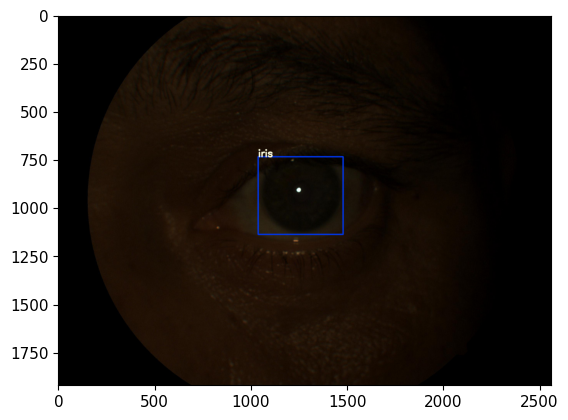

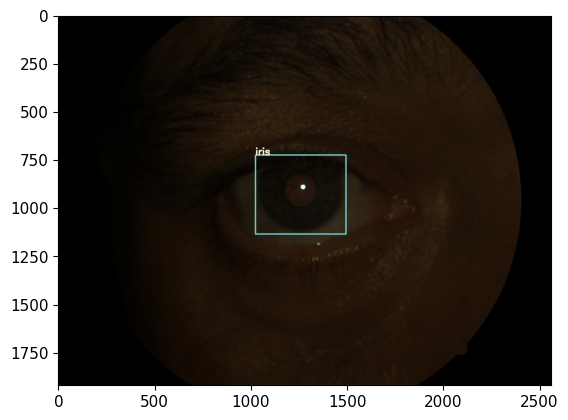

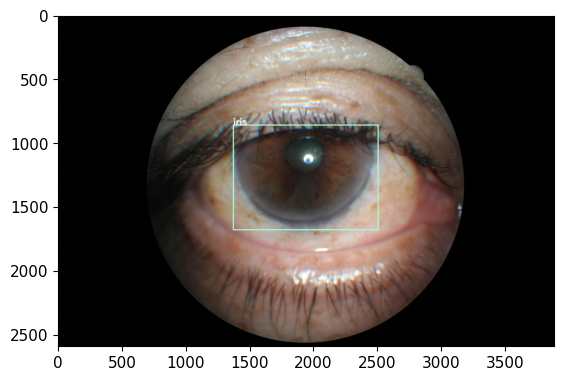

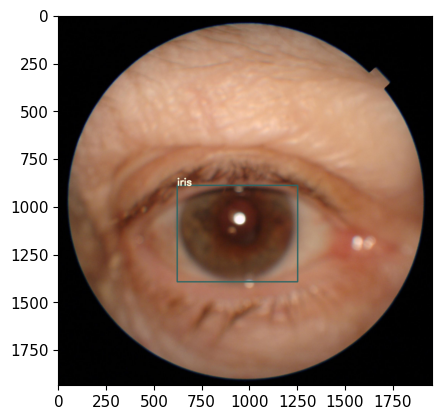

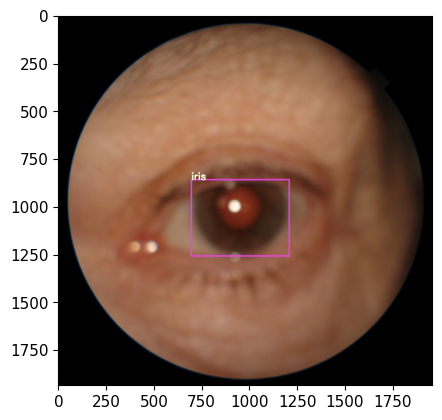

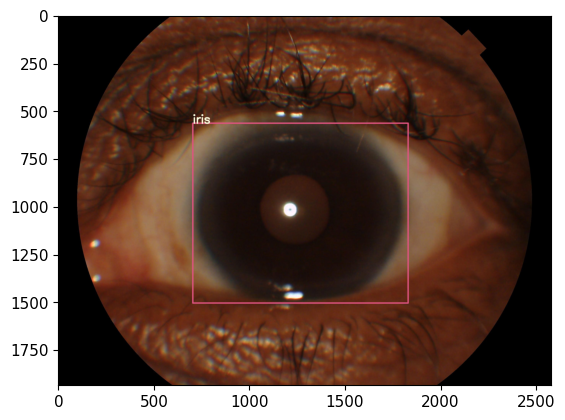

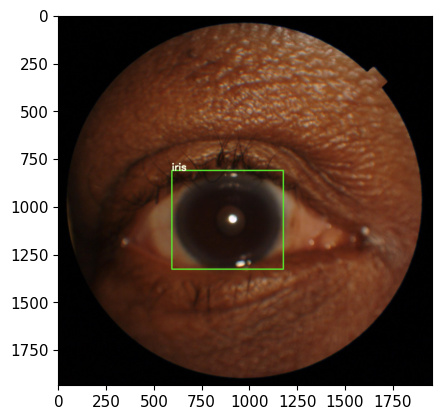

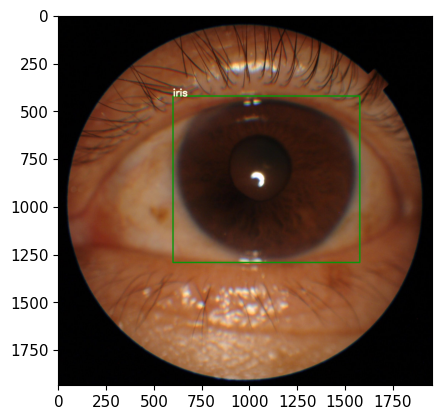

In [31]:
for i, image_to_display in enumerate(result_imgs):
  plt.figure()
  plt.imshow(image_to_display)

In [37]:
bboxes_by_img_path

{'EyePacs1KDataset/524876_969556_10760784_Left External.jpg': {'xmin': 1039,
  'ymin': 735,
  'xmax': 1480,
  'ymax': 1138},
 'EyePacs1KDataset/524876_969556_10760780_Right External.jpg': {'xmin': 1025,
  'ymin': 726,
  'xmax': 1495,
  'ymax': 1136},
 'EyePacs1KDataset/371956_1458068_14475121_Left External.JPG': {'xmin': 1306,
  'ymin': 845,
  'xmax': 2599,
  'ymax': 1816},
 'EyePacs1KDataset/371956_1458068_14475117_Right External.JPG': {'xmin': 1374,
  'ymin': 861,
  'xmax': 2509,
  'ymax': 1681},
 'EyePacs1KDataset/914922_1310562_13425710_Left External.jpg': {'xmin': 1751,
  'ymin': 1212,
  'xmax': 3407,
  'ymax': 2282},
 'EyePacs1KDataset/914922_1310562_13425711_Right External.jpg': {'xmin': 1933,
  'ymin': 1134,
  'xmax': 3457,
  'ymax': 2364},
 'EyePacs1KDataset/997848_1436380_14335043_Left External.JPG': {'xmin': 623,
  'ymin': 890,
  'xmax': 1253,
  'ymax': 1394},
 'EyePacs1KDataset/997848_1436380_14335042_Left External.JPG': {'xmin': 697,
  'ymin': 860,
  'xmax': 1209,
  'ymax'

In [42]:
target_dir = os.path.join(images_root, "normalized_eye_image_dataset", "iris_cropped_results")
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

counter = 0

for i, row in df.iterrows():
   
    # Get the basename of the image path, eg, EyePacs1KDataset/eye_0001.jpg -> eye_0001.jpg
    image_path_basename = os.path.basename(row["image_path"])
    image_path = os.path.join(images_root, image_path_basename)

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Find the bounding box for the iris
    bbox_by_img_path_dict = bboxes_by_img_path[image_path]
    xmin = bbox_by_img_path_dict["xmin"]
    ymin = bbox_by_img_path_dict["ymin"]
    xmax = bbox_by_img_path_dict["xmax"]
    ymax = bbox_by_img_path_dict["ymax"]

    # Crop the image to the bounding box
    cropped_image = crop_iris_region(image, (xmin, ymin, xmax, ymax))

    # Write the cropped image to the new location
    target_path = os.path.join(target_dir, image_path_basename)
    cv2.imwrite(target_path, cropped_image)

    counter += 1
    # if counter > 10:
    #     break

img height: 1920 width: 2560
bbox: (1039, 735, 1480, 1138)
bbox_width: 441 bbox_height: 403
bbox_width > bbox_height
crop_xmin: 928 crop_xmax: 1590
img height: 1920 width: 2560
bbox: (1025, 726, 1495, 1136)
bbox_width: 470 bbox_height: 410
bbox_width > bbox_height
crop_xmin: 907 crop_xmax: 1612
img height: 2592 width: 3888
bbox: (1306, 845, 2599, 1816)
bbox_width: 1293 bbox_height: 971
bbox_width > bbox_height
crop_xmin: 982 crop_xmax: 2922
img height: 2592 width: 3888
bbox: (1374, 861, 2509, 1681)
bbox_width: 1135 bbox_height: 820
bbox_width > bbox_height
crop_xmin: 1090 crop_xmax: 2792
img height: 3648 width: 5472
bbox: (1751, 1212, 3407, 2282)
bbox_width: 1656 bbox_height: 1070
bbox_width > bbox_height
crop_xmin: 1337 crop_xmax: 3821
img height: 3648 width: 5472
bbox: (1933, 1134, 3457, 2364)
bbox_width: 1524 bbox_height: 1230
bbox_width > bbox_height
crop_xmin: 1552 crop_xmax: 3838
img height: 1934 width: 1956
bbox: (623, 890, 1253, 1394)
bbox_width: 630 bbox_height: 504
bbox_width